In [3]:
#!/usr/bin/env python3

# add the path to the folder above, hardcoded
import sys
pathhere = "/home/luke/mymujoco/rl/"
sys.path.insert(0, pathhere)

from env.MjEnv import MjEnv
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import savefig
import pickle

# increase matplotlib resolution
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

finger_params = (0.9, 28)

# create and prepare the mujoco instance
mj = MjEnv(noload=True)
mj.testing_xmls = 0
mj.task_reload_chance = -1

In [4]:
with open("real_finger_data.pickle", "rb") as f:
  real_finger_data = pickle.load(f)

# check if we are running with a finger we have real data for
if finger_params == (0.9, 28):
  ind = 0
  fingernum = 3 # 3>2>1, 
elif finger_params == (1.0, 24):
  ind = 1
  fingernum = 3 # 1>3>2, 1&3 excellent, 2 poor (max ~10%, avg ~6%), 2 the 0g sample is clearly different from the others
elif finger_params == (1.0, 28):
  ind = 2
  fingernum = 2 # 2>1>3, 2 excellent, 1&3 poor (max ~8%, avg ~4%)
else:
  ind = None

real_data = [ [ [] for i in range(3)] for j in range(3) ]

if ind is not None:
  for j in range(3):

    # # 3 entries, one for each finger we collected real data for
    # real_data = [ [] for i in range(3) ]

    for i in range(3):

      # get the raw profiles
      real_0g = real_finger_data[j][i][0]
      real_100g = real_finger_data[j][i][1]
      real_200g = real_finger_data[j][i][2]
      real_300g = real_finger_data[j][i][3]

      # check the zero
      # if real_100g[0, 0] < 0: real_100g[:, 0] -= real_100g[0, 0]
      if j == 2 and i == 1:
        print(real_200g[:10, 0])
        print(real_200g[:10, 1])
        myslice = real_200g[:4]
        myslice = np.flip(myslice, axis=0)
        print(myslice)
        real_200g[:4] = myslice
        real_200g[:, 0] -= real_200g[0, 0]
        real_200g[:, 1] -= real_200g[0, 1]
        print(real_200g[:10])
      # if real_300g[0, 0] < 0: real_300g[:, 0] -= real_300g[0, 0]

      # subract the 0g case from the other deflection
      diff_vec_100g = mj.mj.profile_error(real_100g[:,0], real_100g[:,1], real_0g[:,0], real_0g[:,1], False)
      diff_vec_200g = mj.mj.profile_error(real_200g[:,0], real_200g[:,1], real_0g[:,0], real_0g[:,1], False)
      diff_vec_300g = mj.mj.profile_error(real_300g[:,0], real_300g[:,1], real_0g[:,0], real_0g[:,1], False)

      # put in the subracted y values
      real_100g[:,1] = diff_vec_100g
      real_200g[:,1] = diff_vec_200g
      real_300g[:,1] = diff_vec_300g

      real_data_minus_0g = [
        real_100g,
        real_200g,
        real_300g,
      ]

      real_data[j][i] = real_data_minus_0g

else: real_data = None

[  0.          -6.04887974 -11.80477285 -17.75643999   5.72273957
  10.85500983  22.00165746  28.51794483  37.14638923  43.24782724]
[ 0.         -0.1812889  -0.26041952 -0.37495173  0.11138496  0.34549277
  0.89125562  1.17710068  1.68824388  2.01199918]
[[-17.75643999  -0.37495173]
 [-11.80477285  -0.26041952]
 [ -6.04887974  -0.1812889 ]
 [  0.           0.        ]]
[[ 0.          0.        ]
 [ 5.95166714  0.1145322 ]
 [11.70756025  0.19366283]
 [17.75643999  0.37495173]
 [23.47917956  0.48633669]
 [28.61144982  0.7204445 ]
 [39.75809745  1.26620735]
 [46.27438482  1.55205241]
 [54.90282922  2.06319561]
 [61.00426723  2.38695091]]


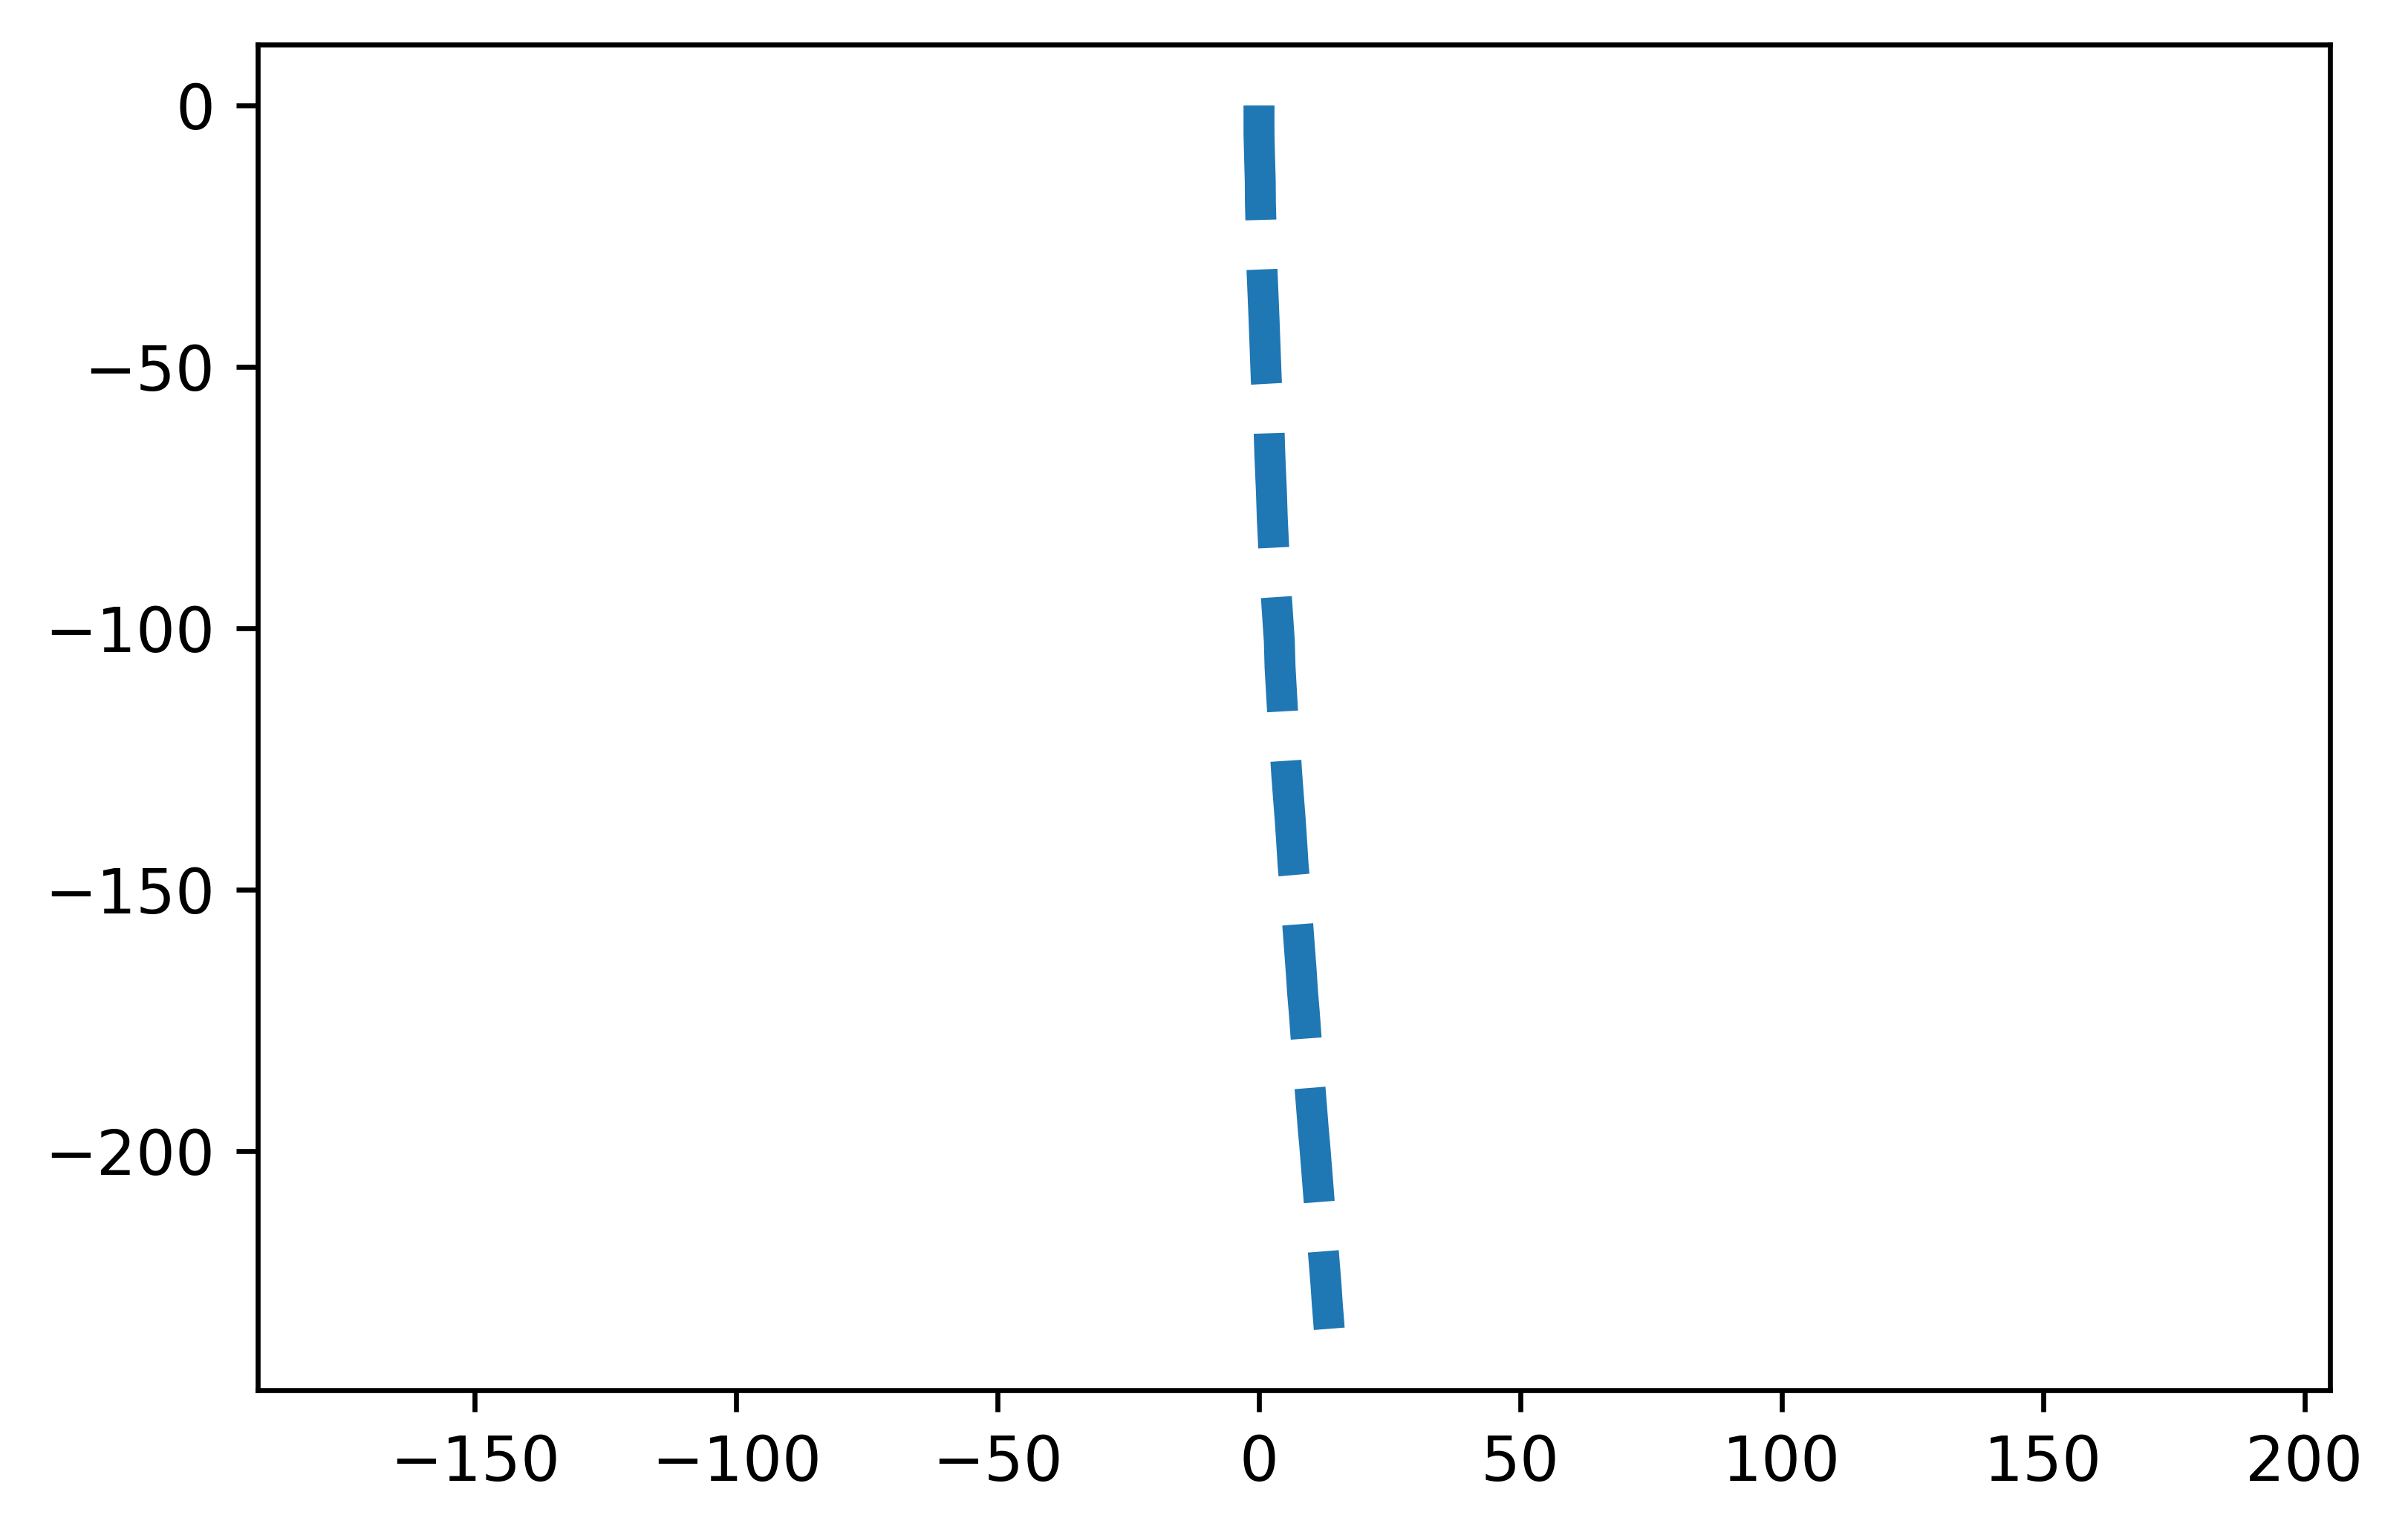

In [30]:
# now plot and save figures of the profiles
def plot_profile(name, xy, rotdegrees=90, mirrorx=False, plot=False, save=False):
  """
  Plot the beam profile vertically
  """

  # xy = np.column_stack(x, y)

  # we want to plot vertically so rotate the profile
  torad = np.pi / 180.0
  rot = np.array([
    [np.cos(rotdegrees * torad), -np.sin(rotdegrees * torad)],
    [np.sin(rotdegrees * torad),  np.cos(rotdegrees * torad)]
  ])

  xy_rot = xy @ rot

  if mirrorx:
    xy_rot[:, 0] *= -1

  # now plot
  fig, axs = plt.subplots(1, 1)

  axs.plot(xy_rot[:, 0], xy_rot[:, 1], "--", linewidth="5")
  axs.axis("equal")

  if save:
    fig.set_size_inches(9, 9)
    fig.savefig(f"/home/luke/Pictures/real_profiles/{name}.png", transparent=True, format="png", dpi=600)

  if plot:
    plt.show()

plot_profile("test", real_data[0][0][0], rotdegrees=90, plot=True)


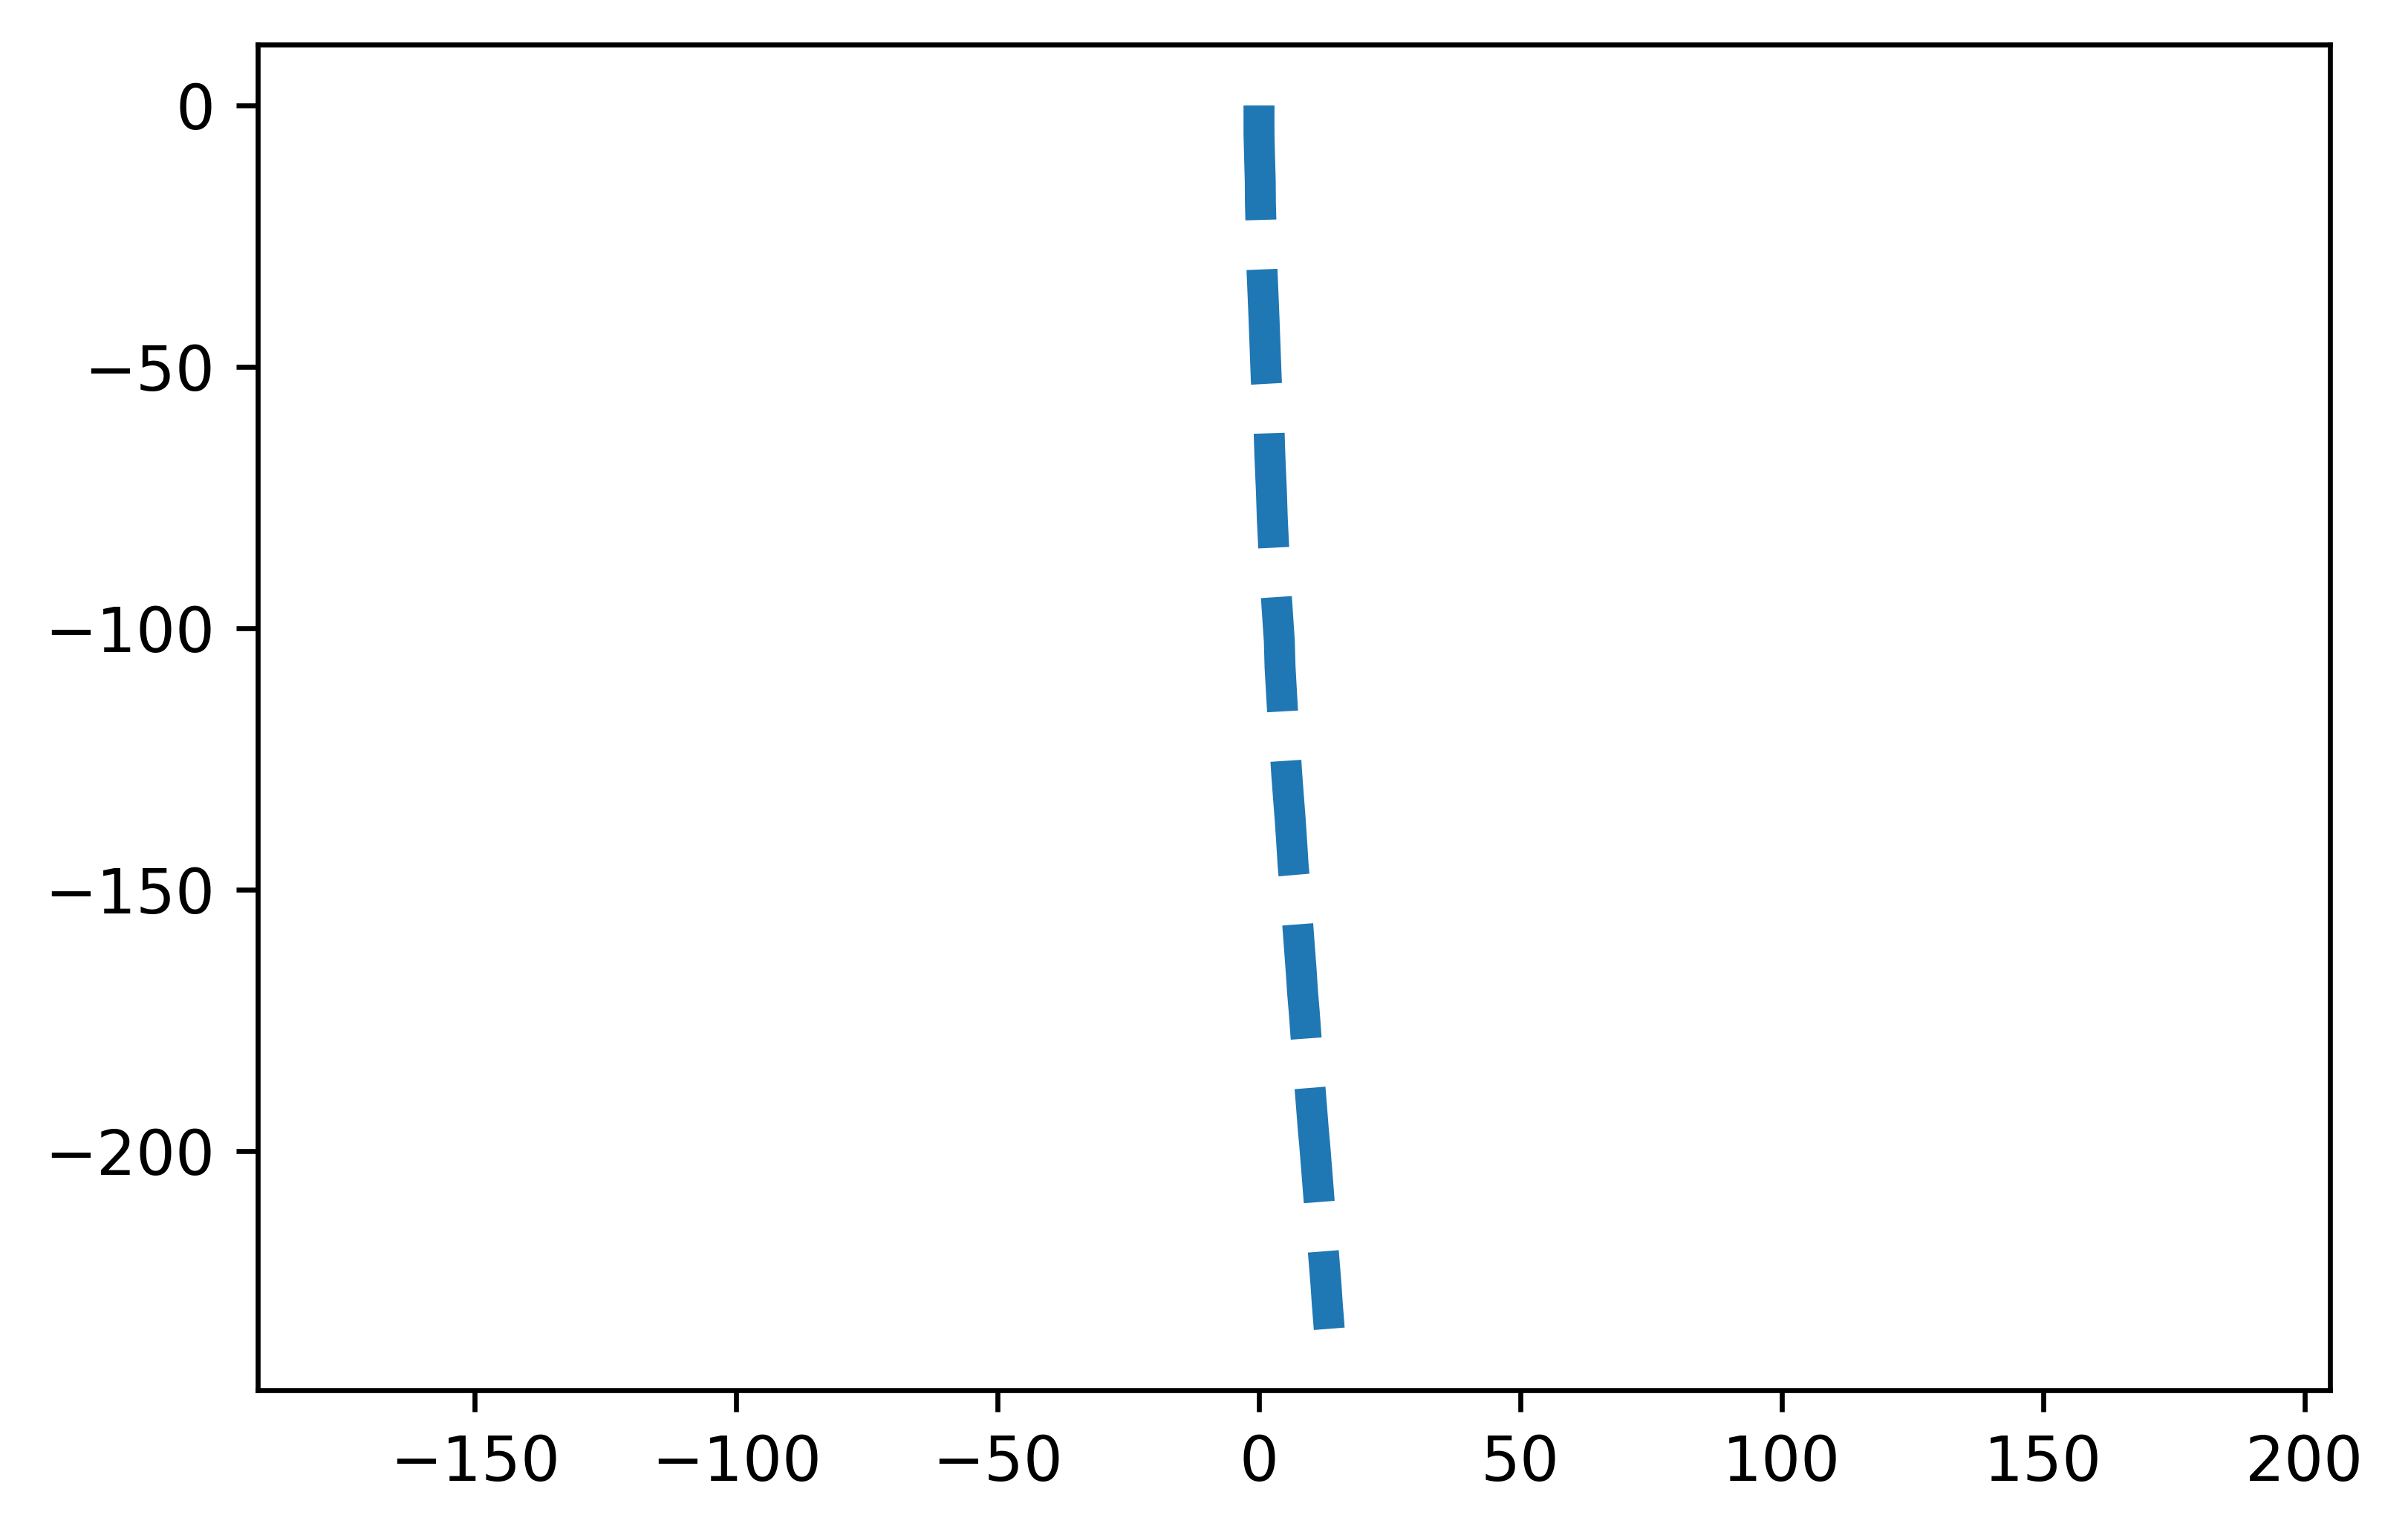

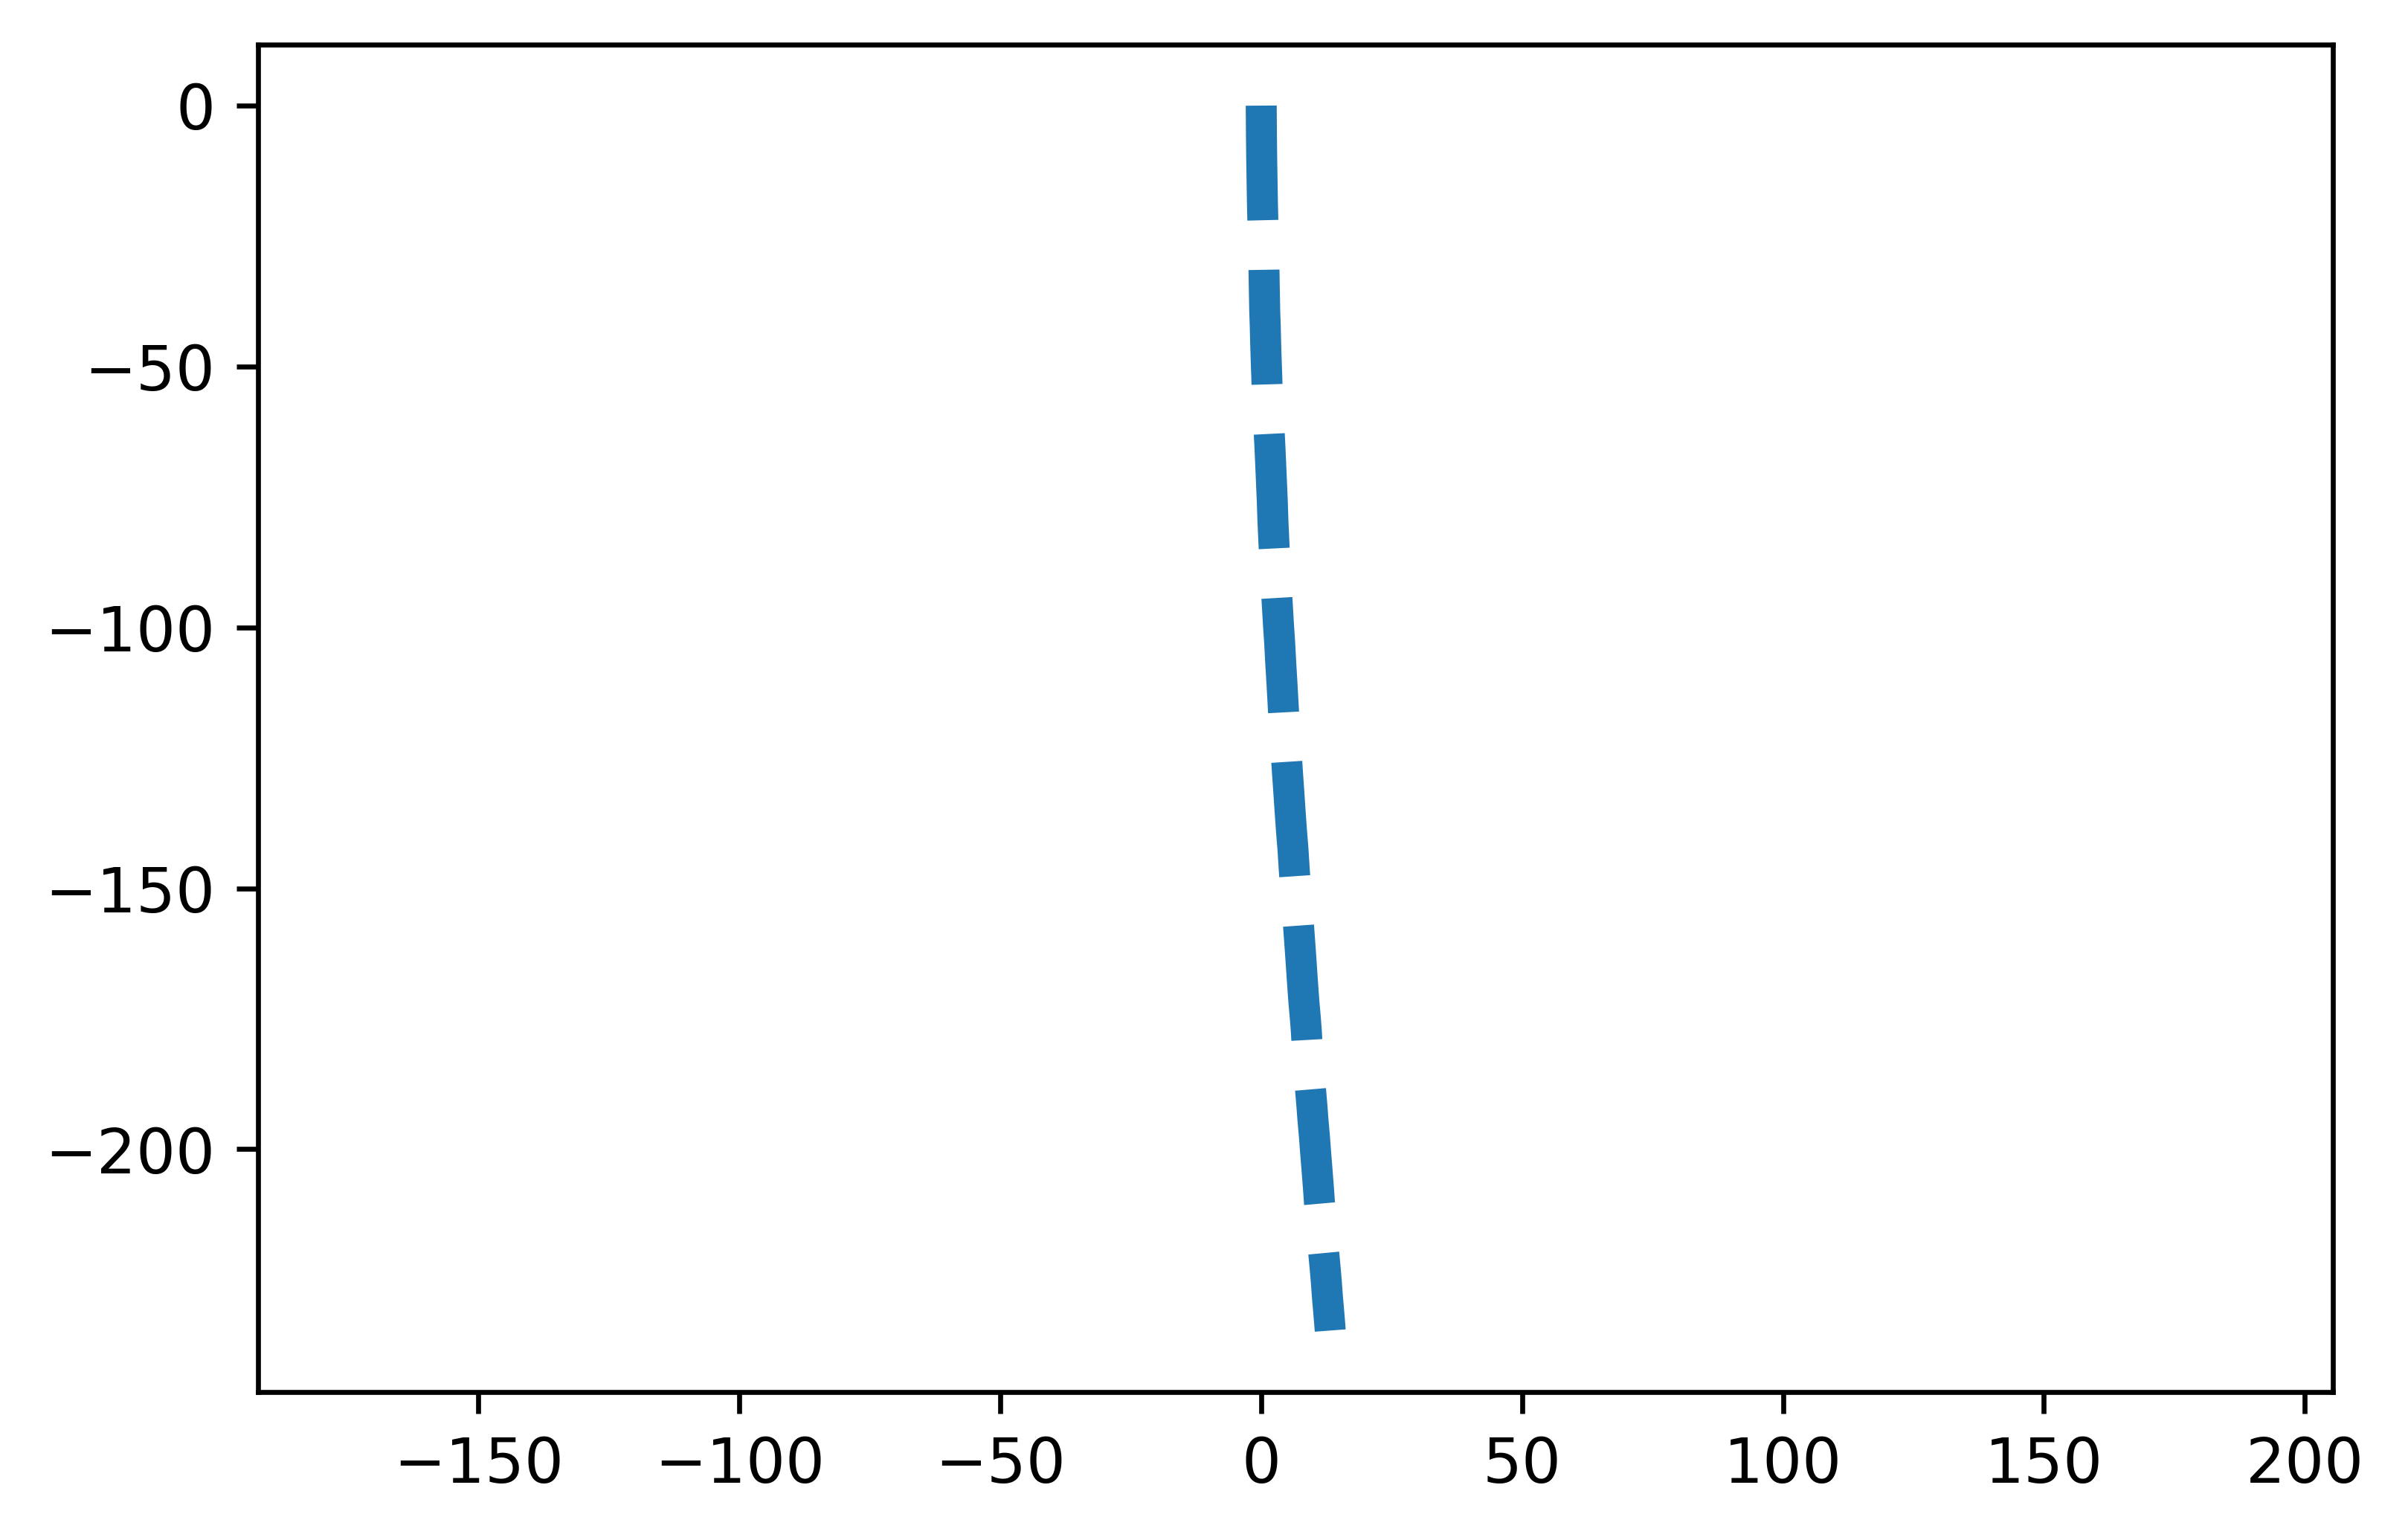

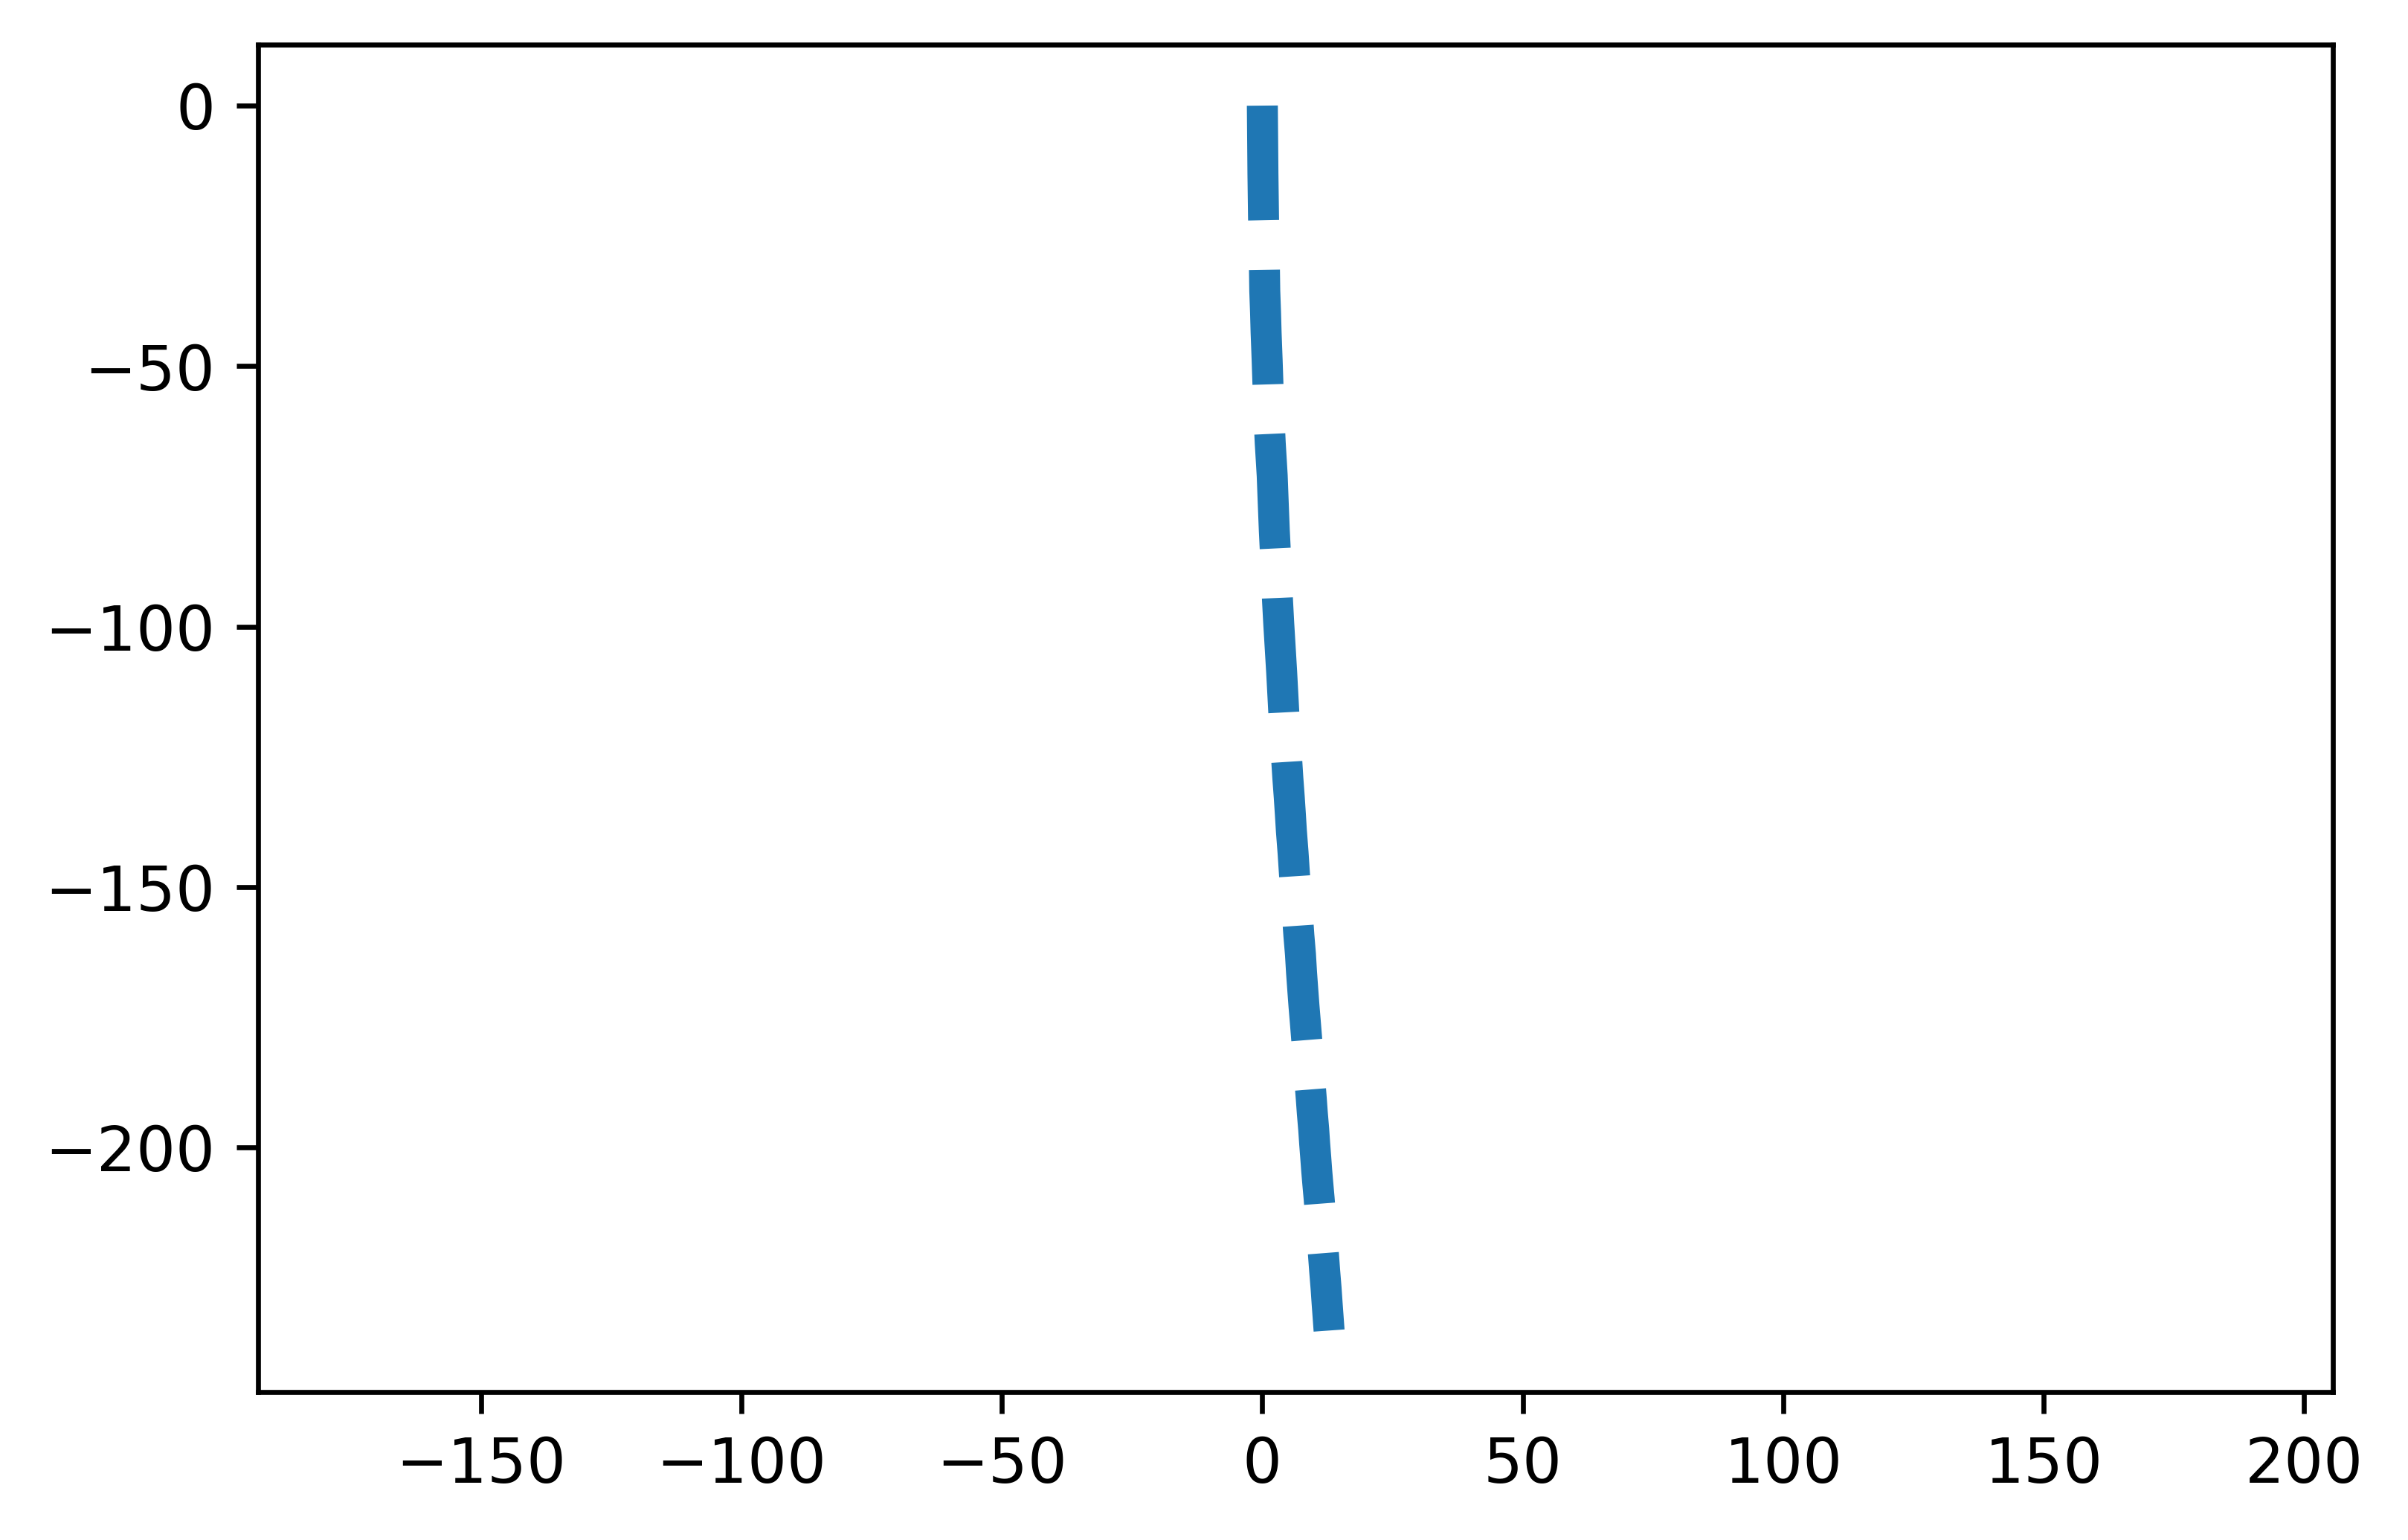

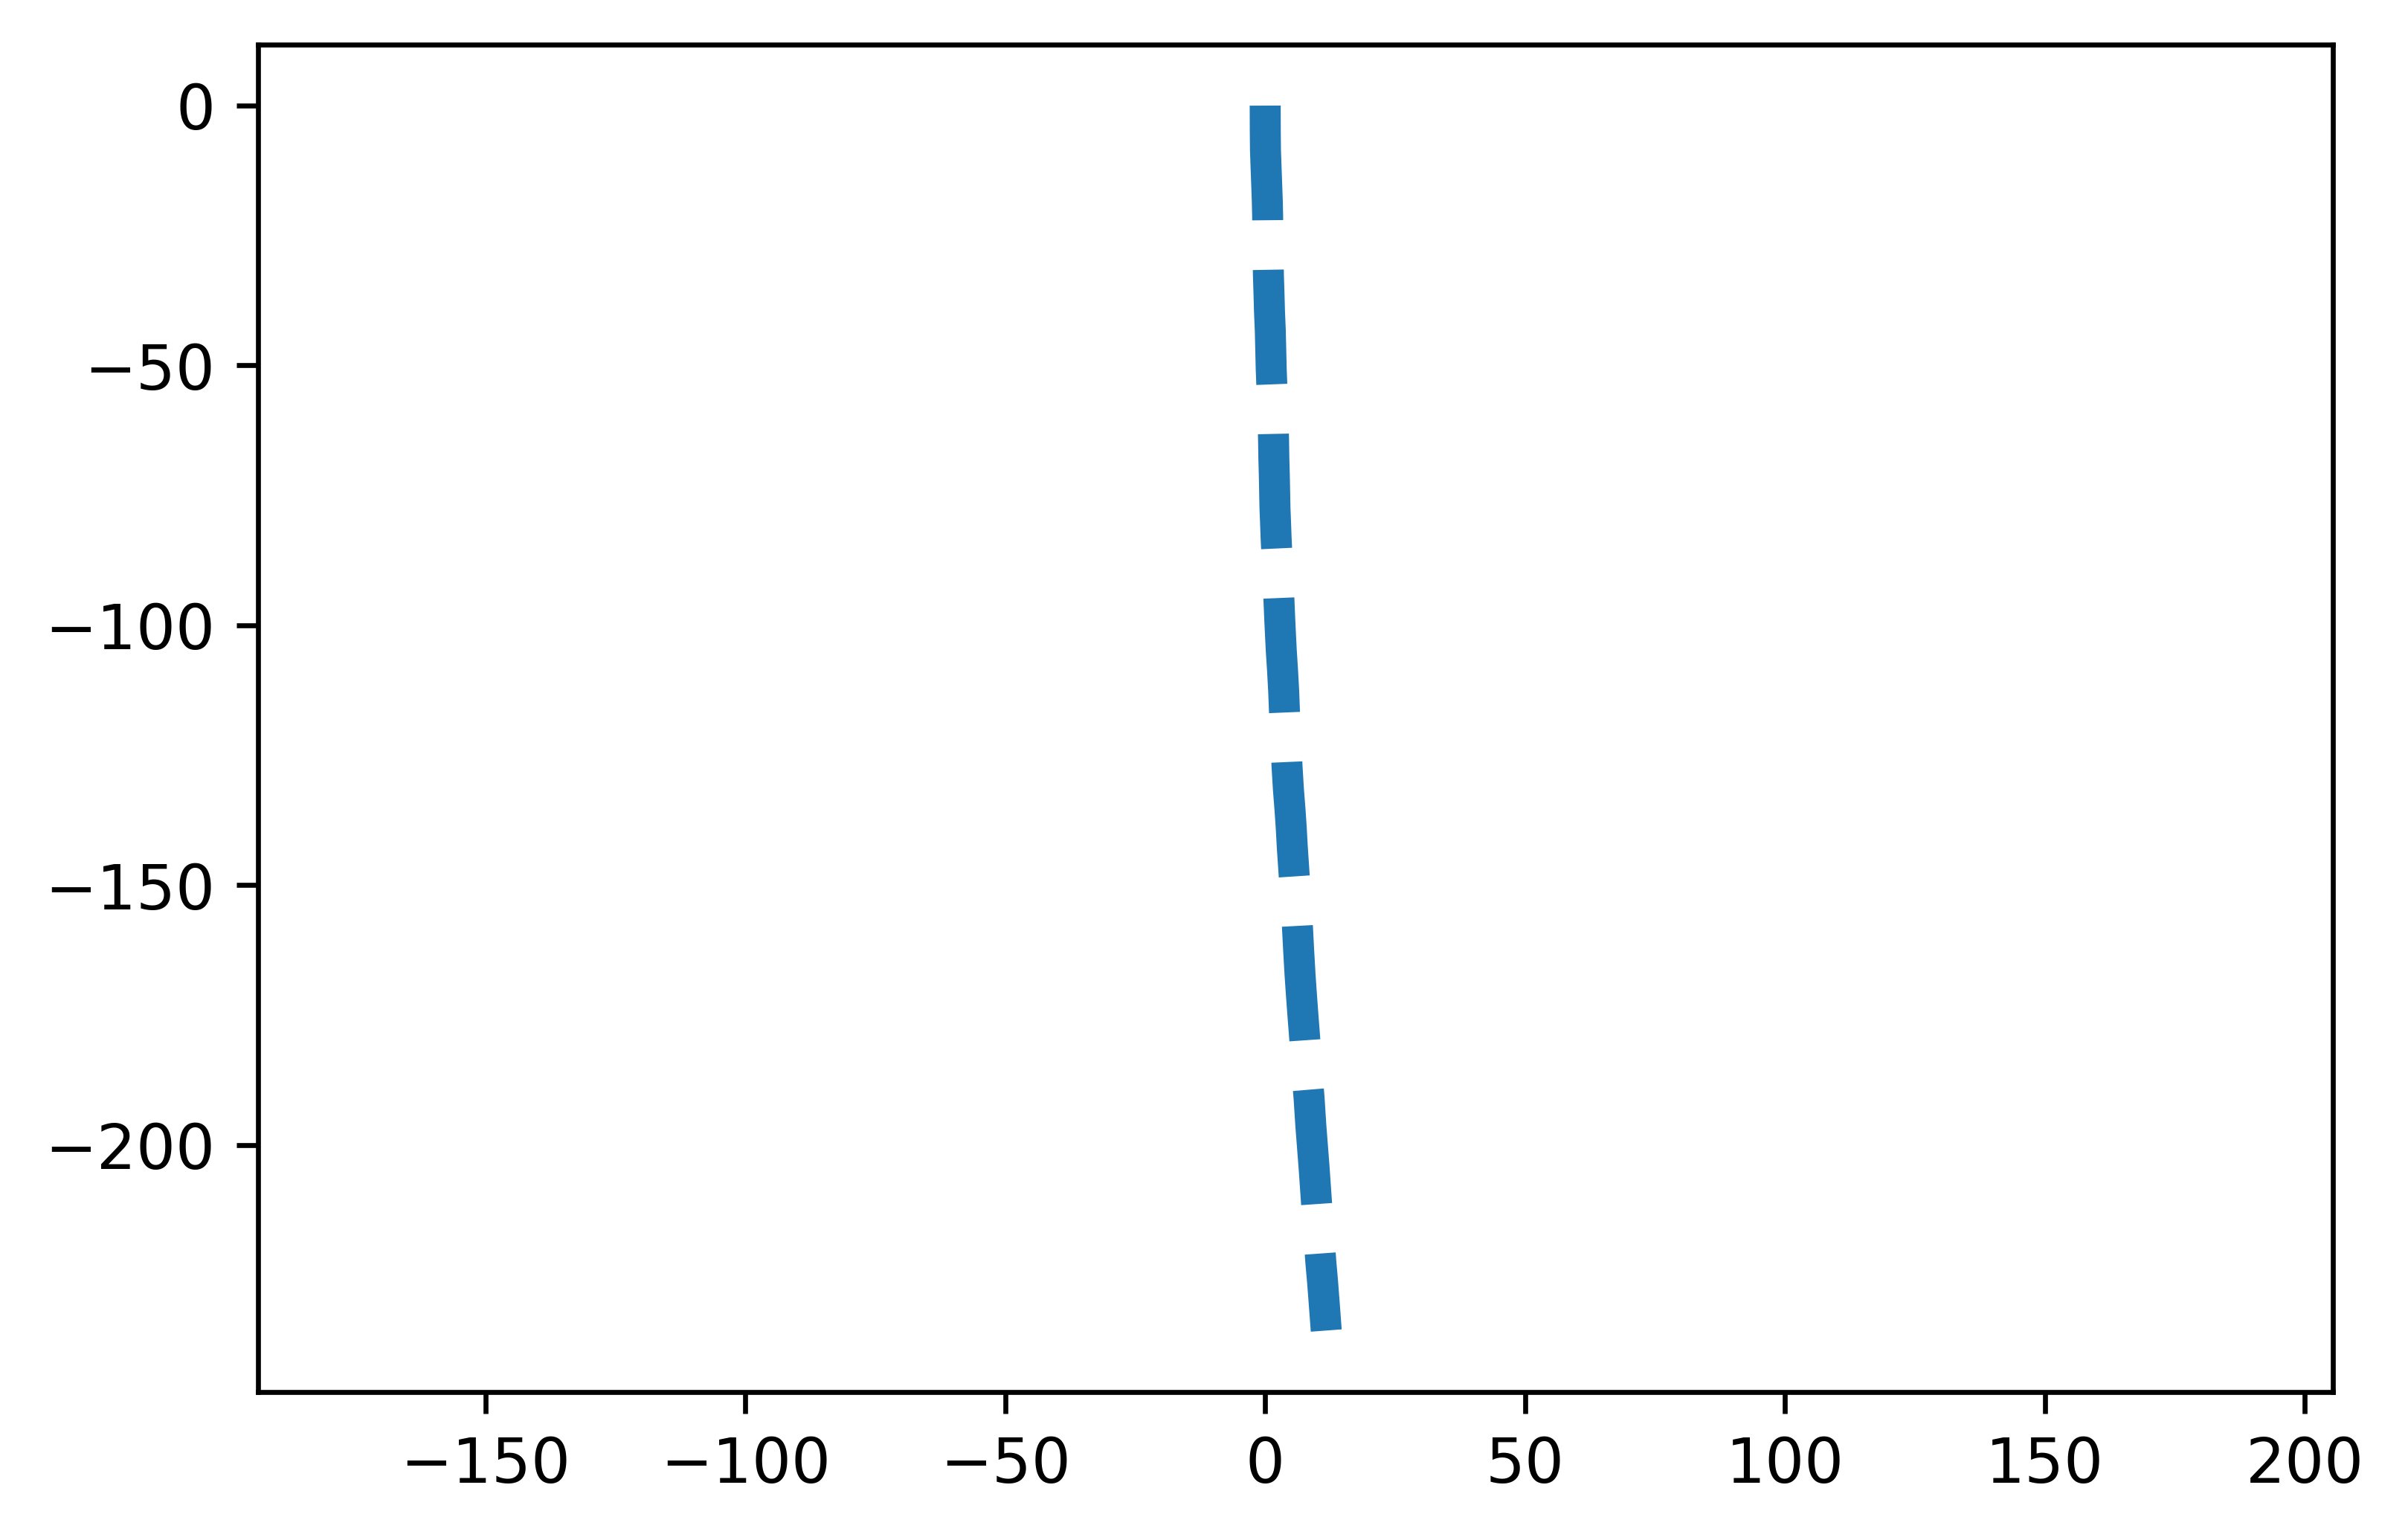

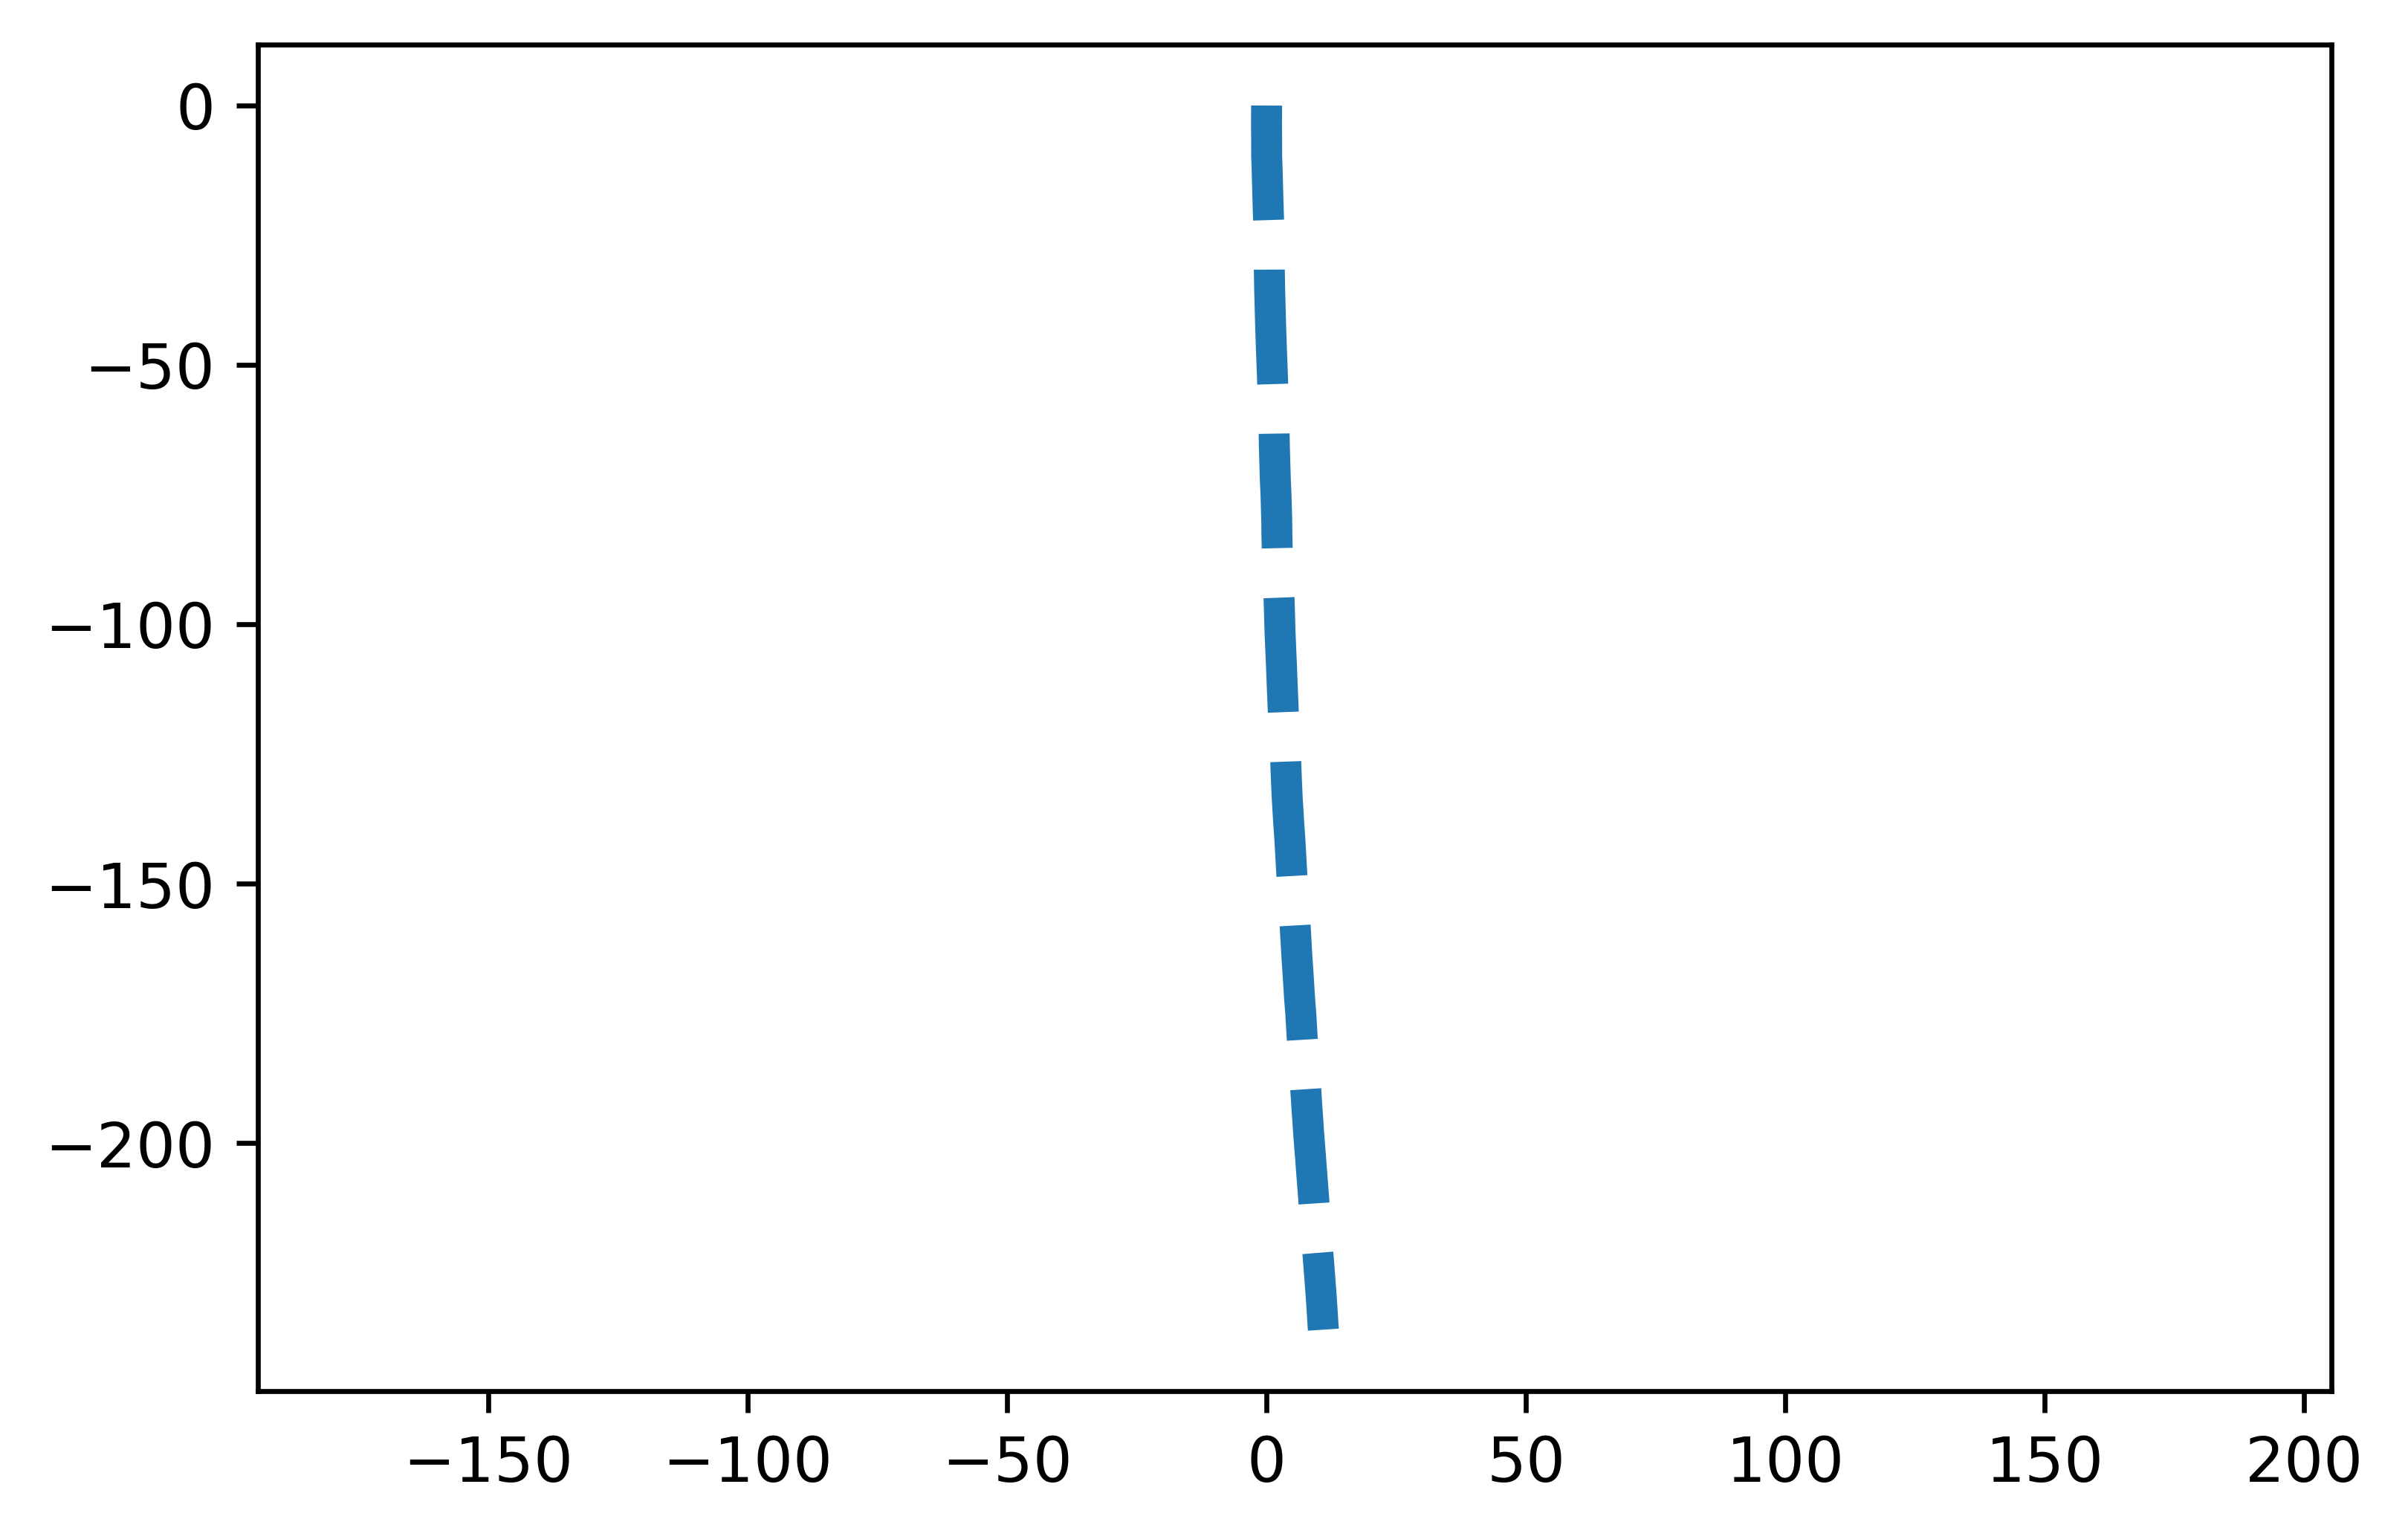

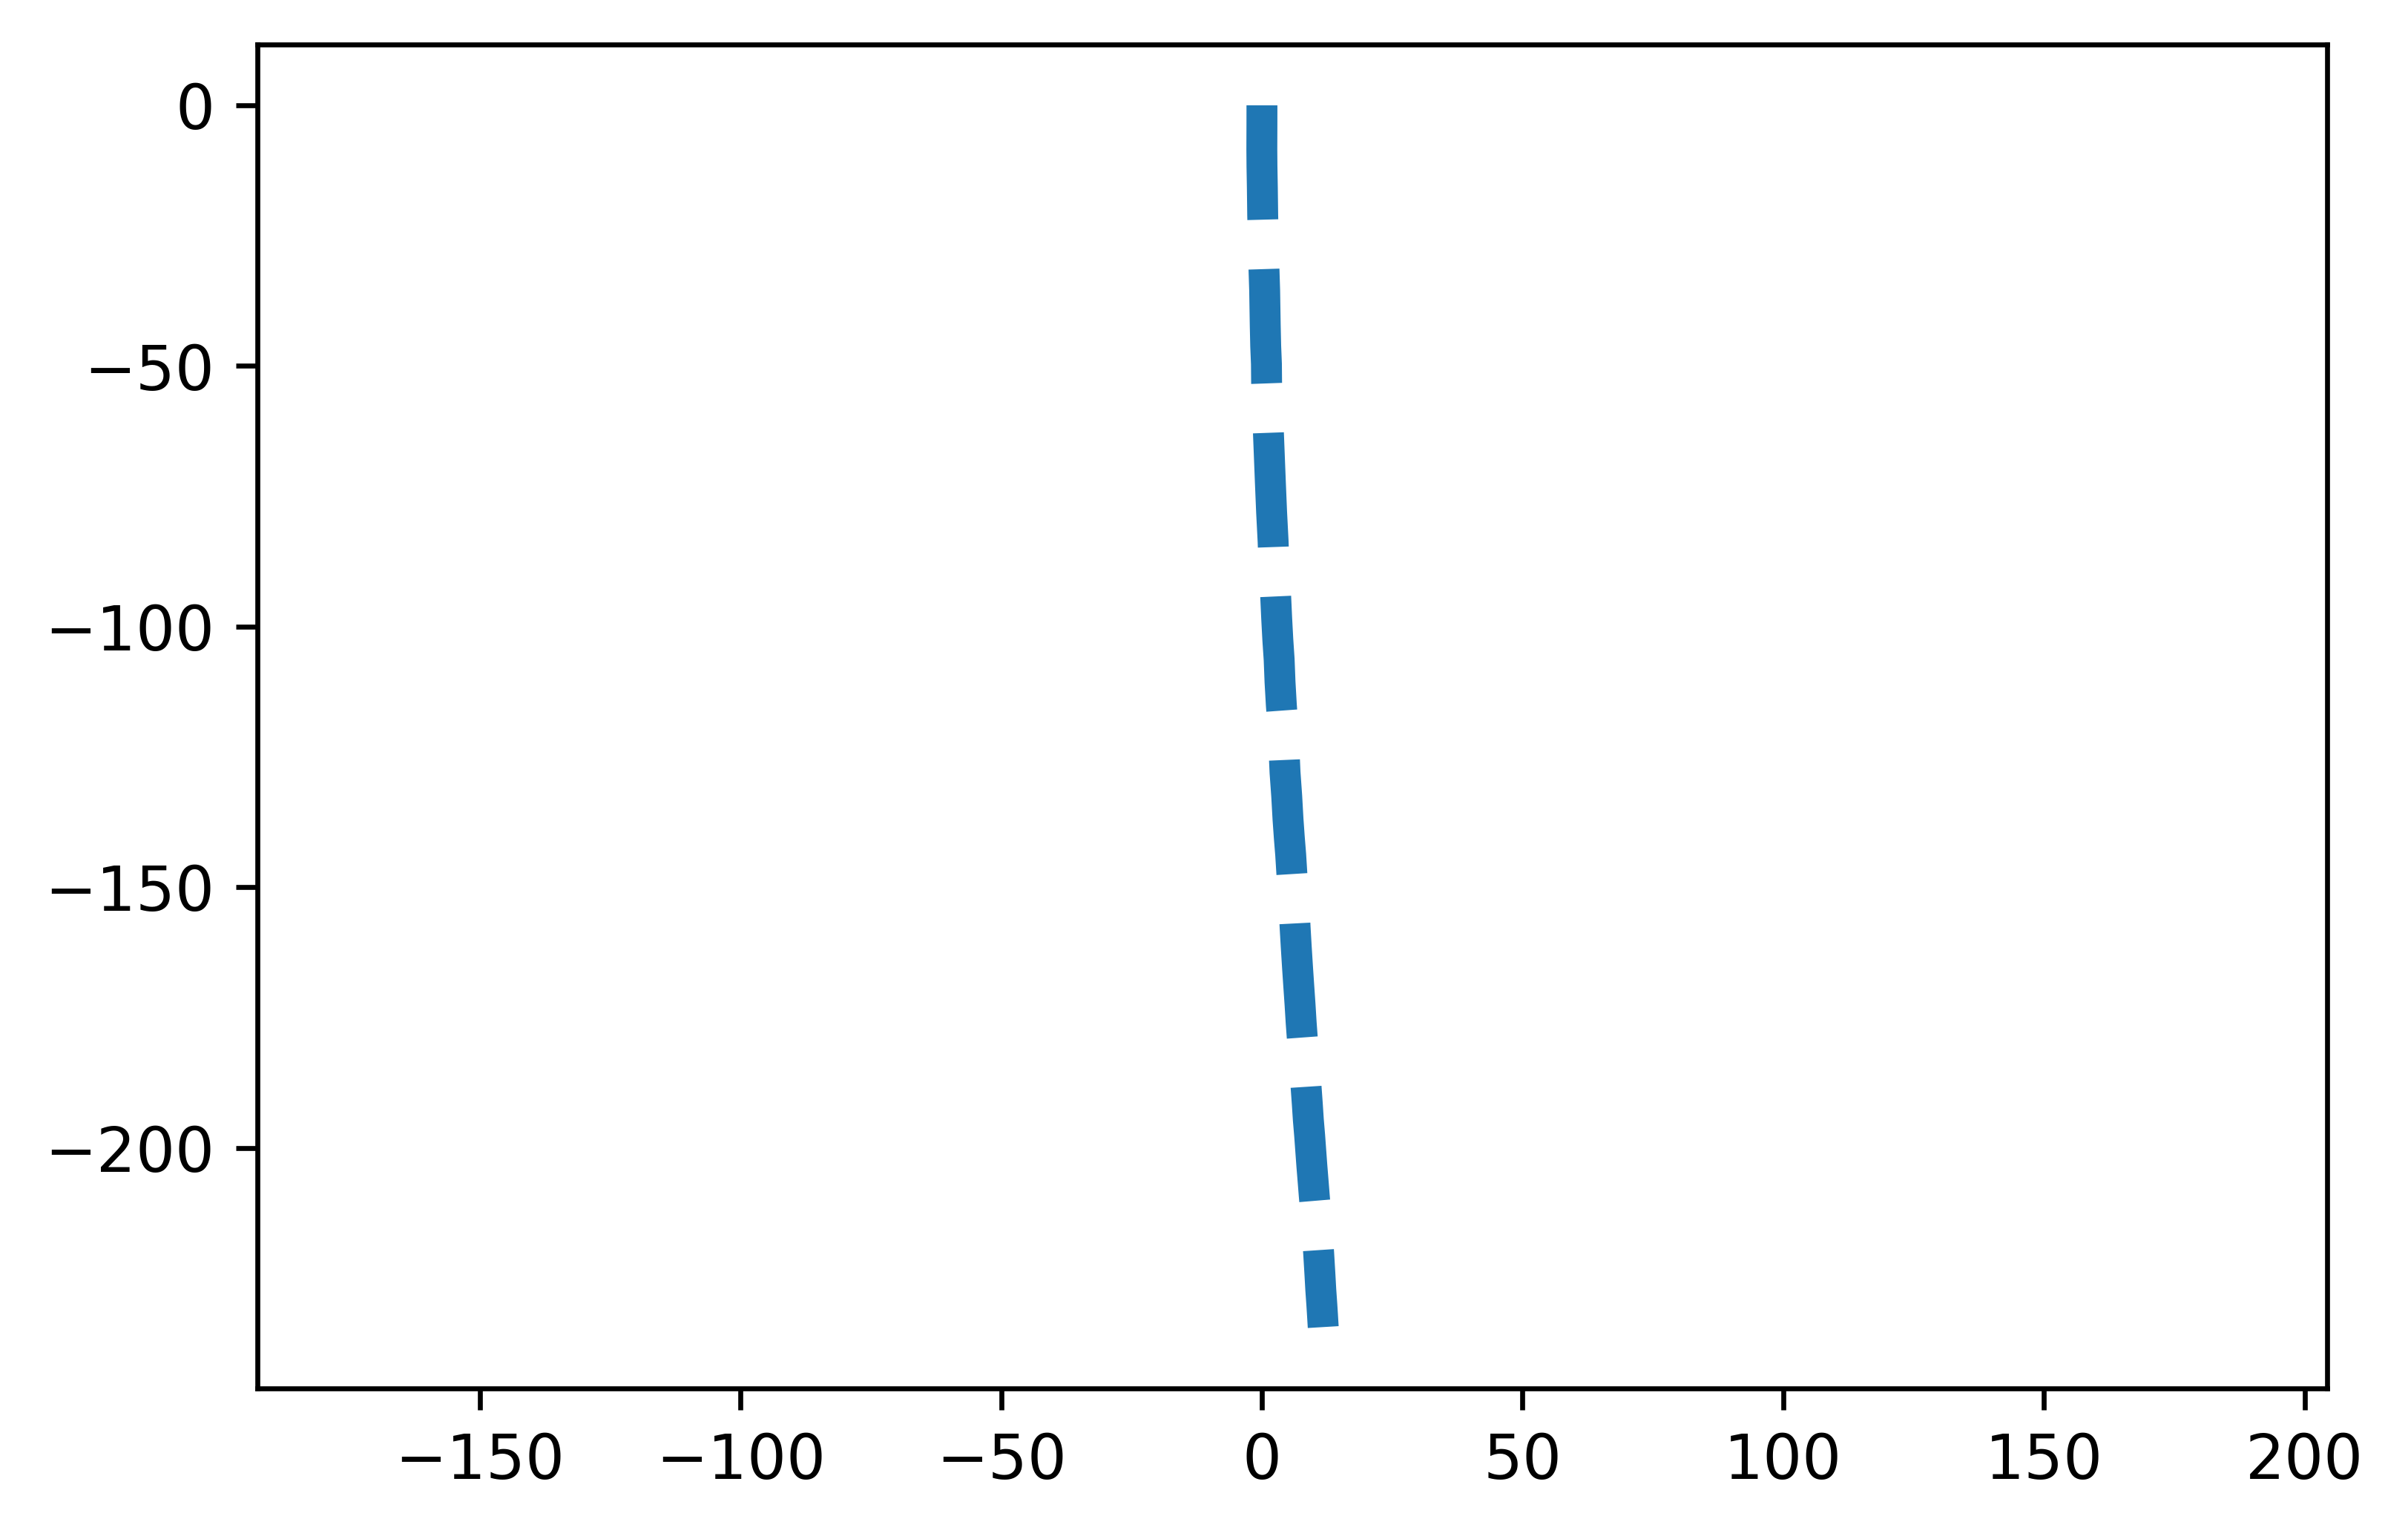

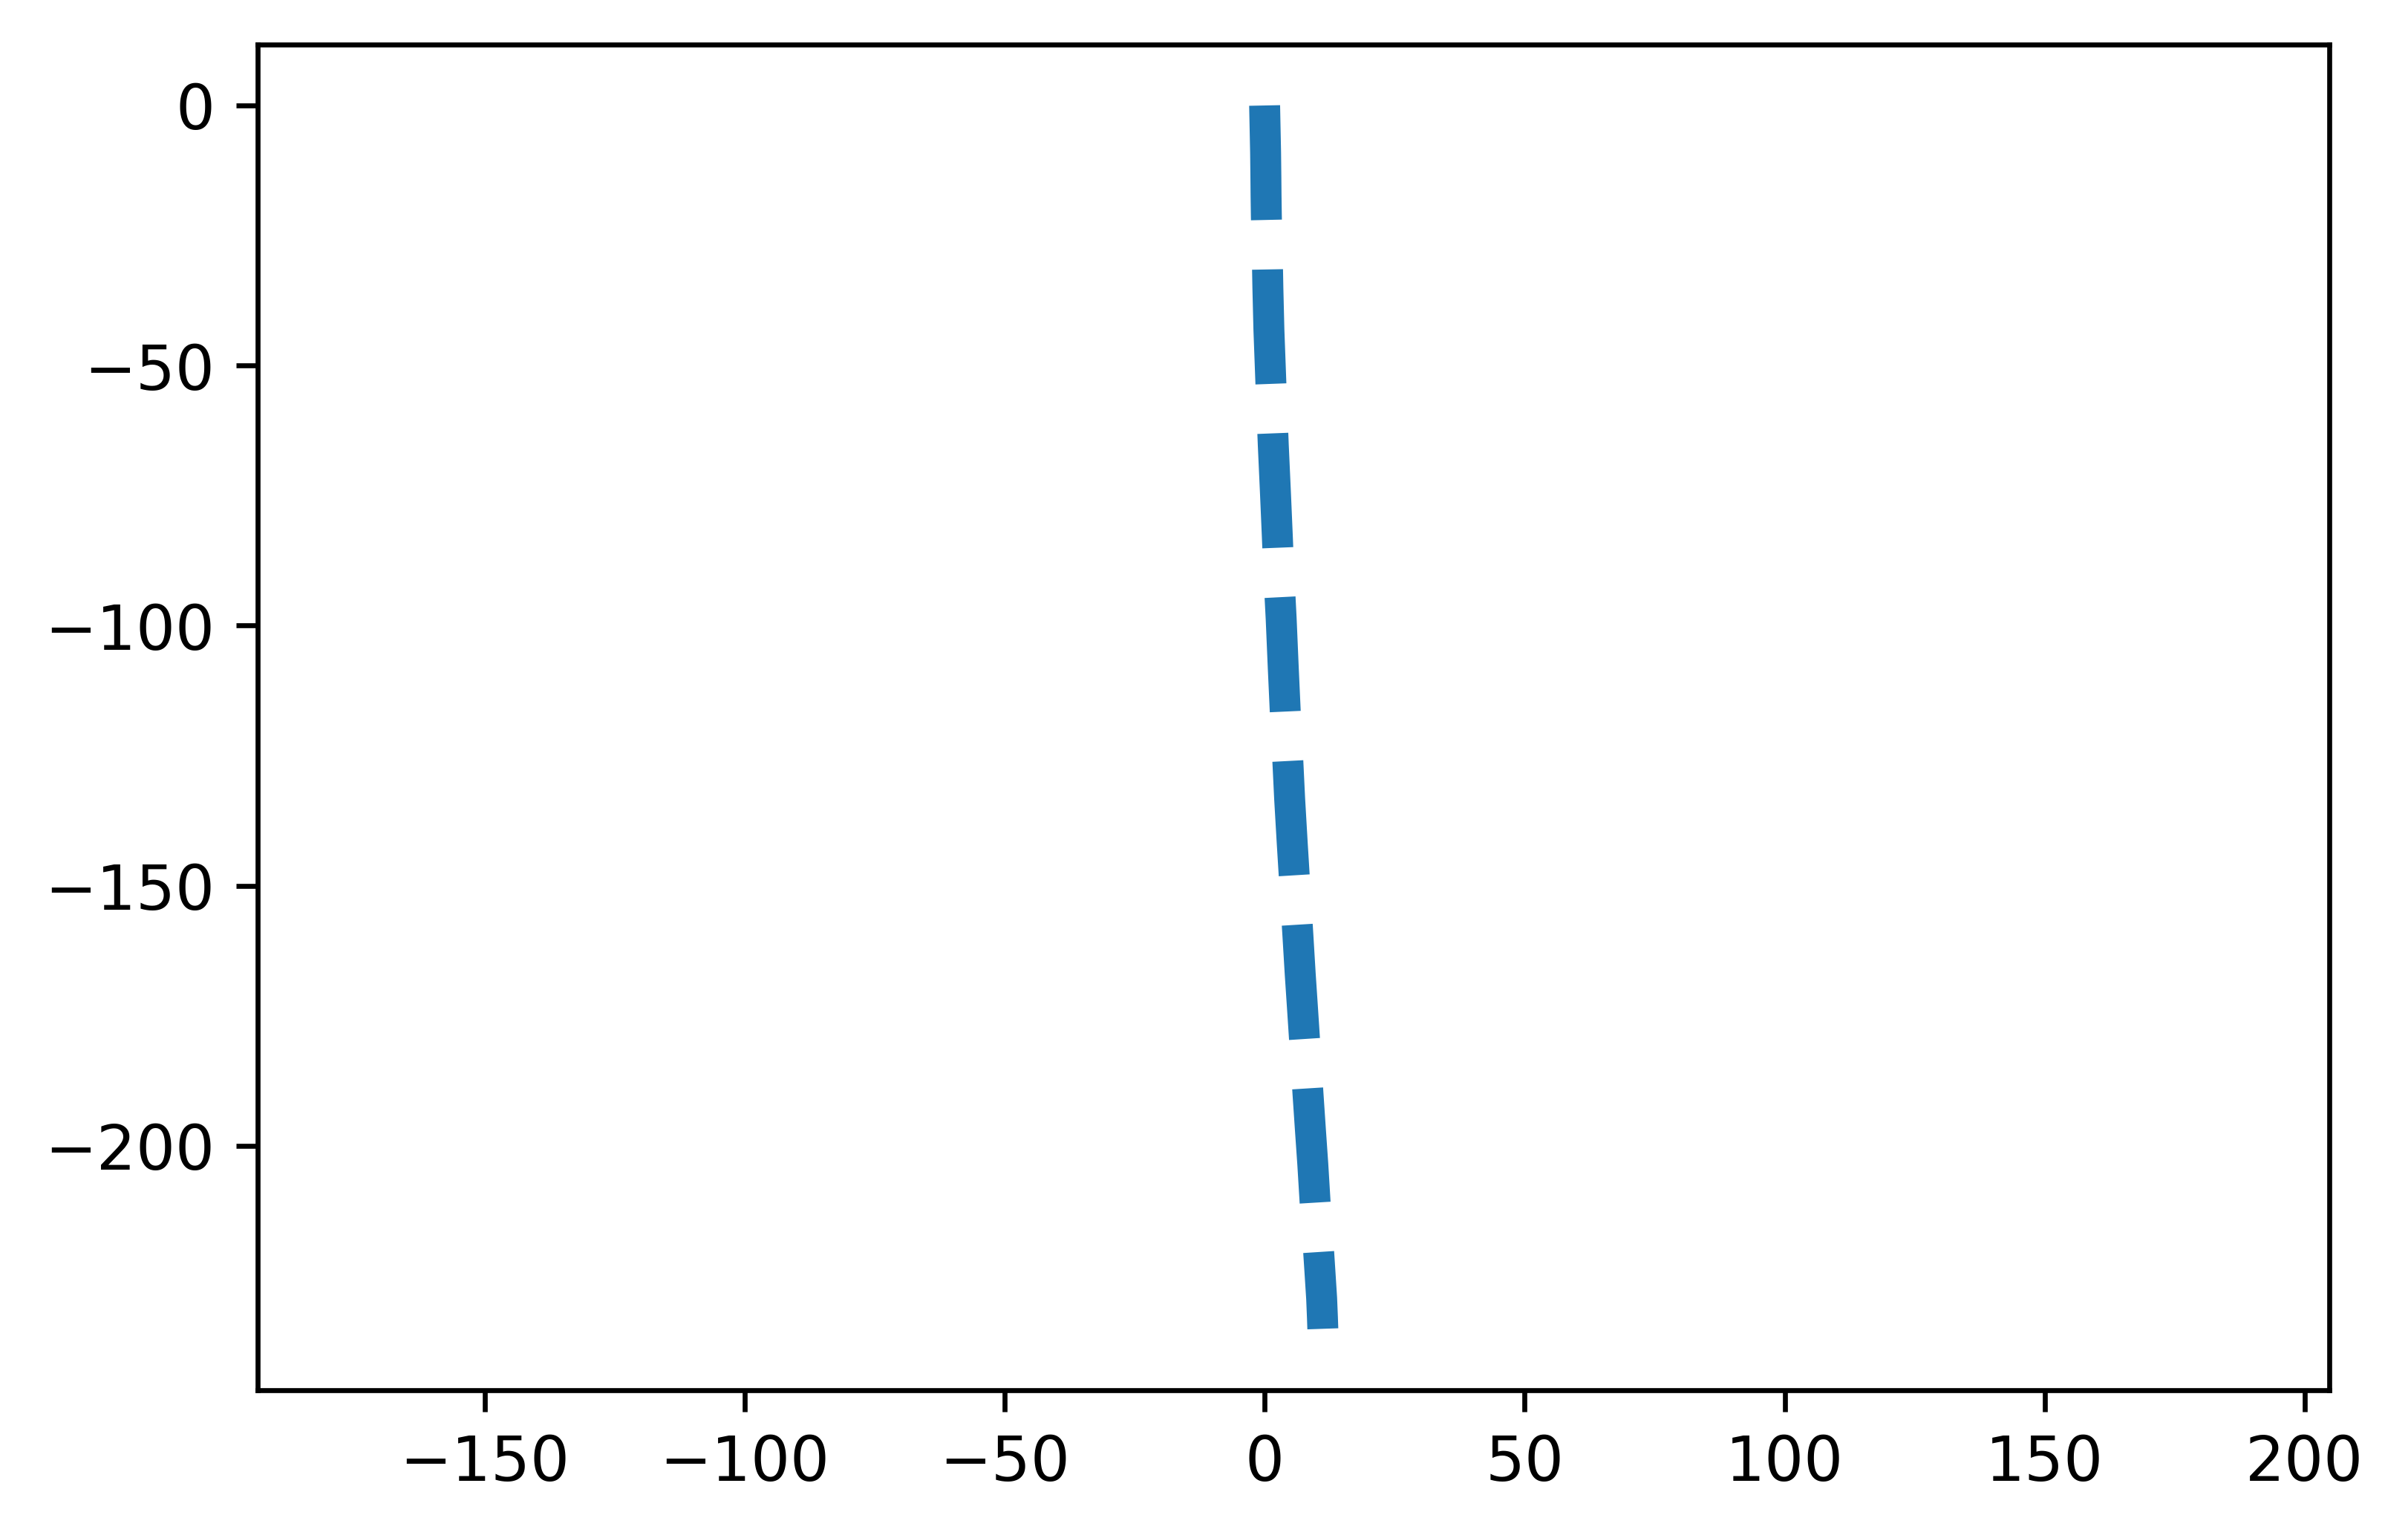

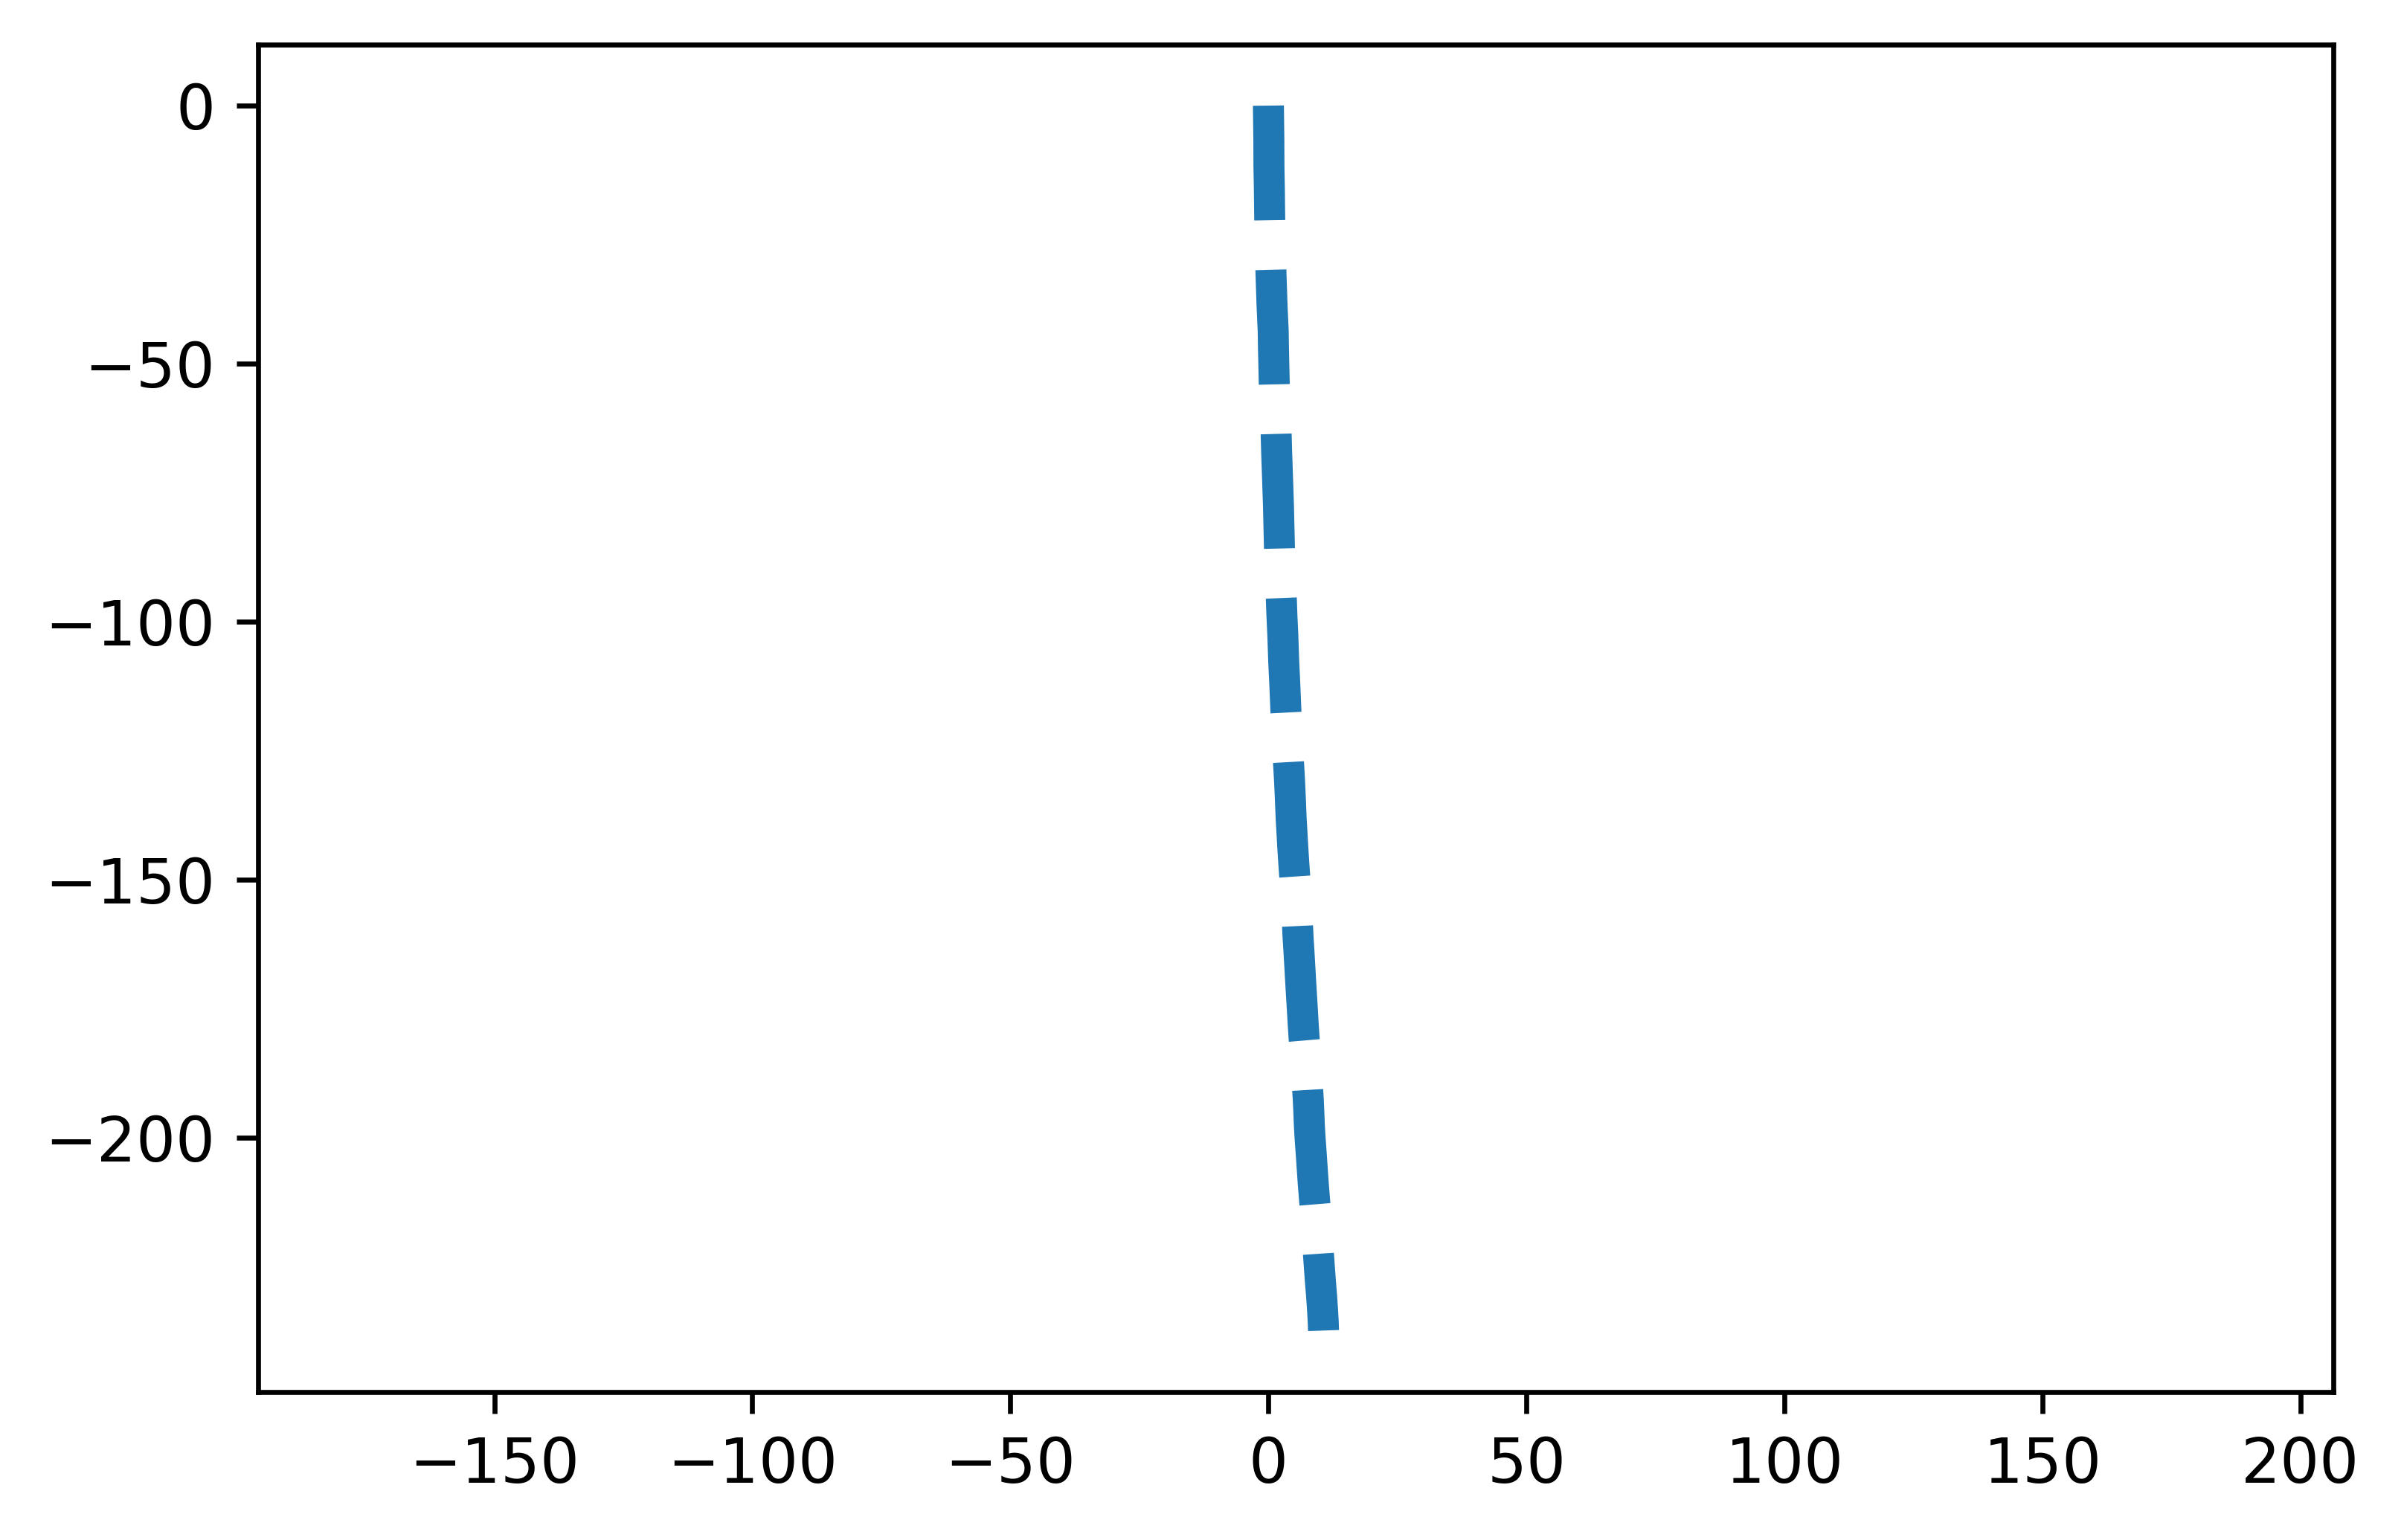

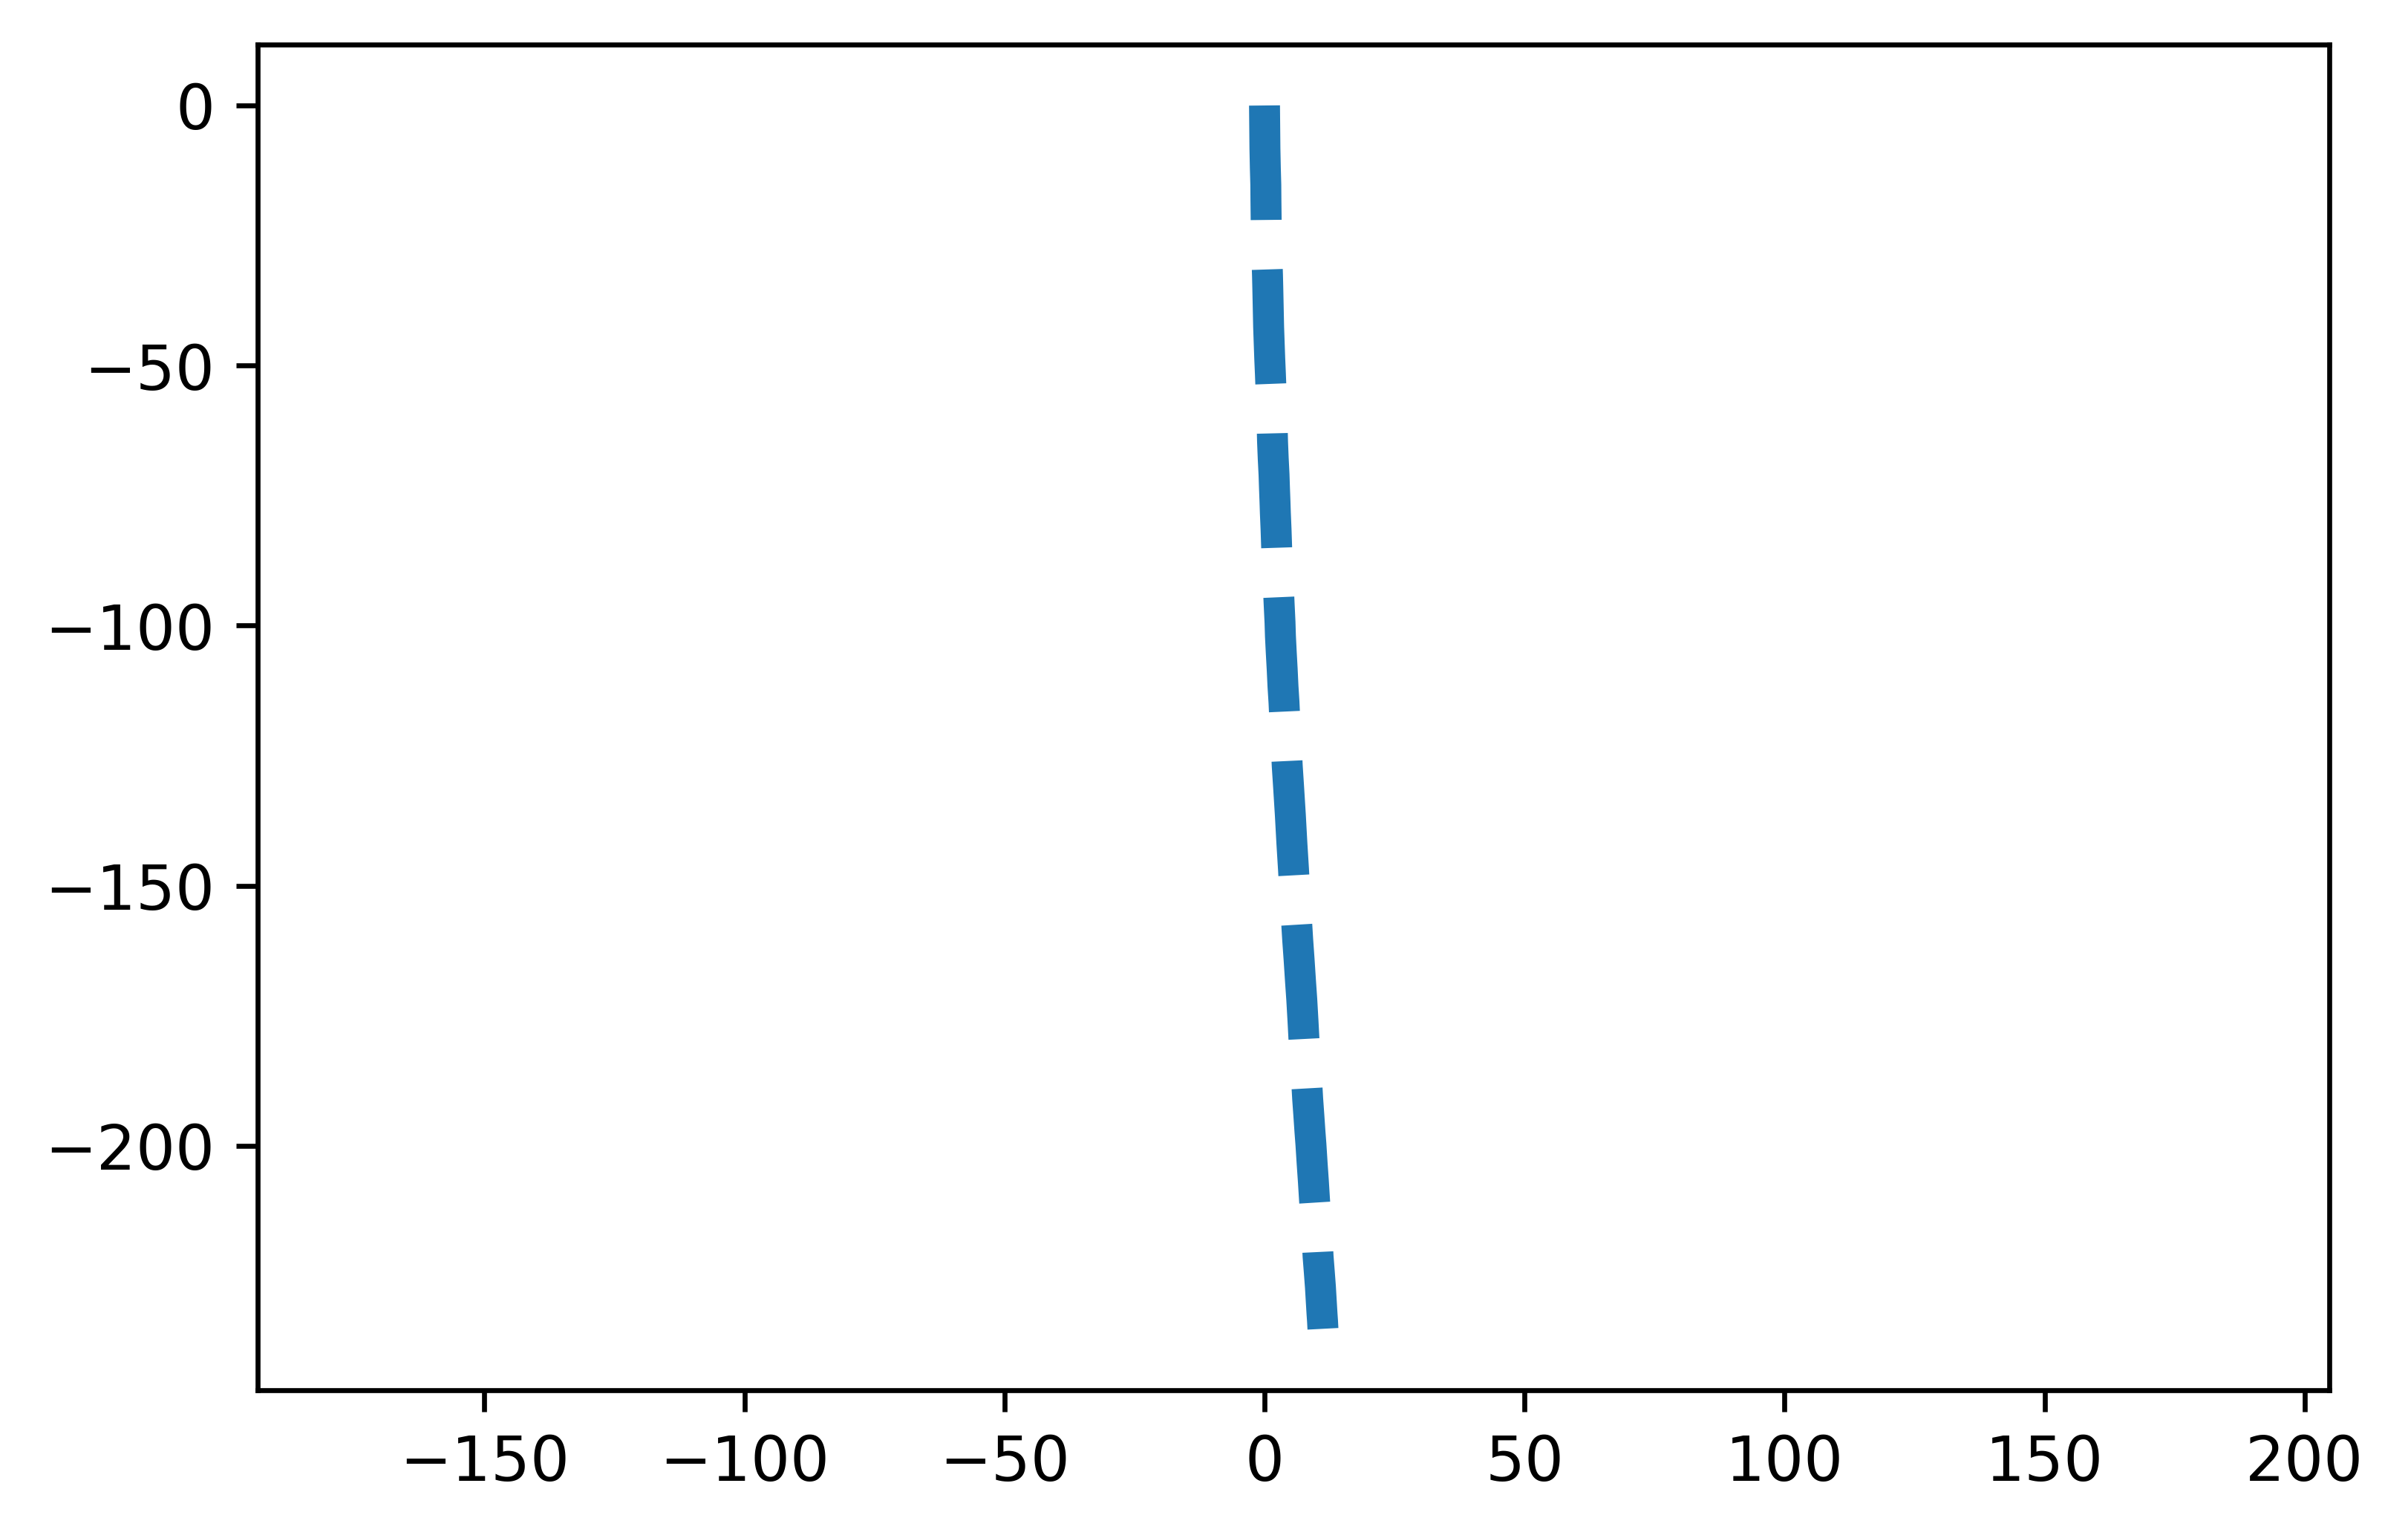

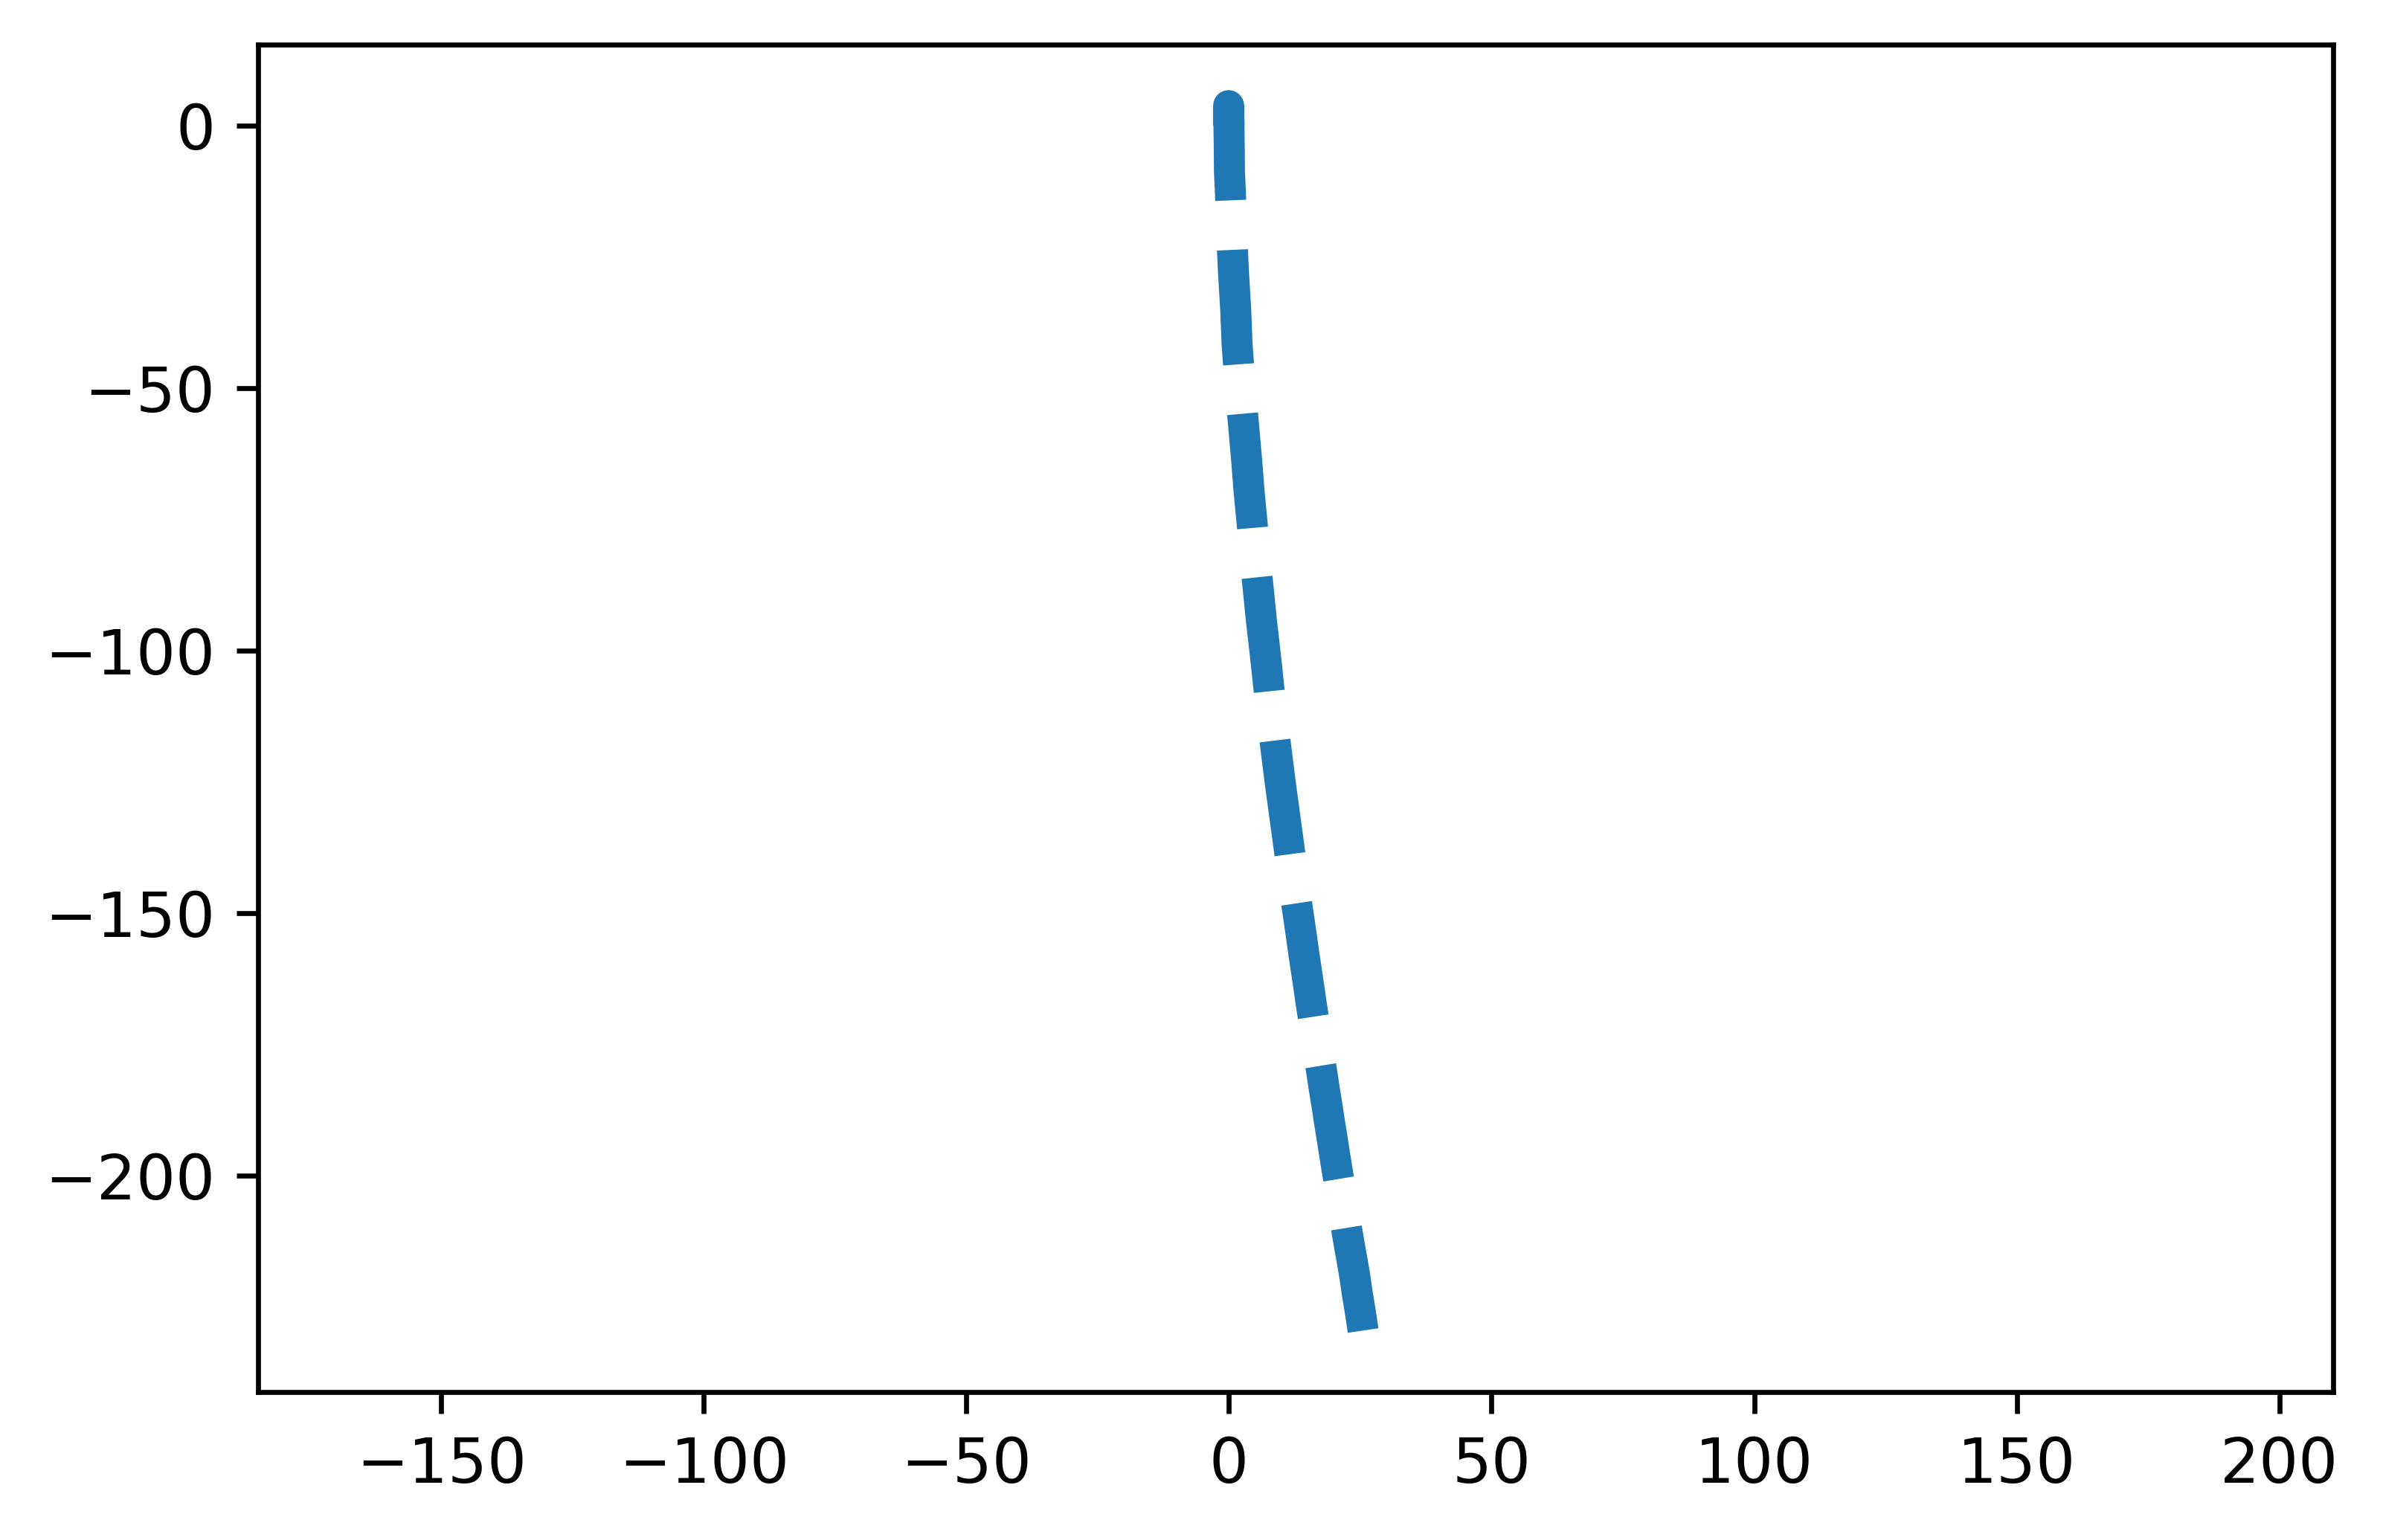

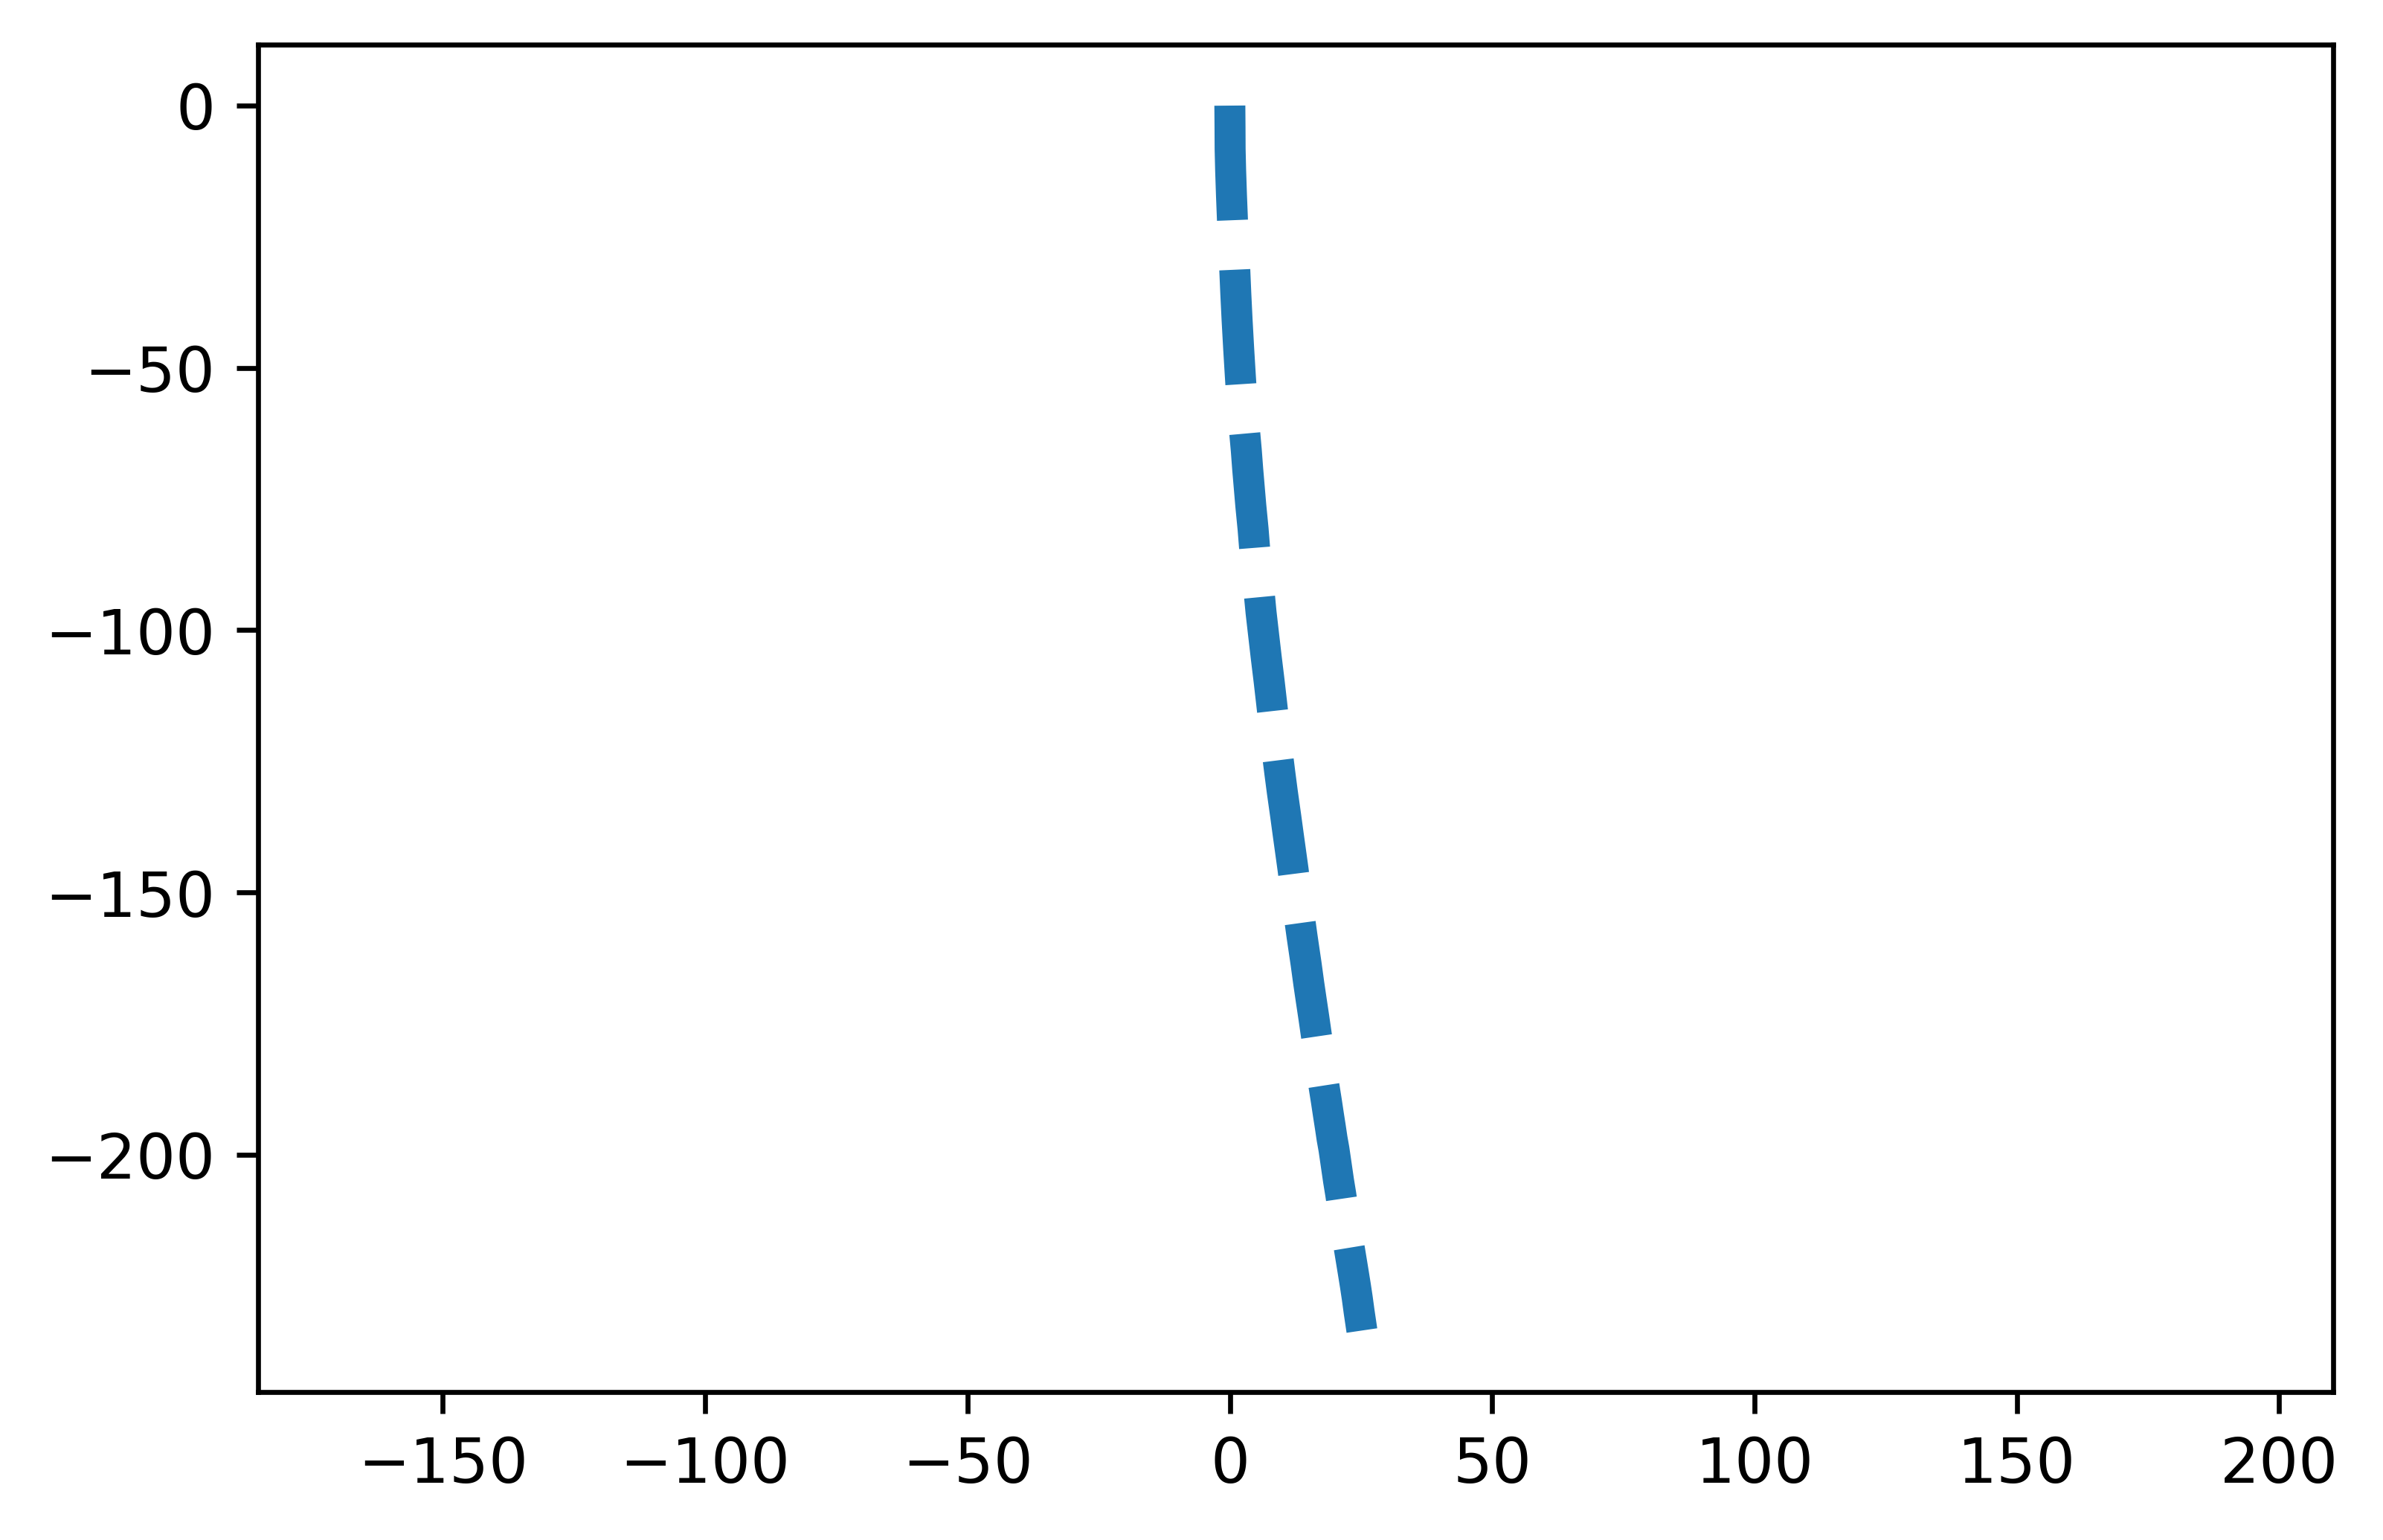

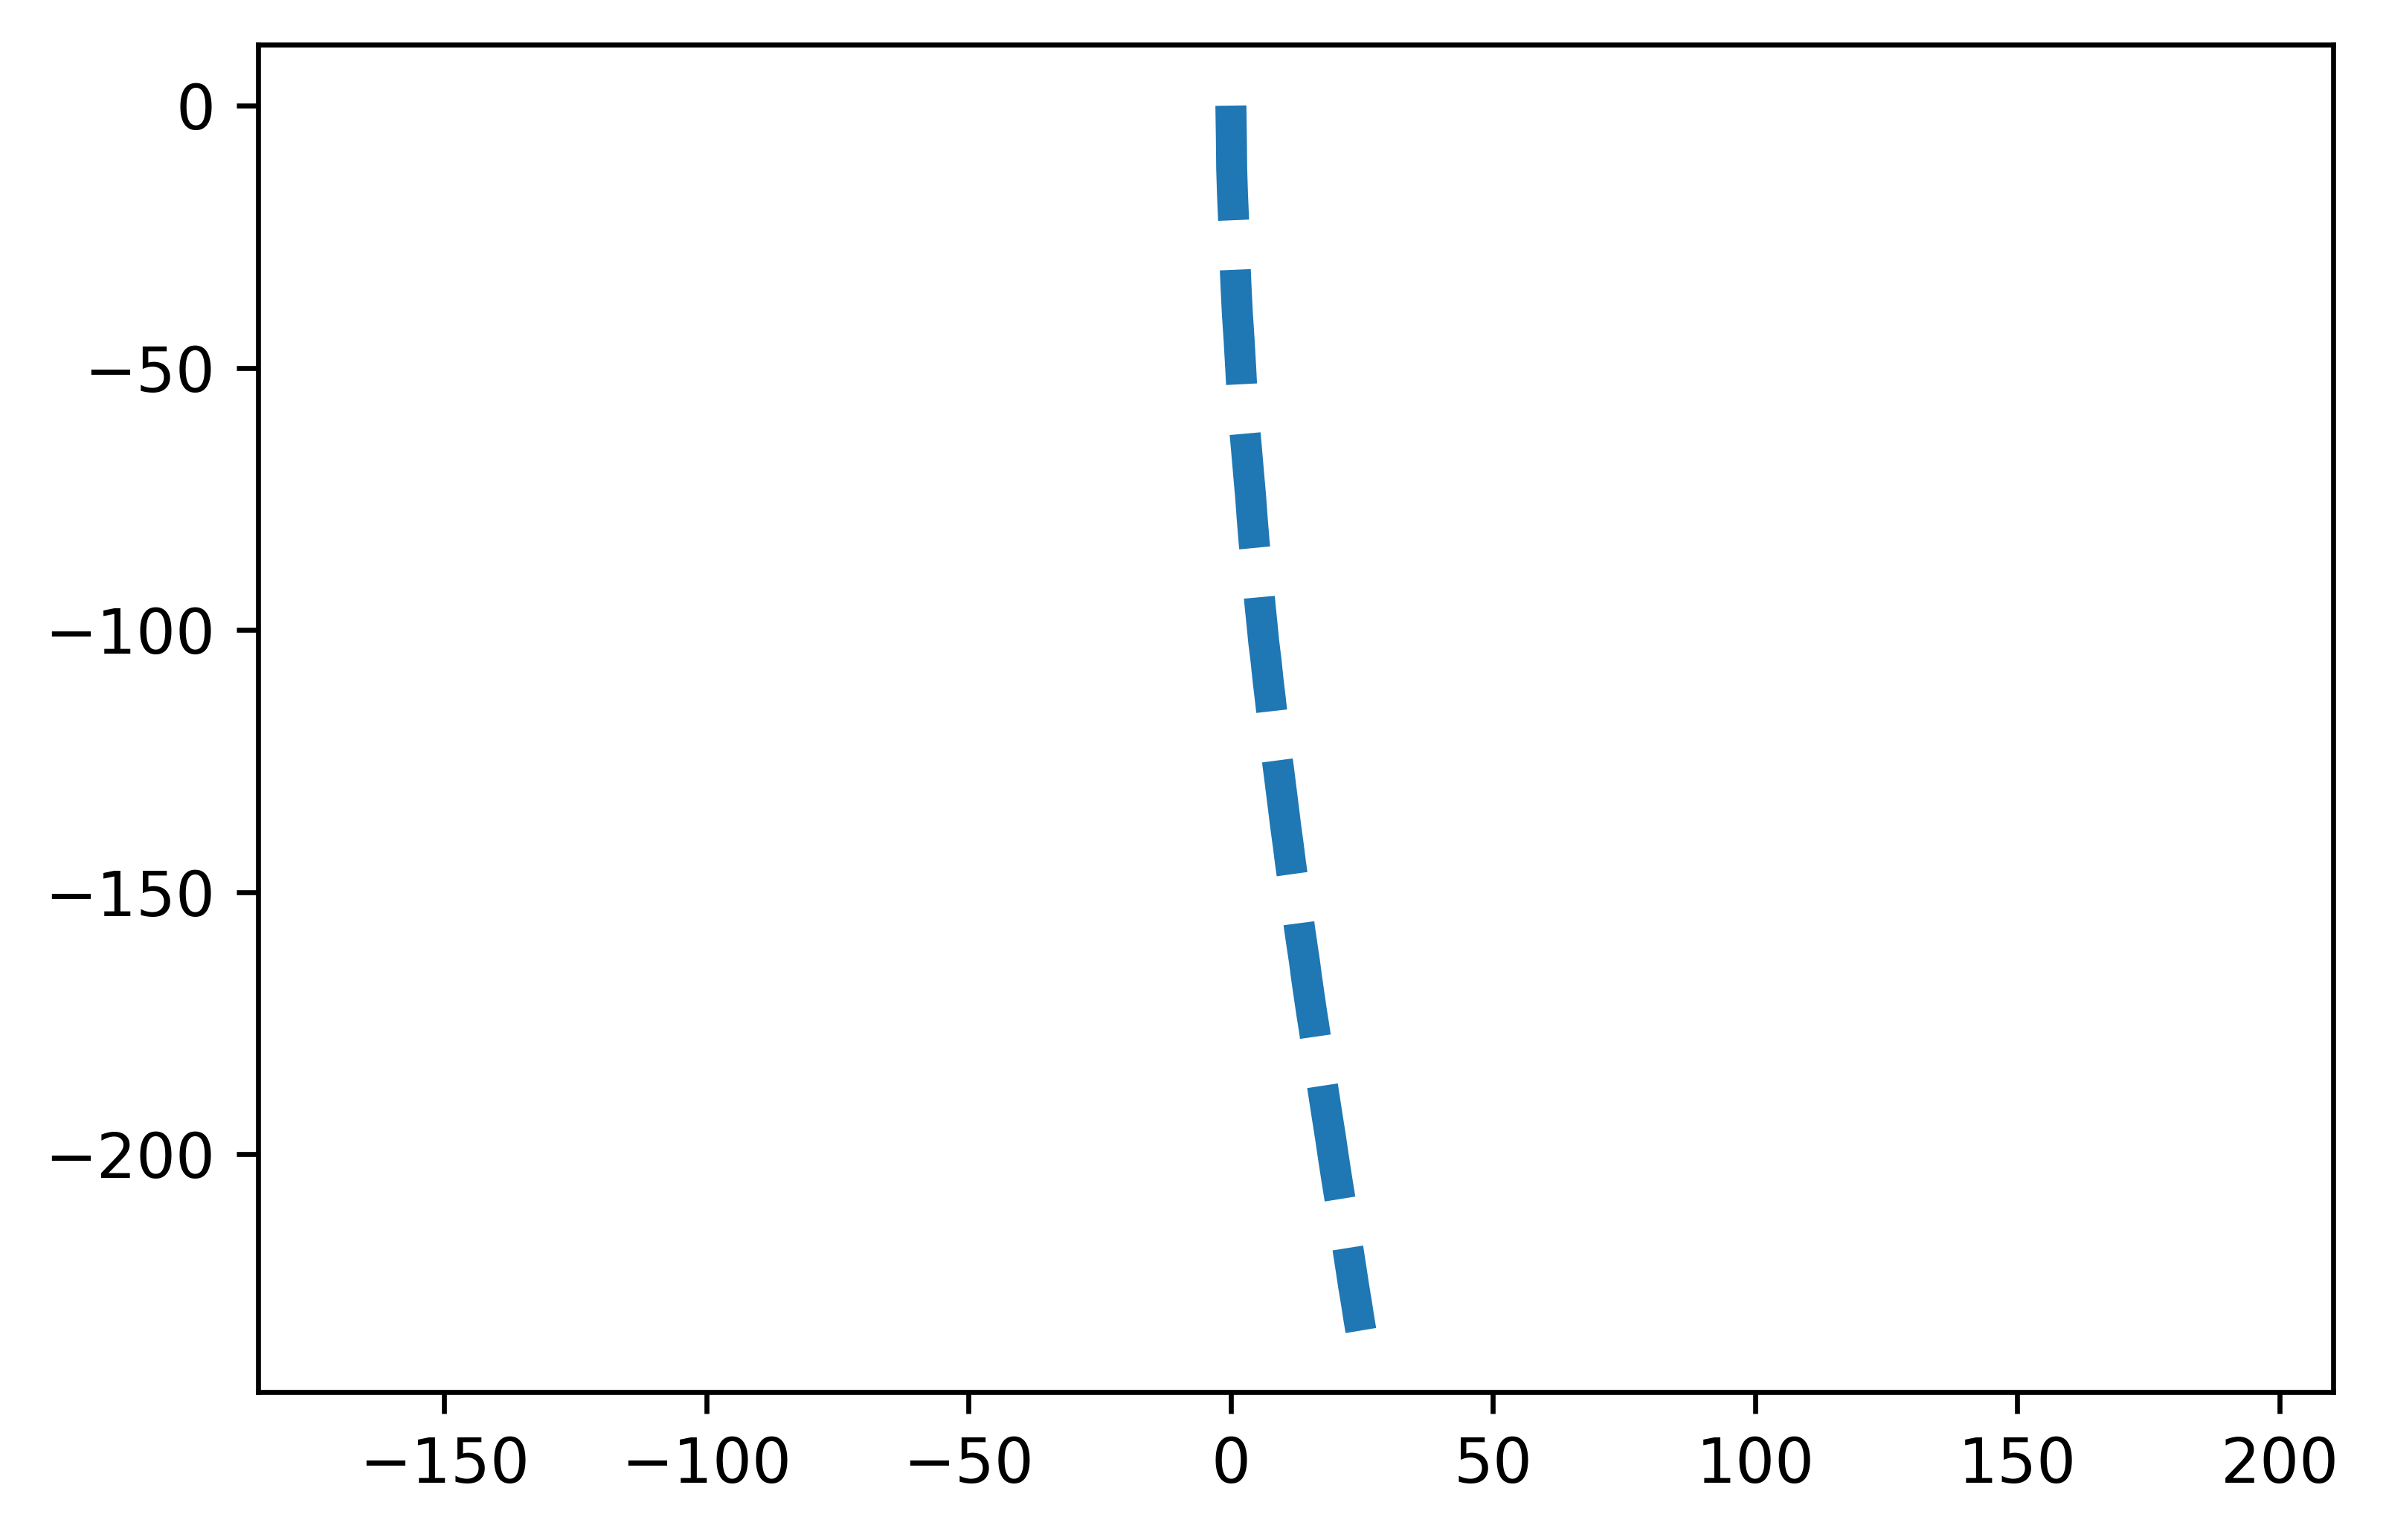

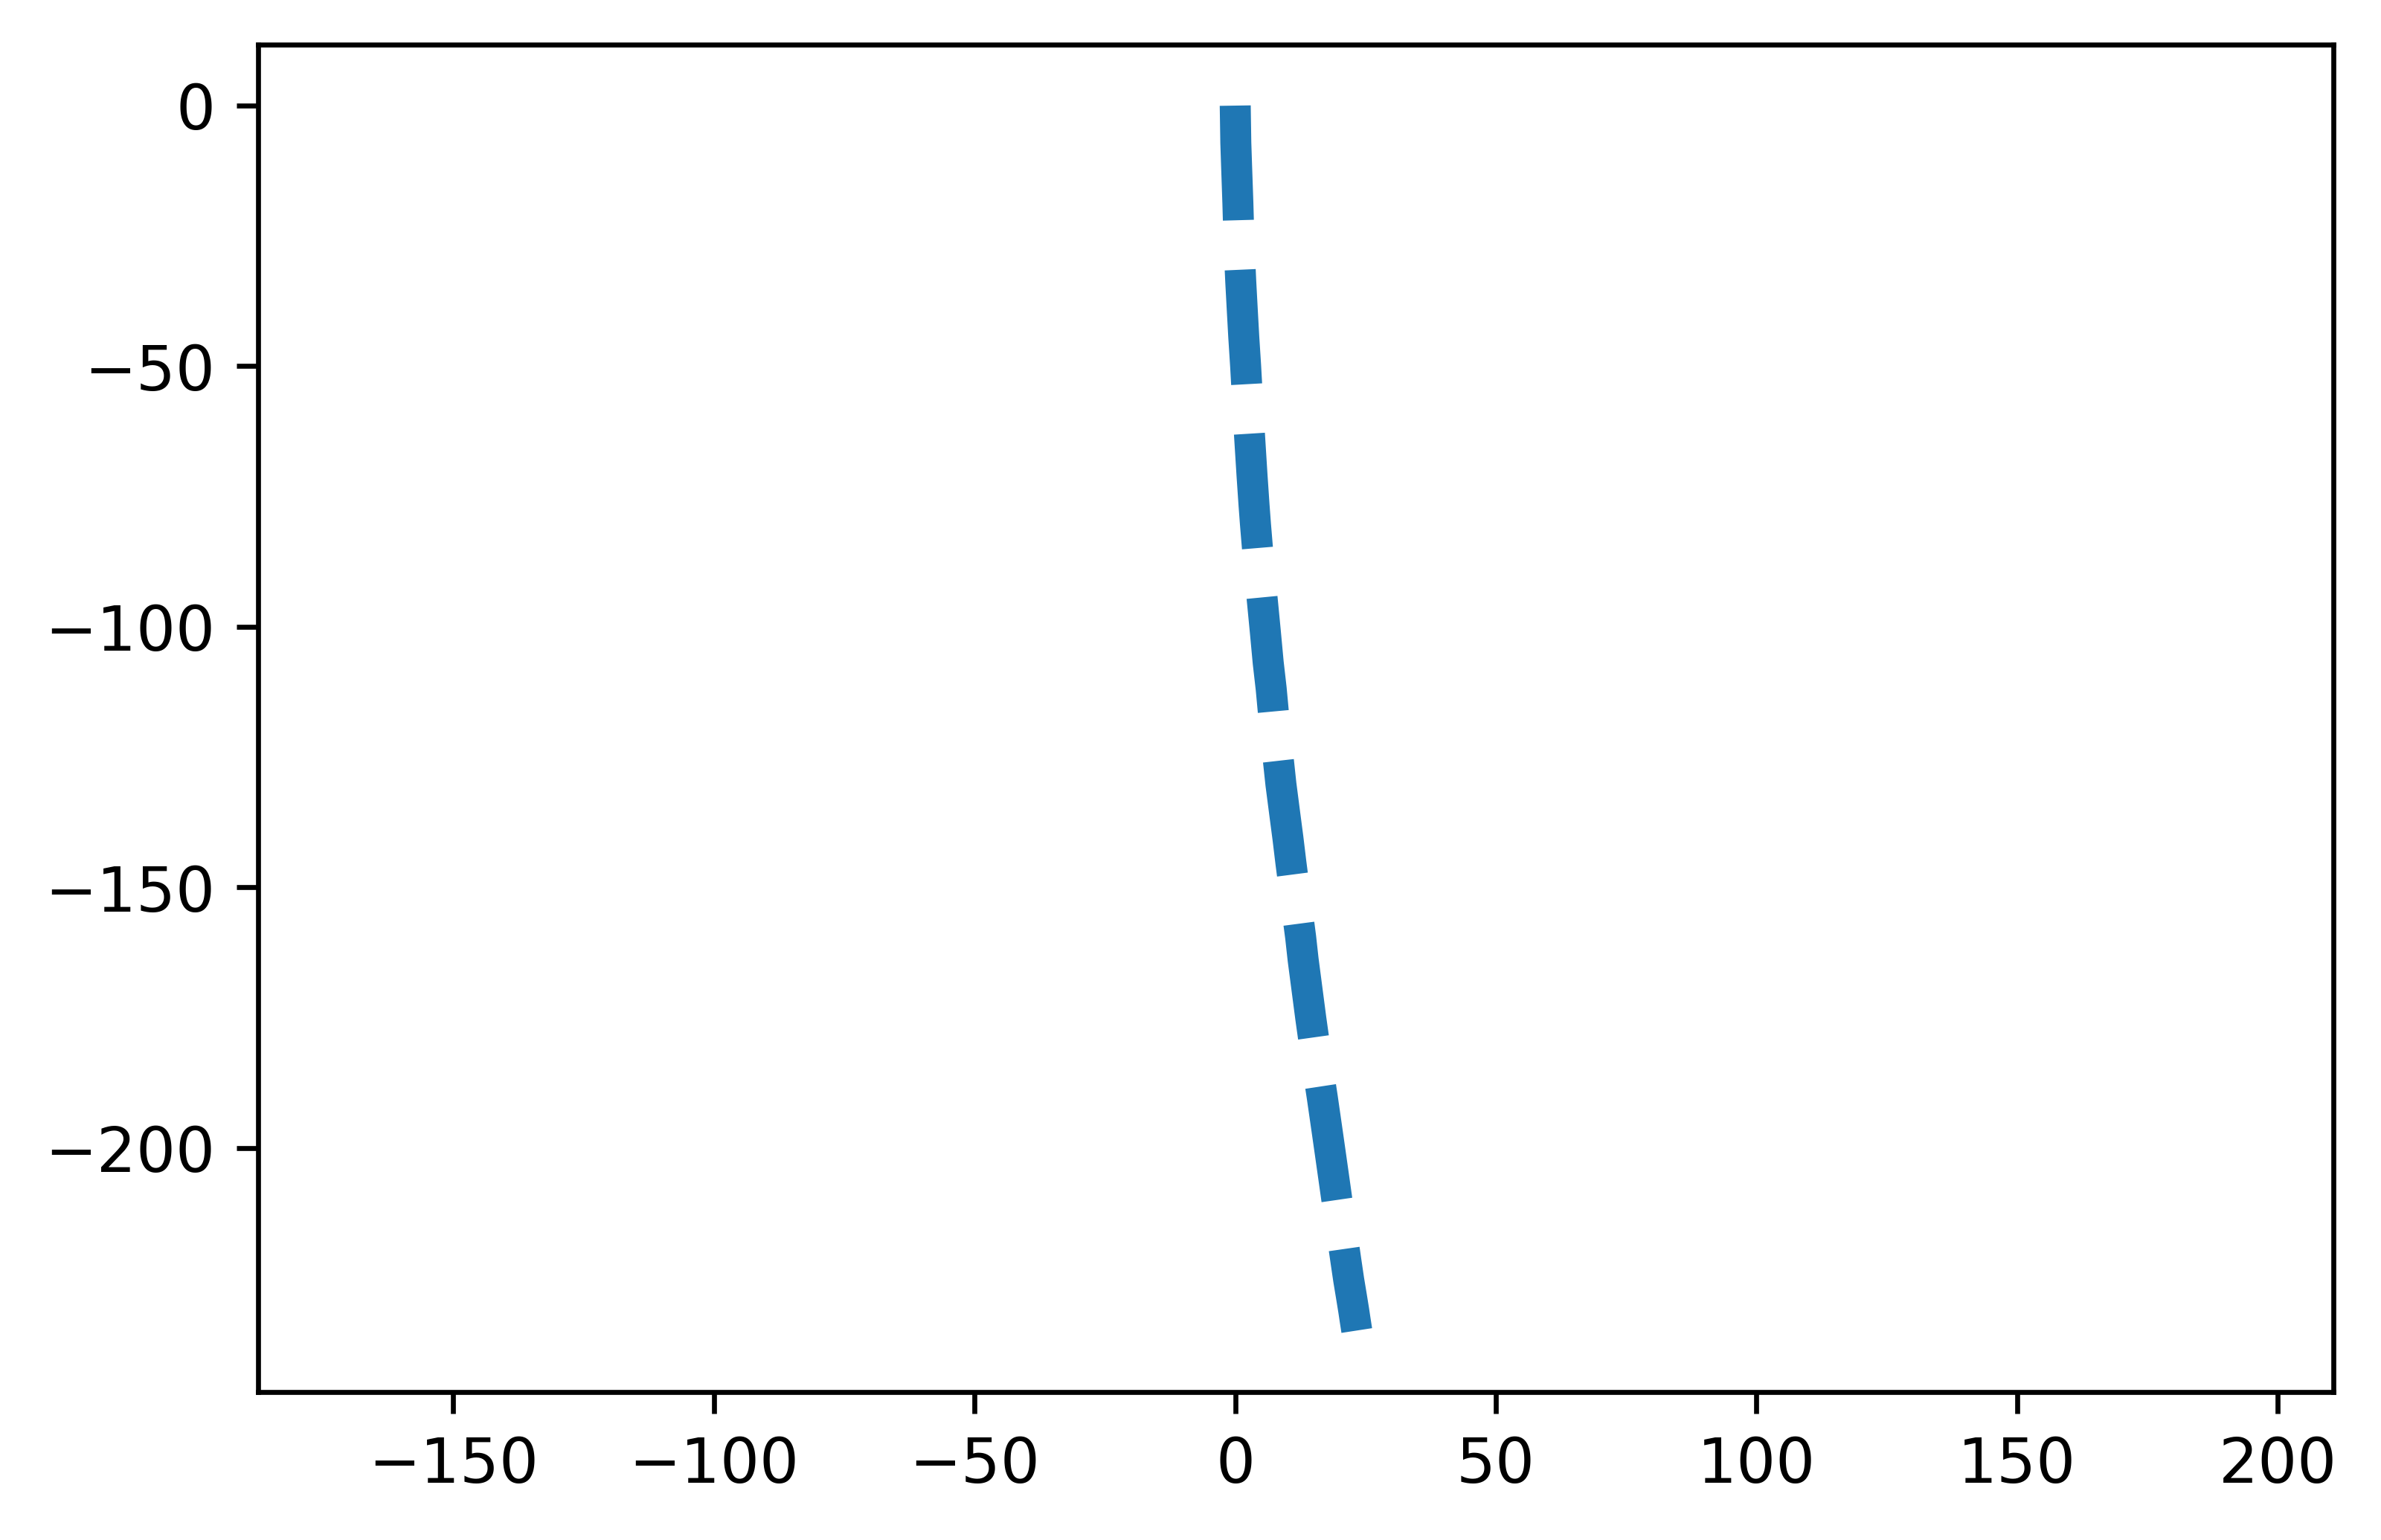

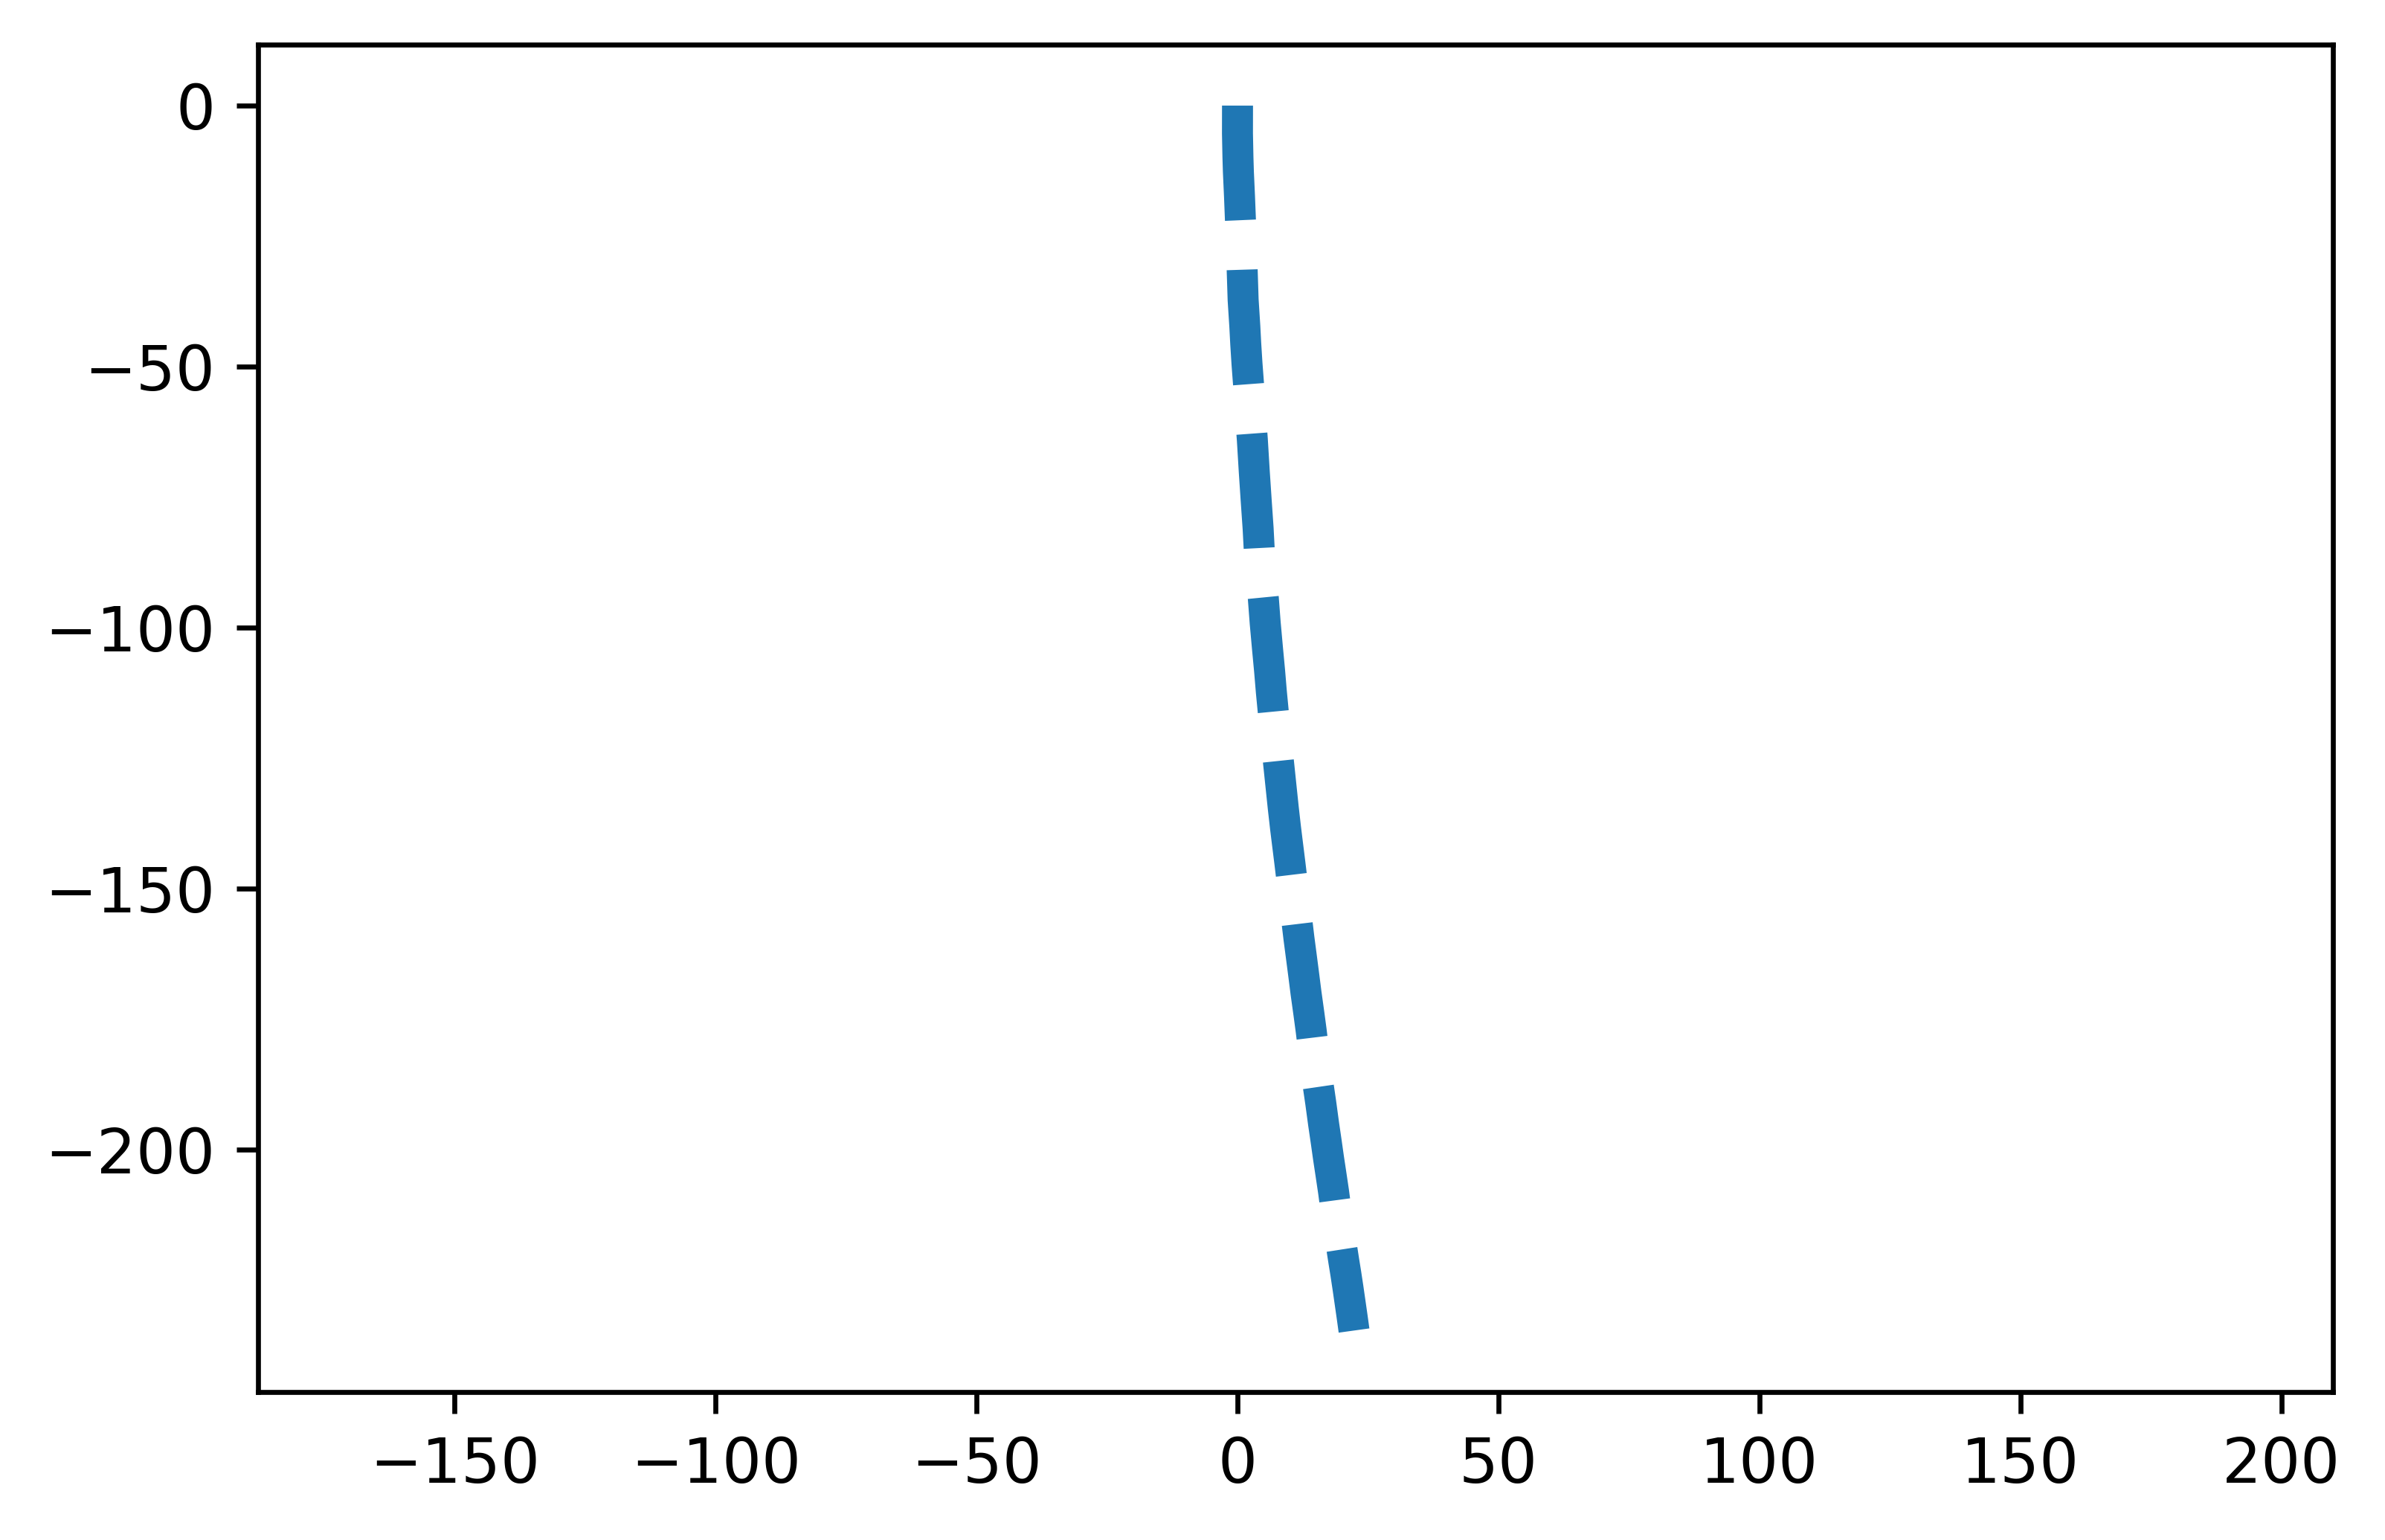

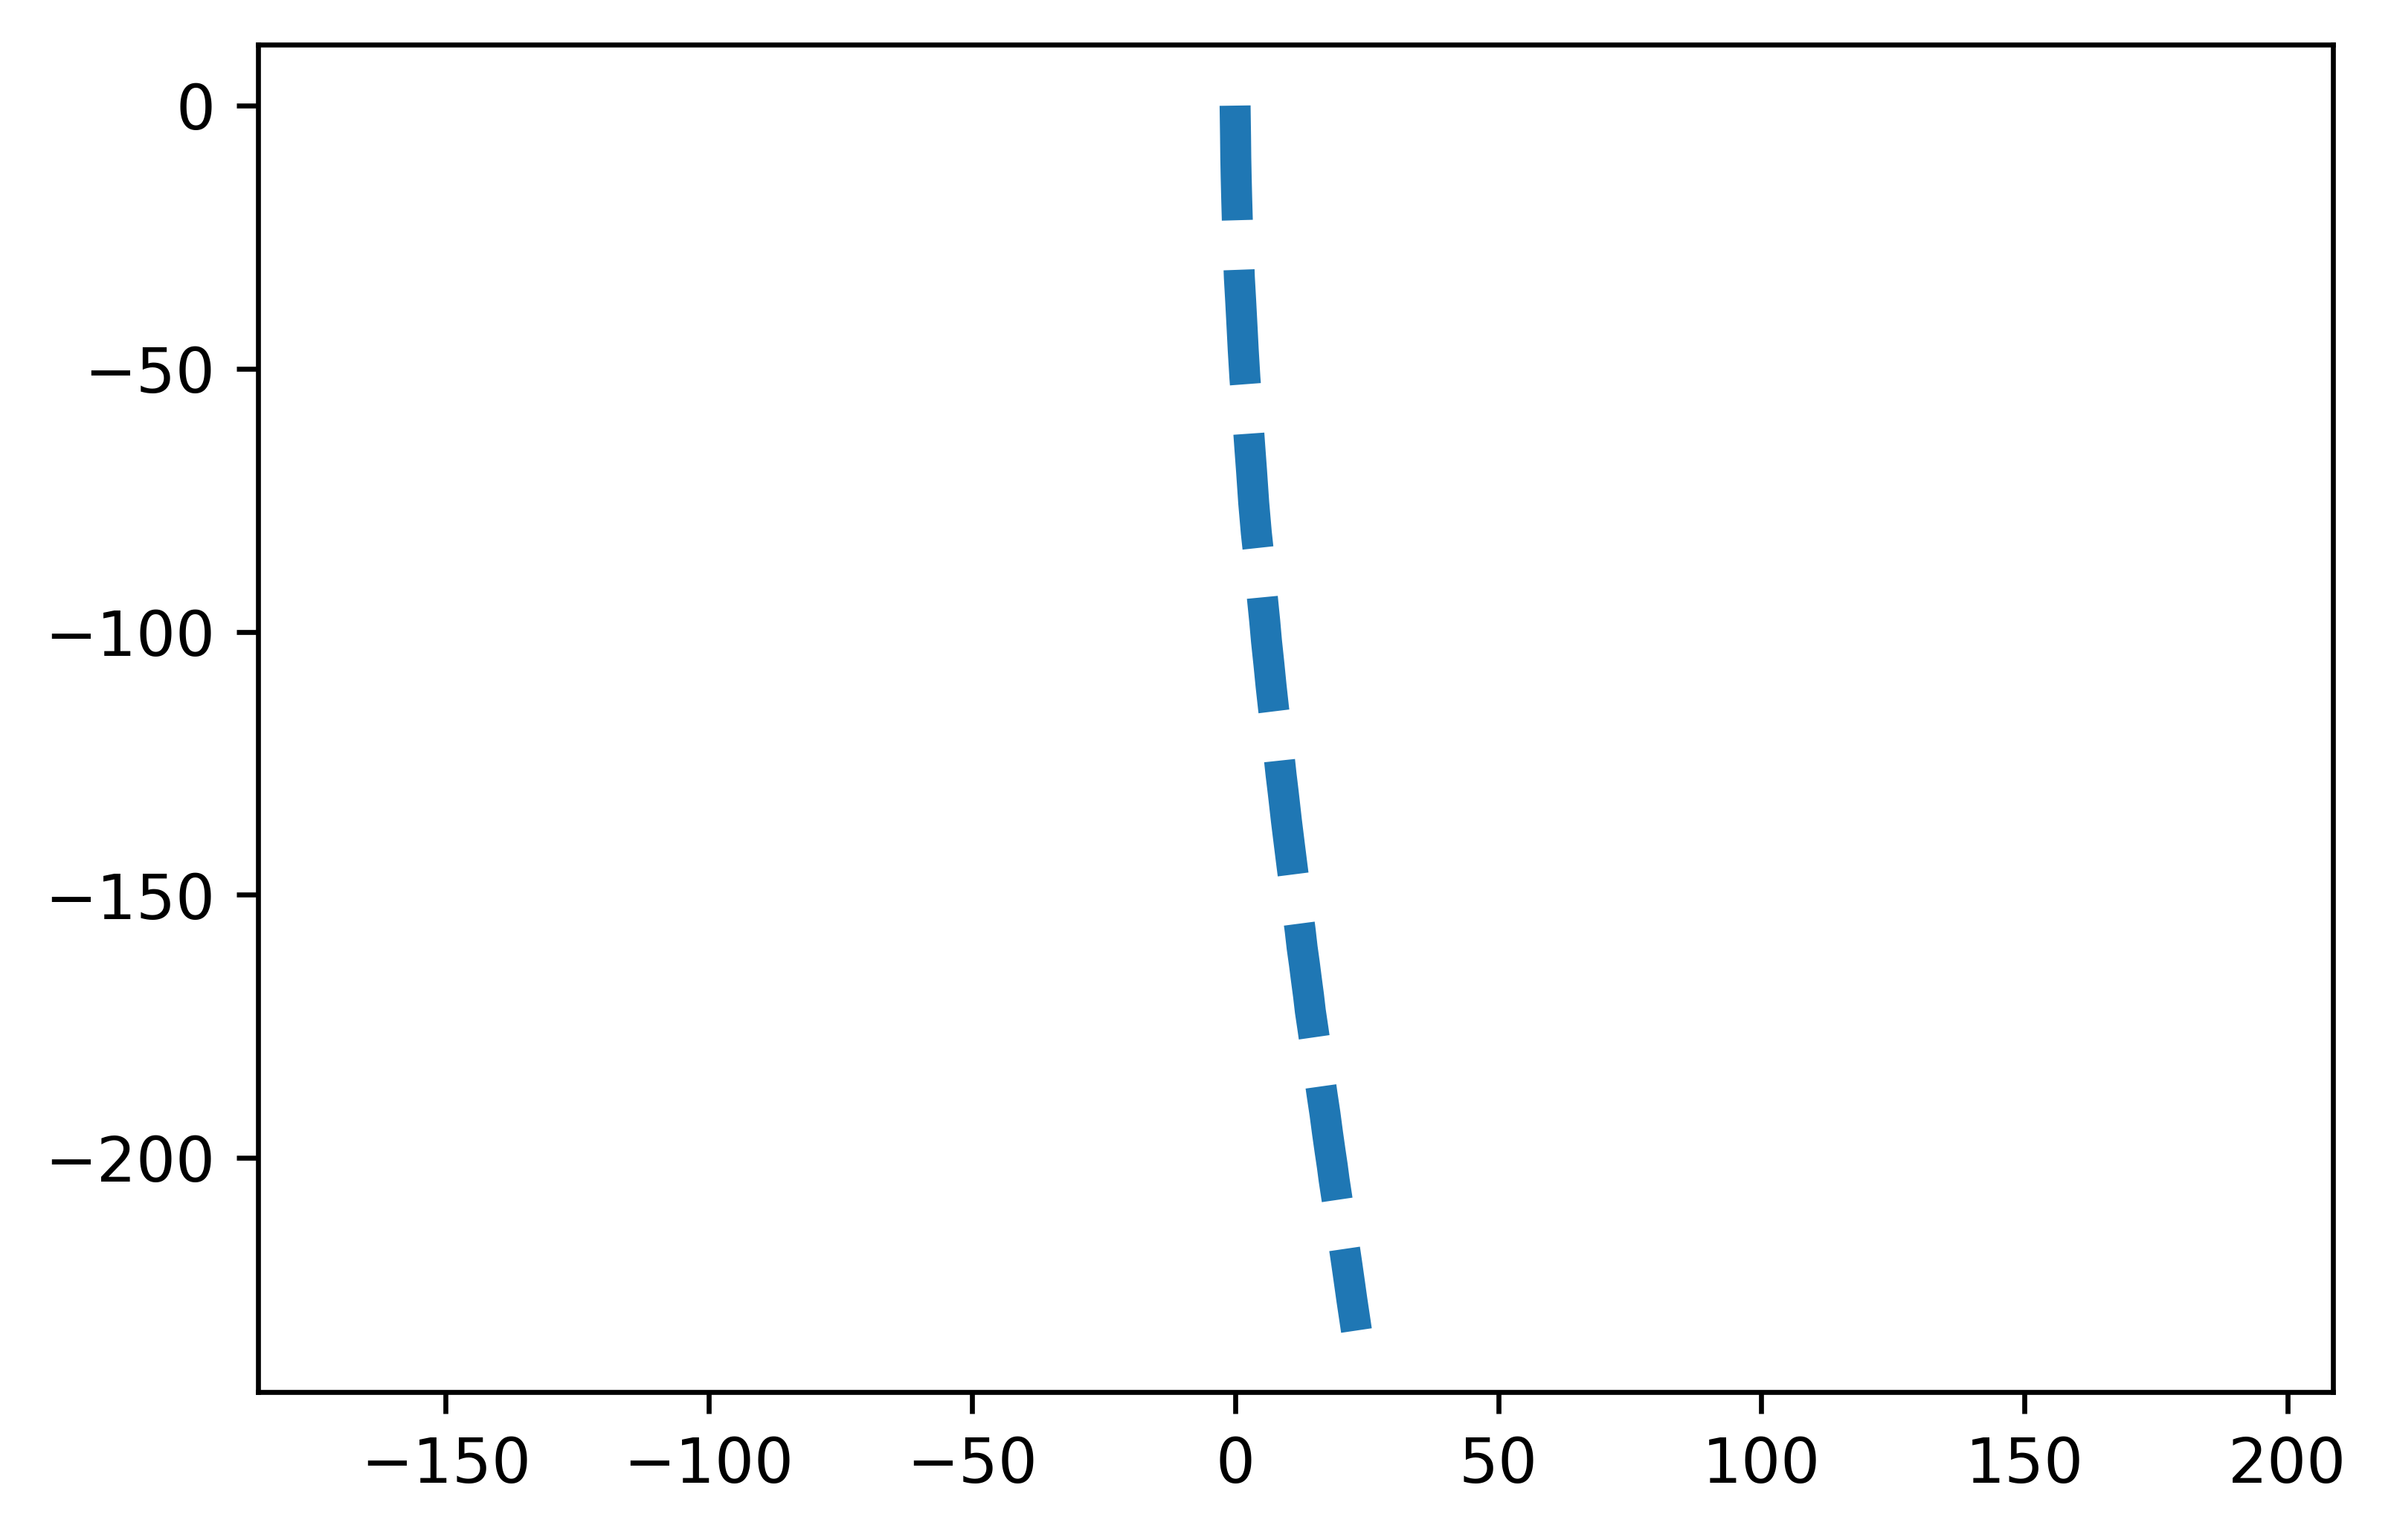

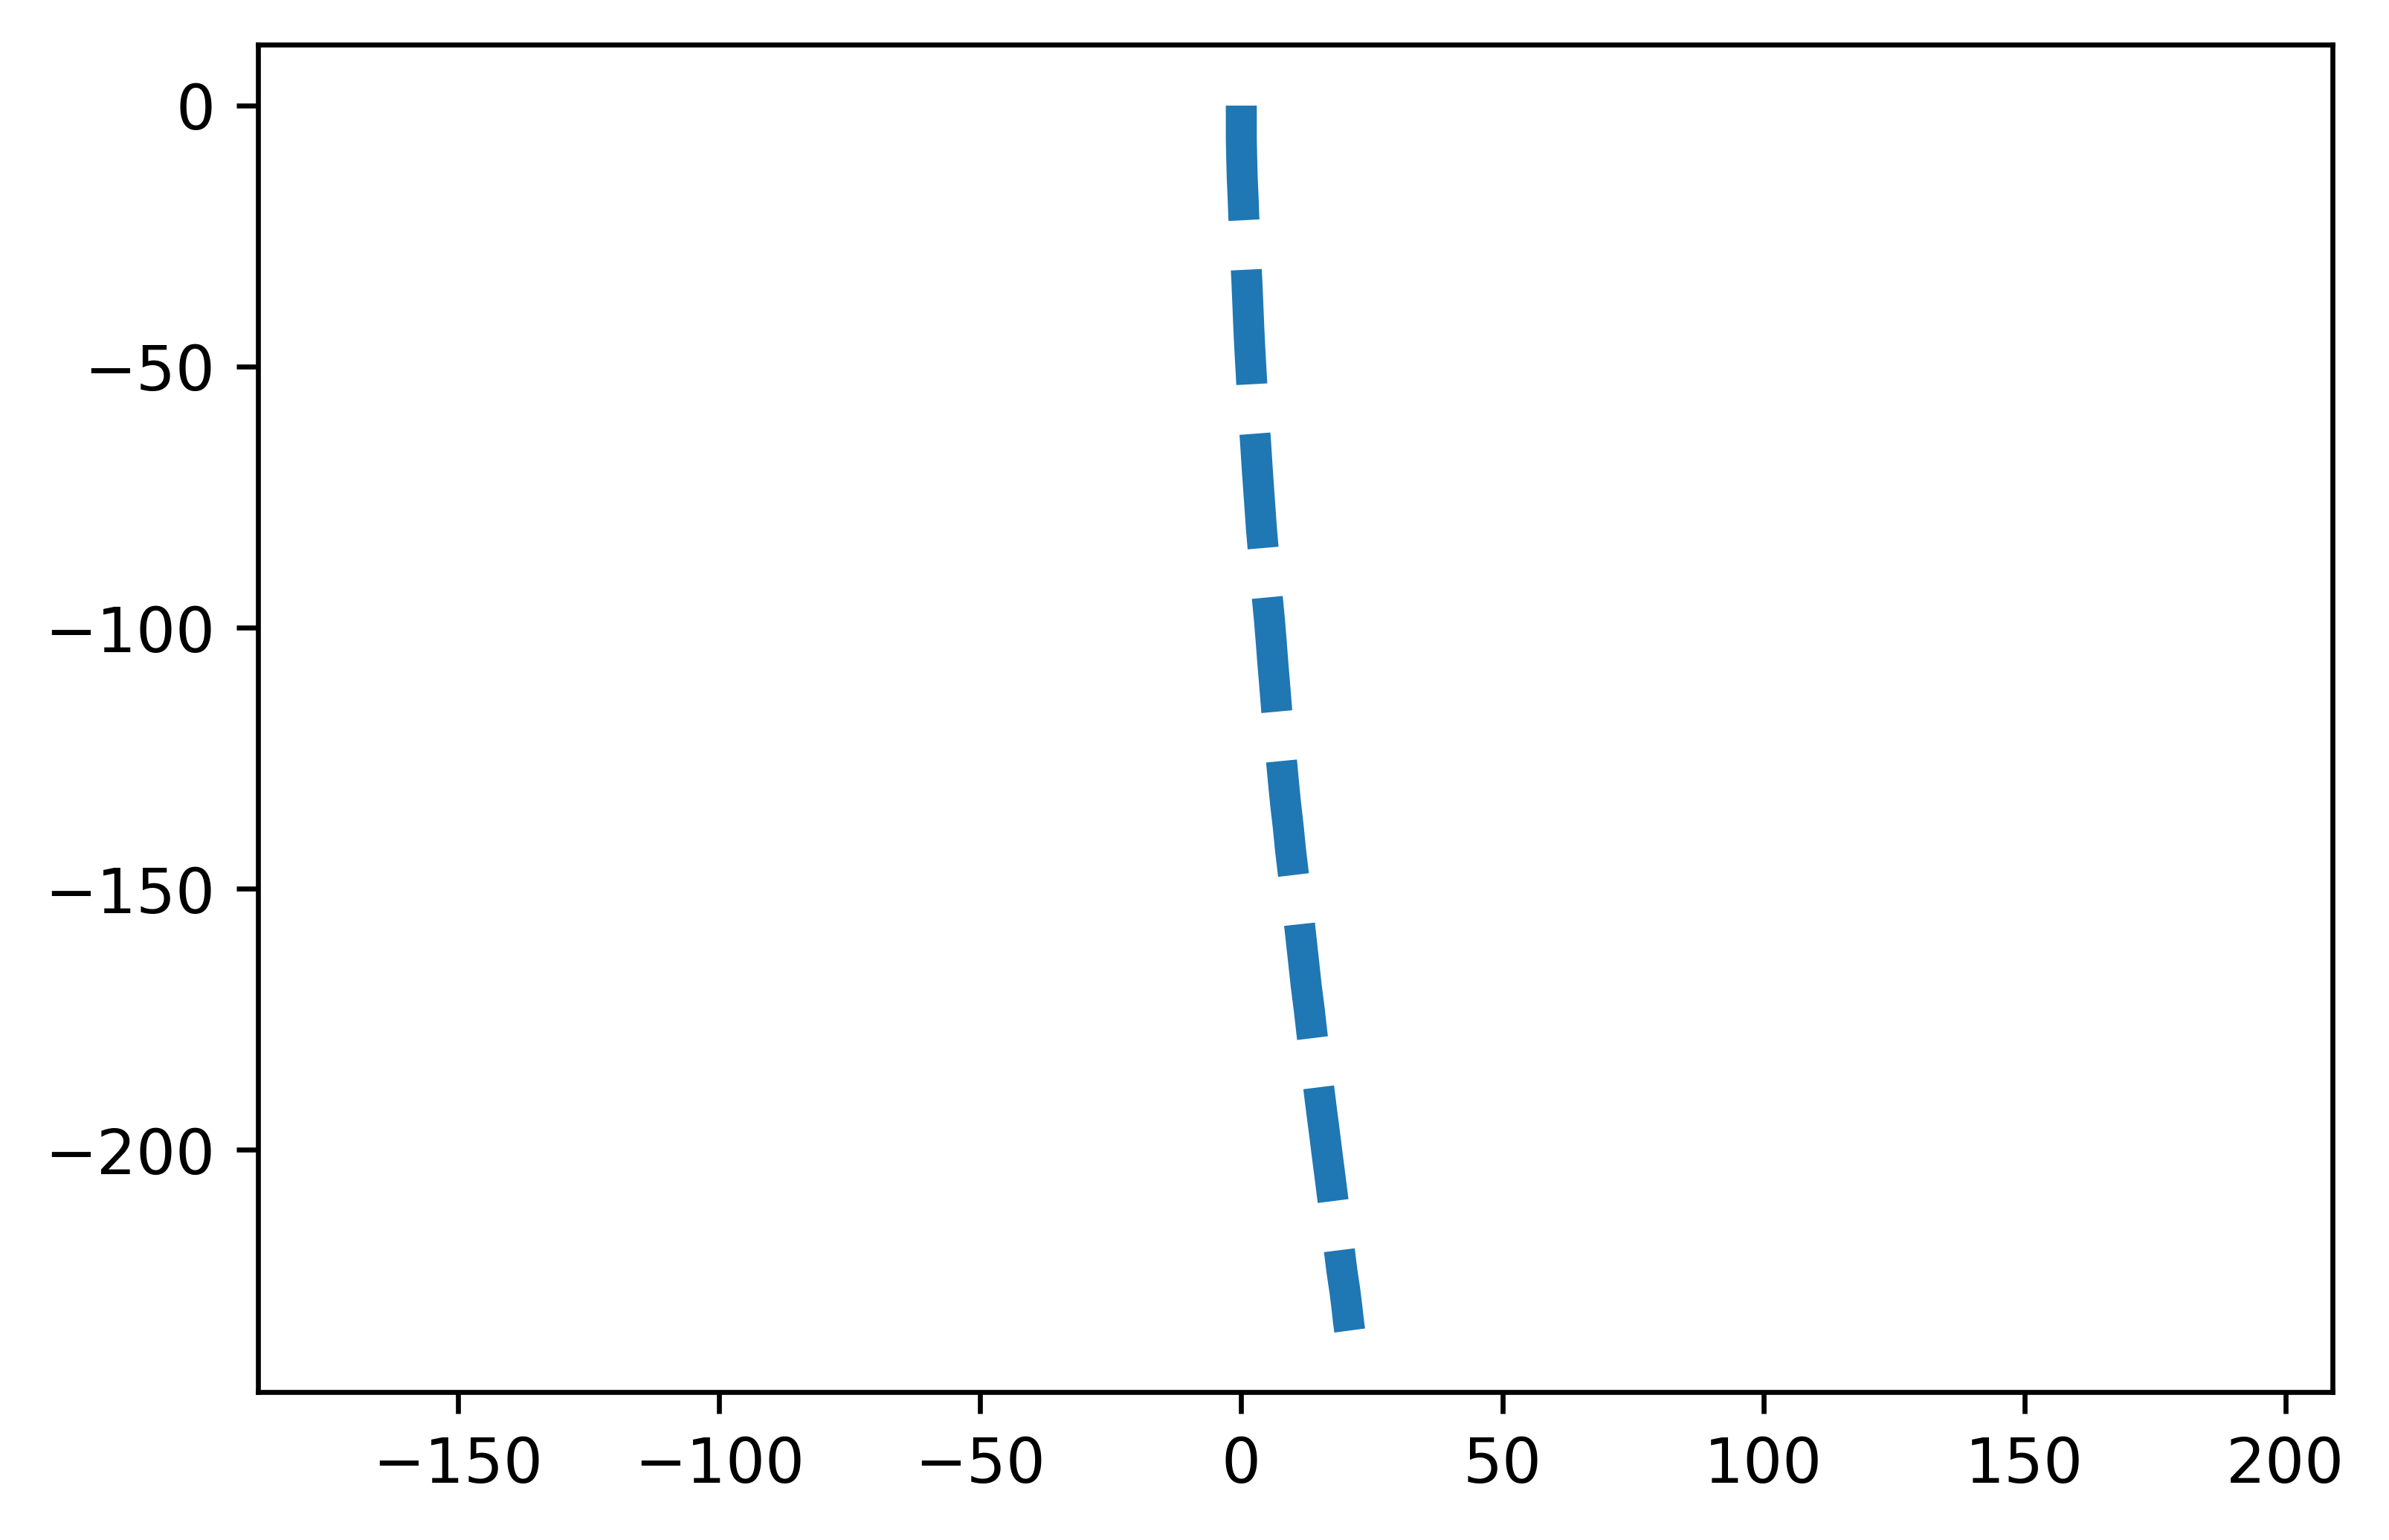

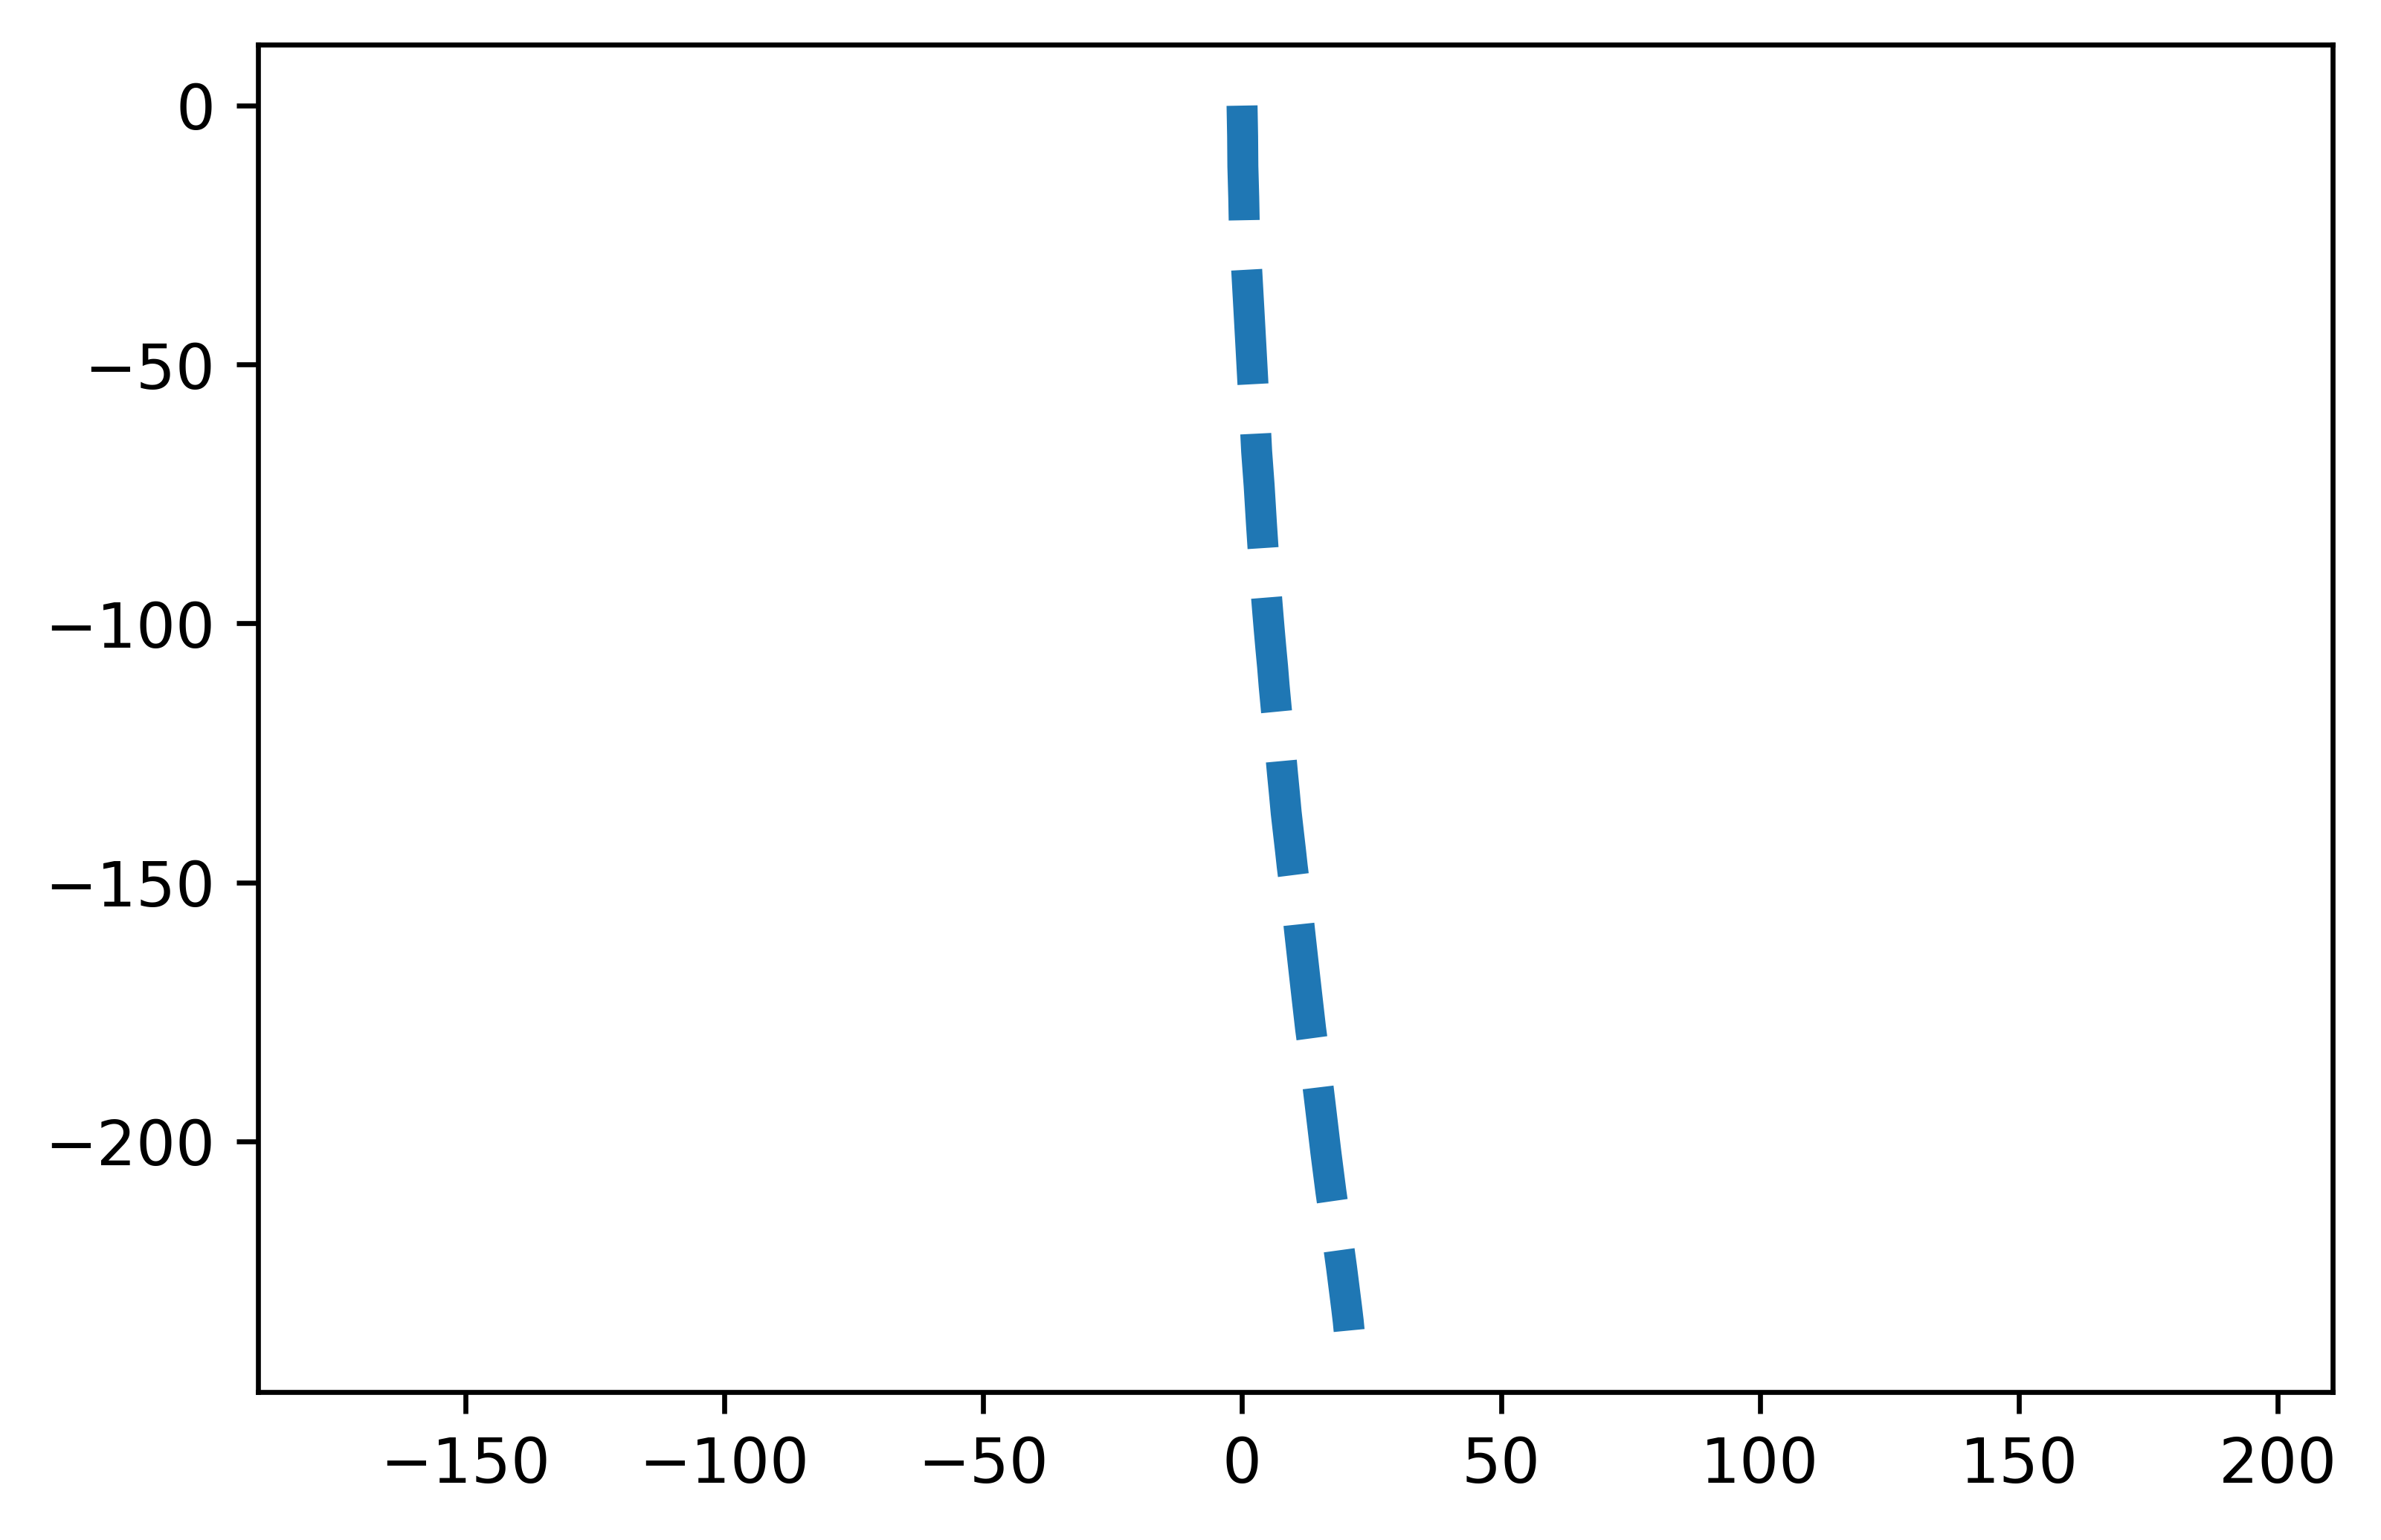

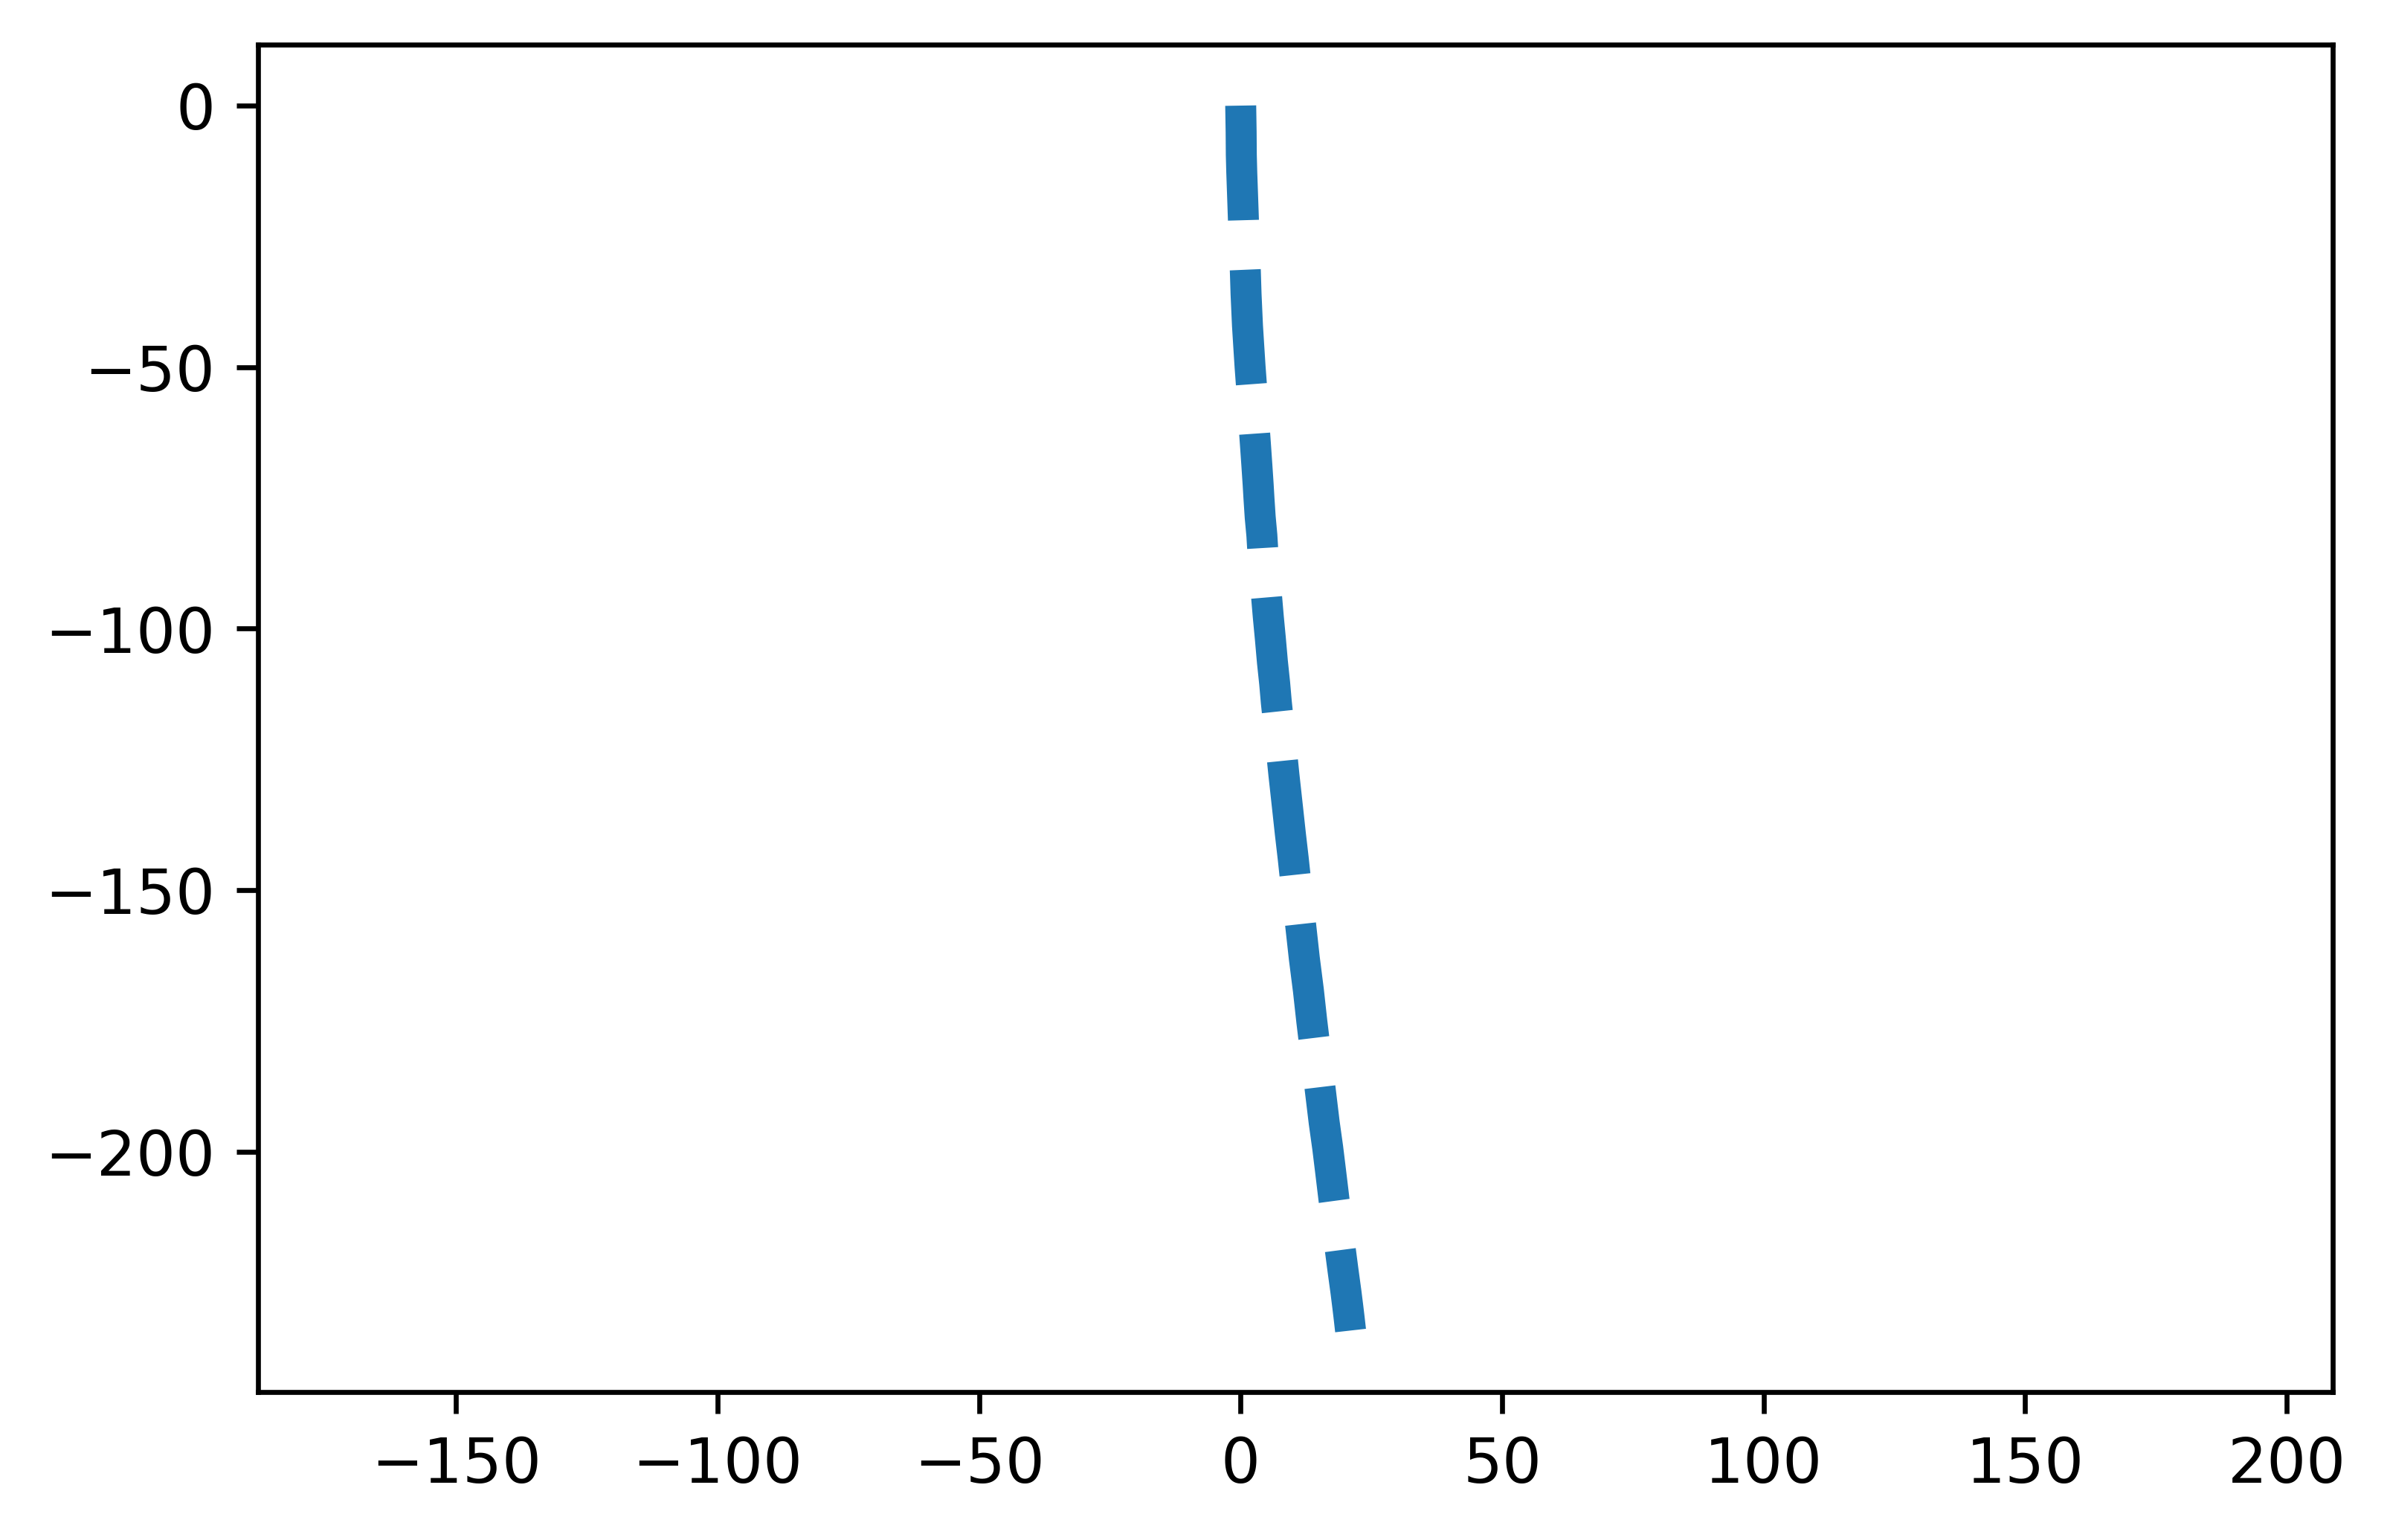

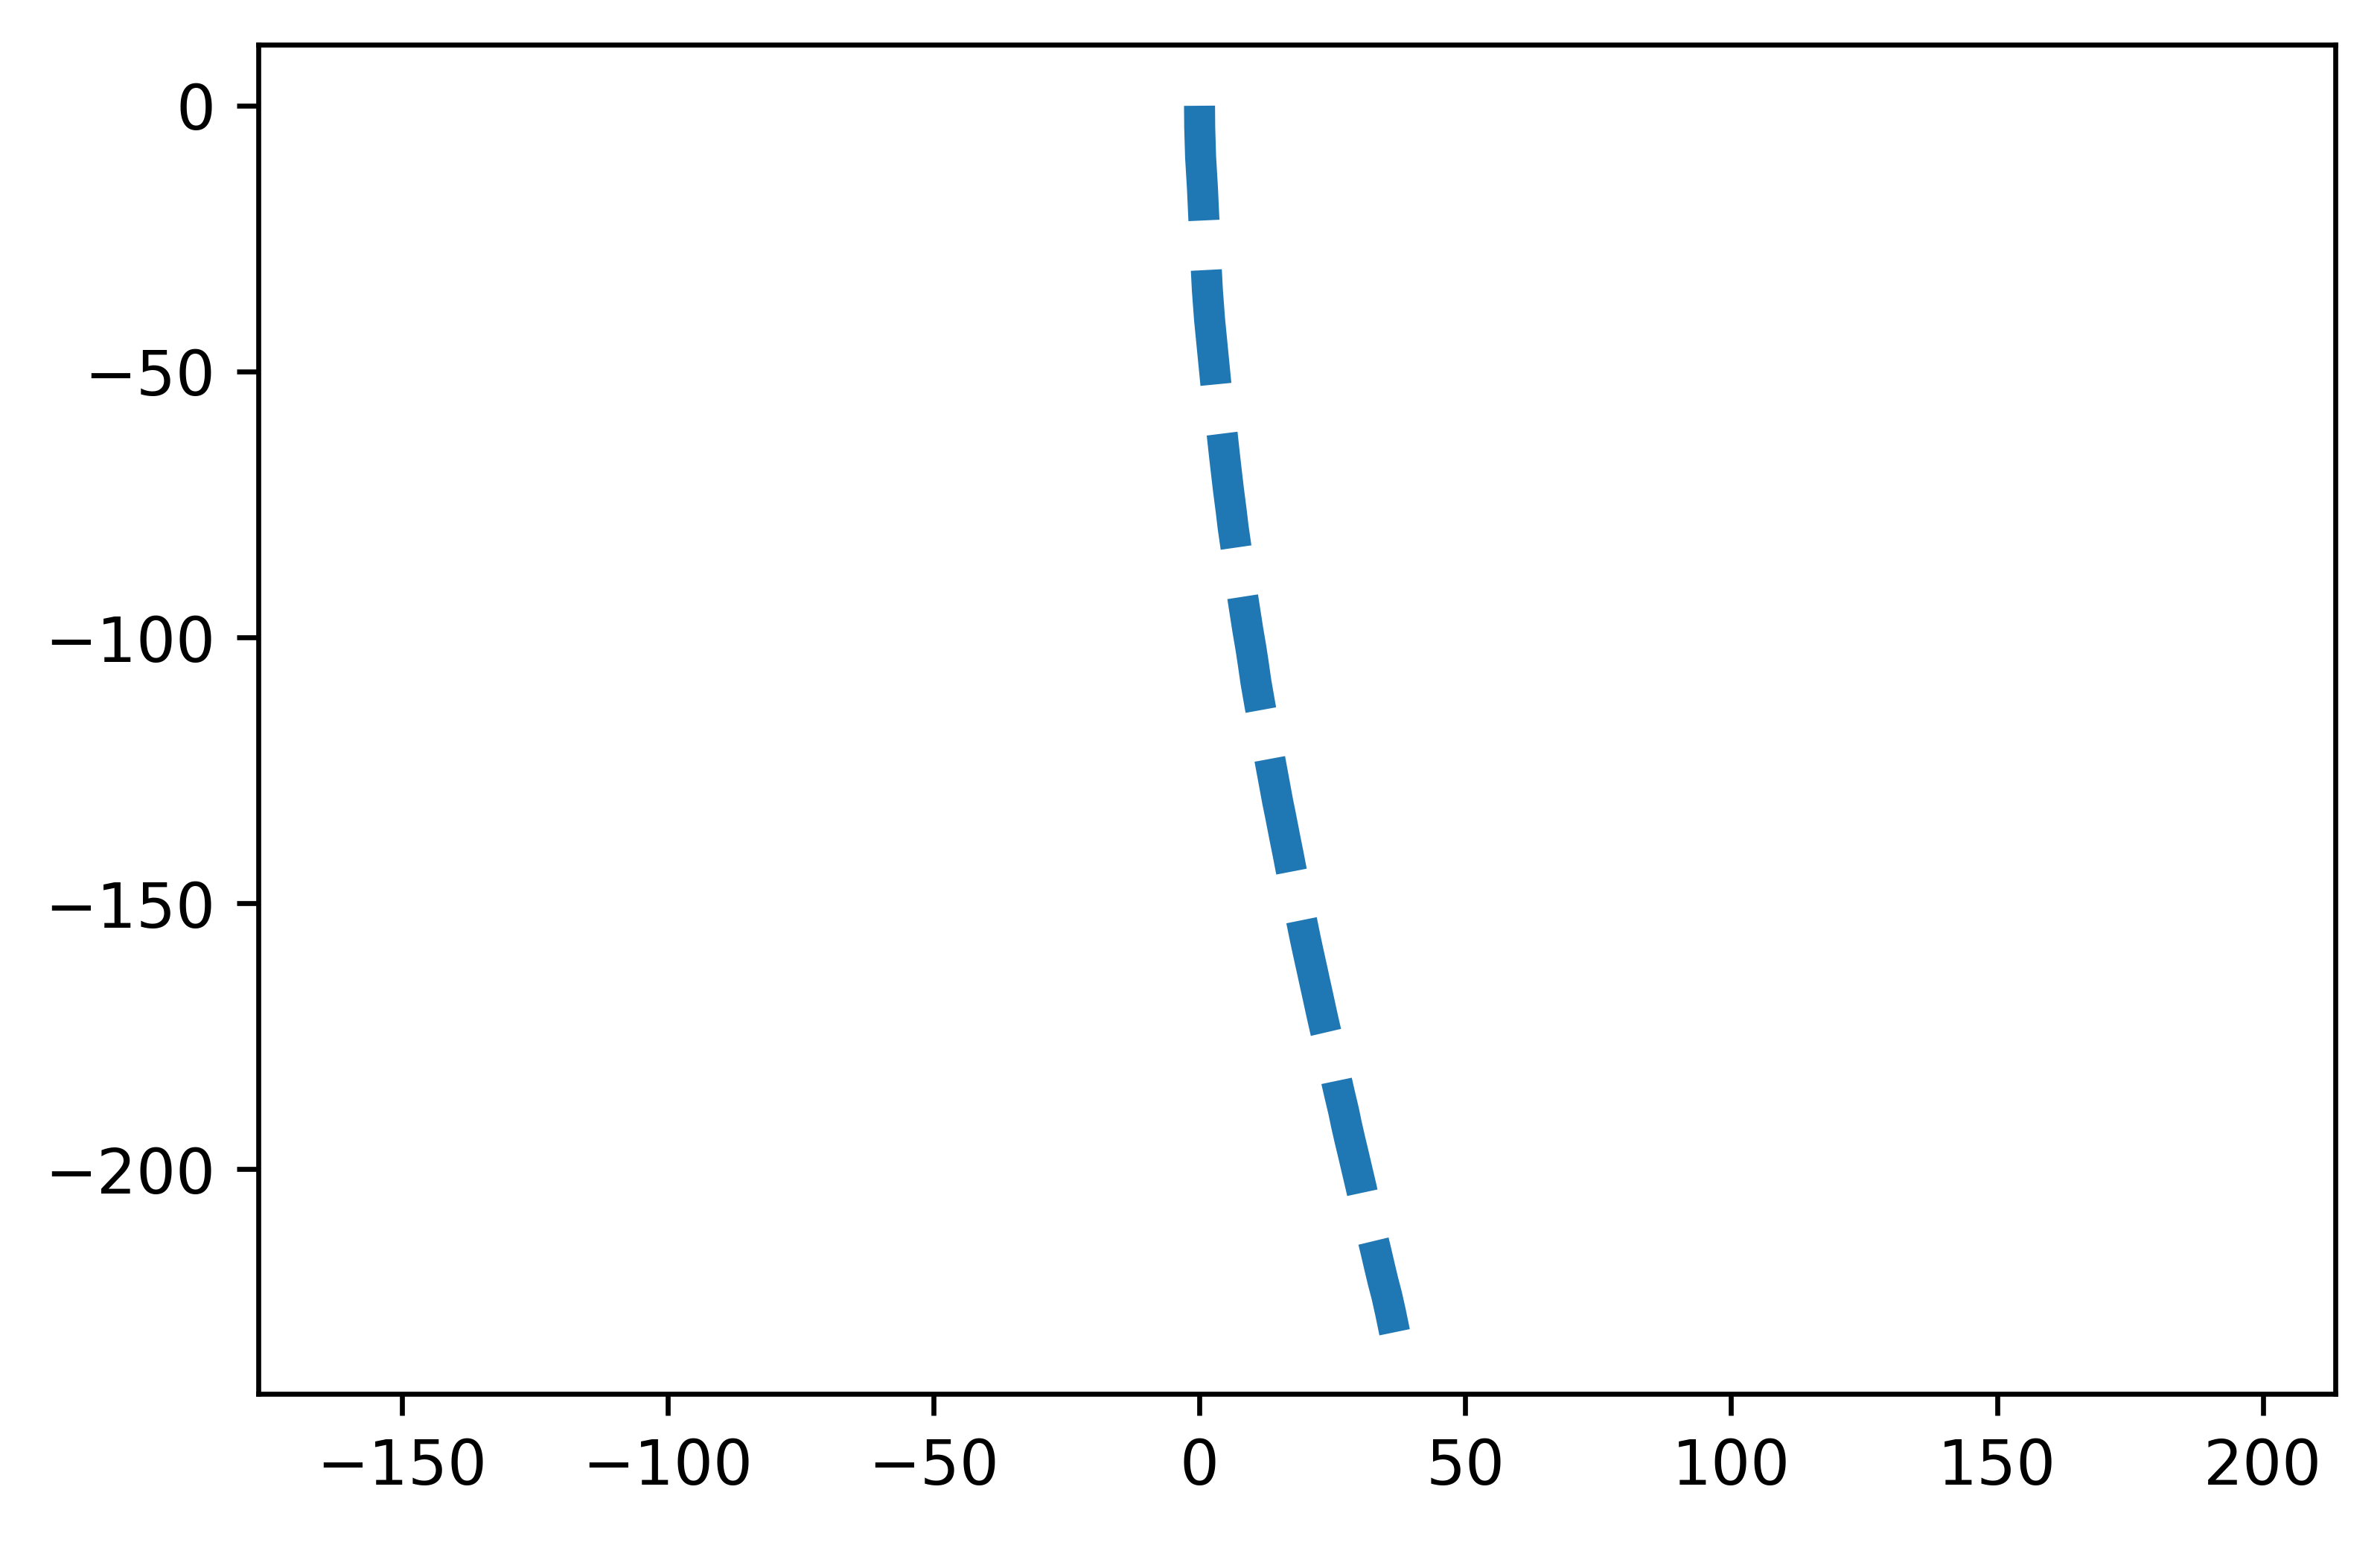

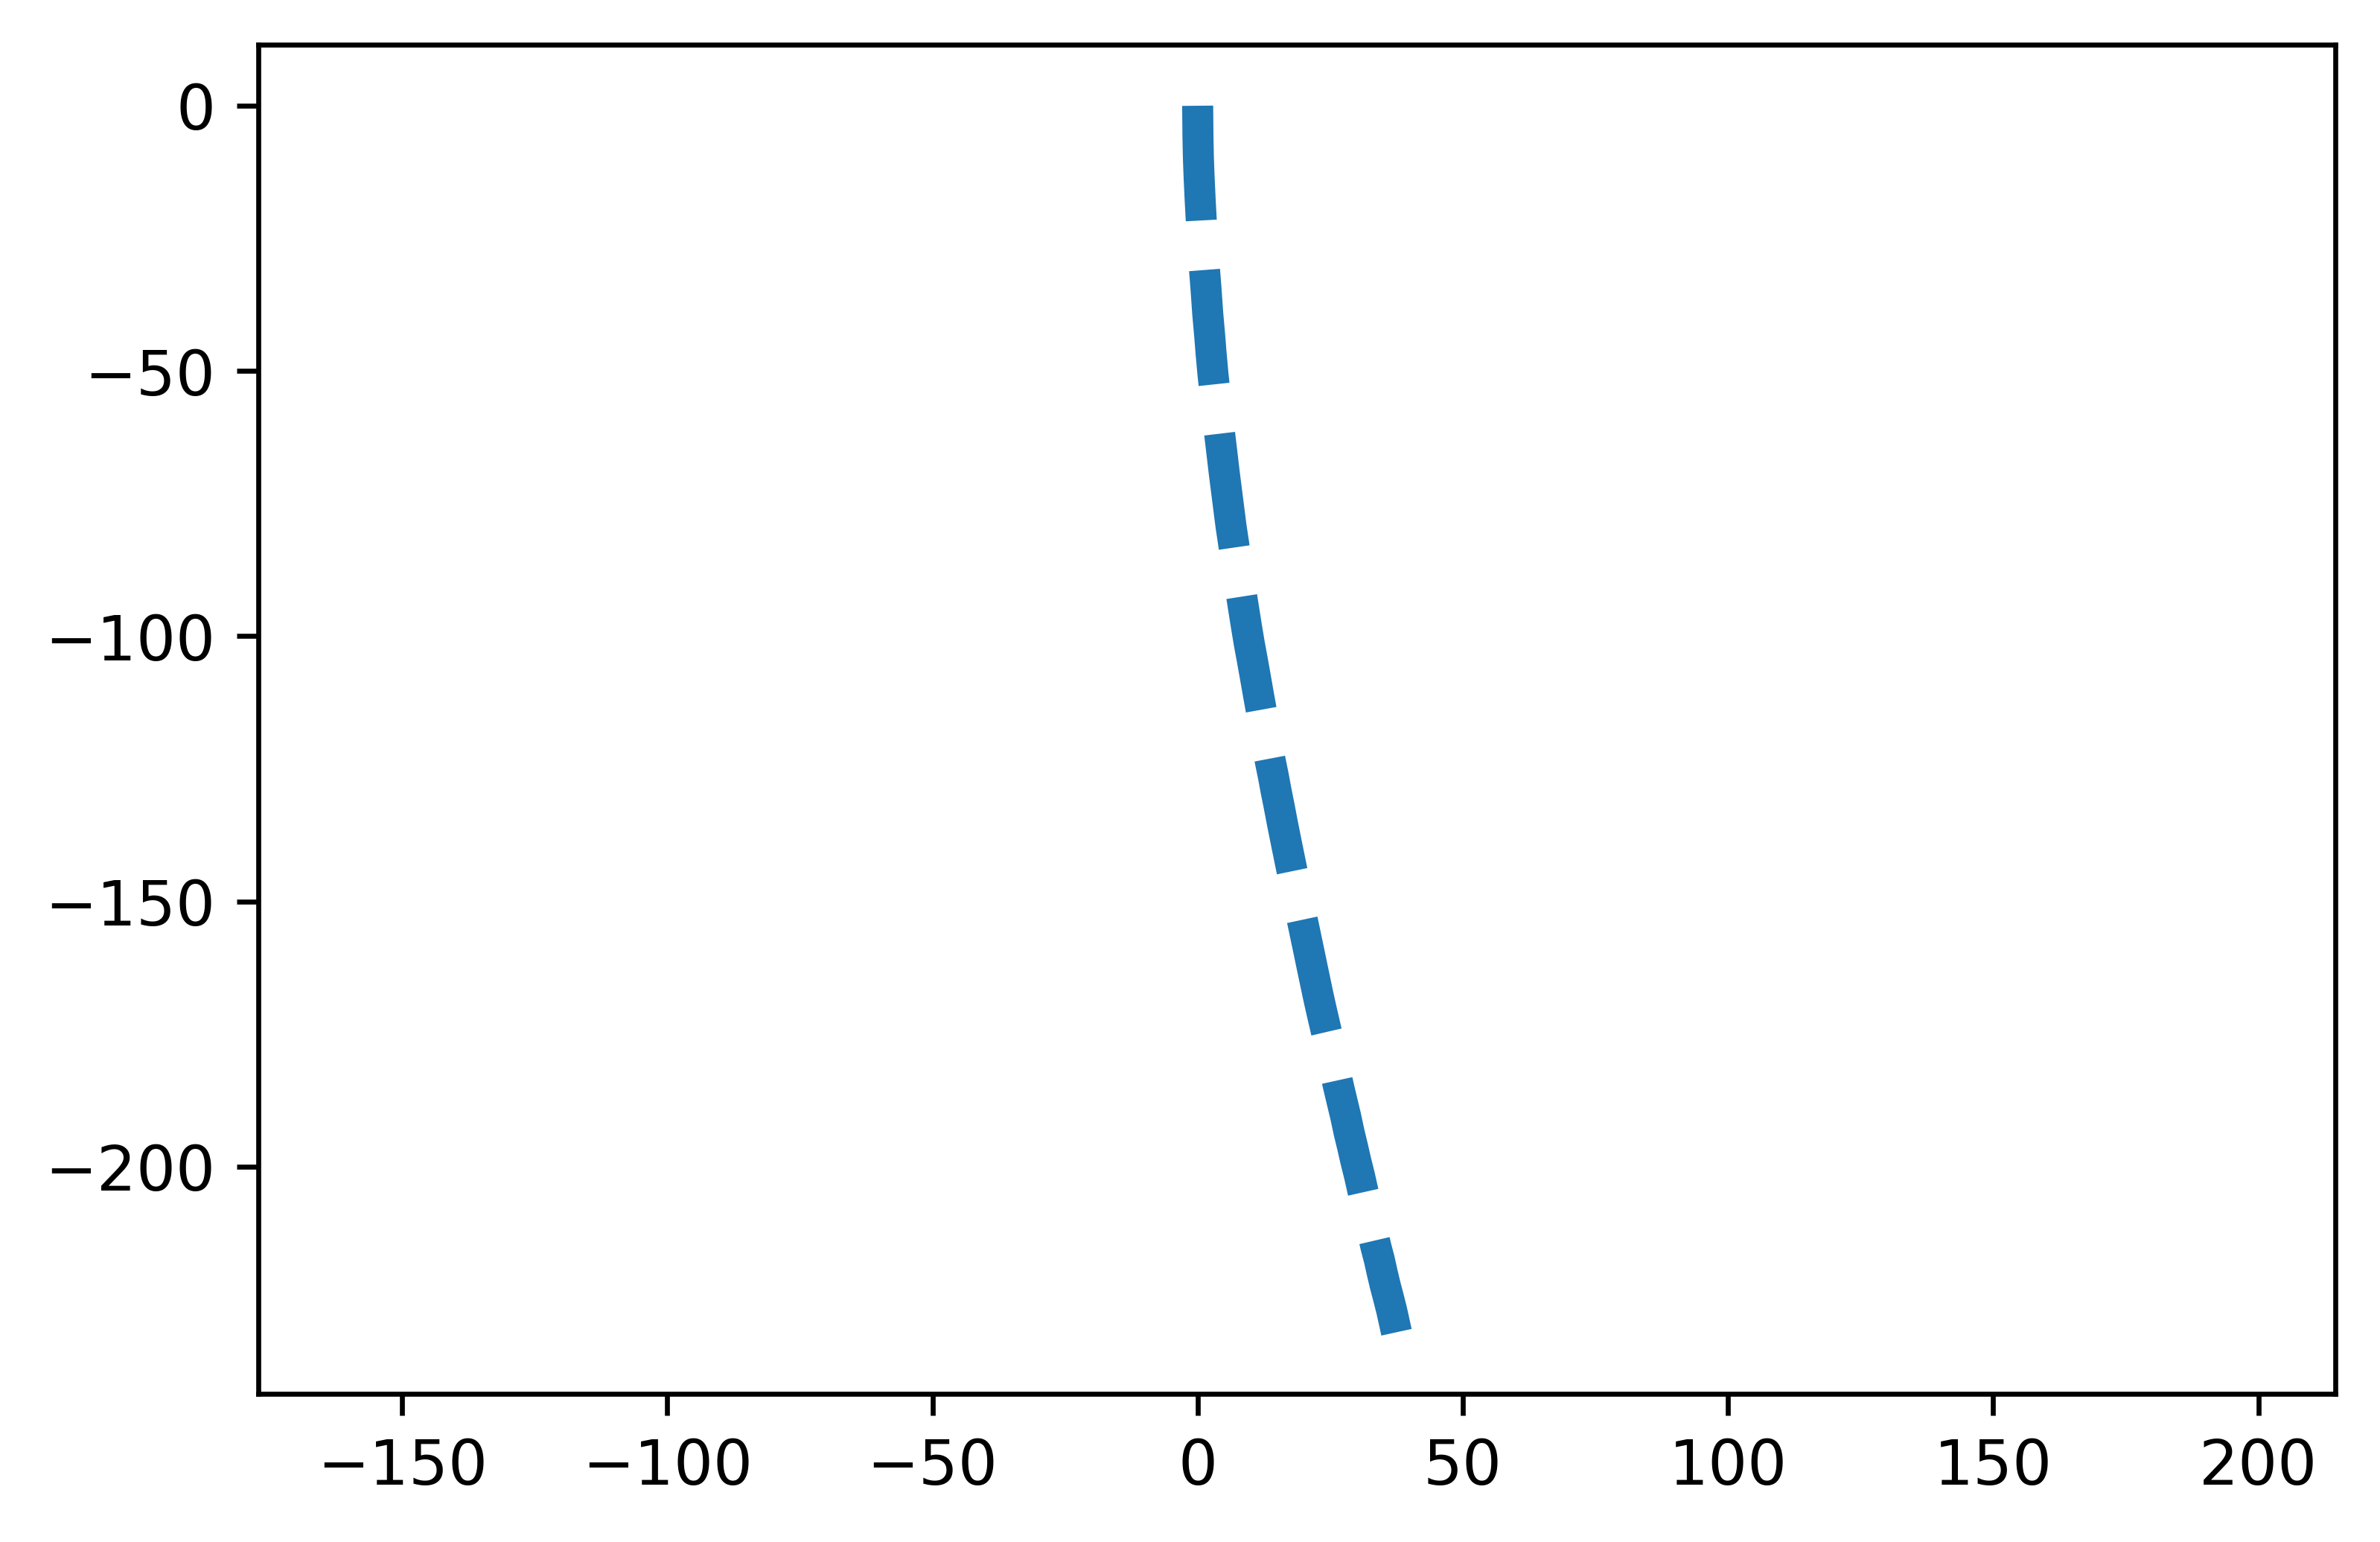

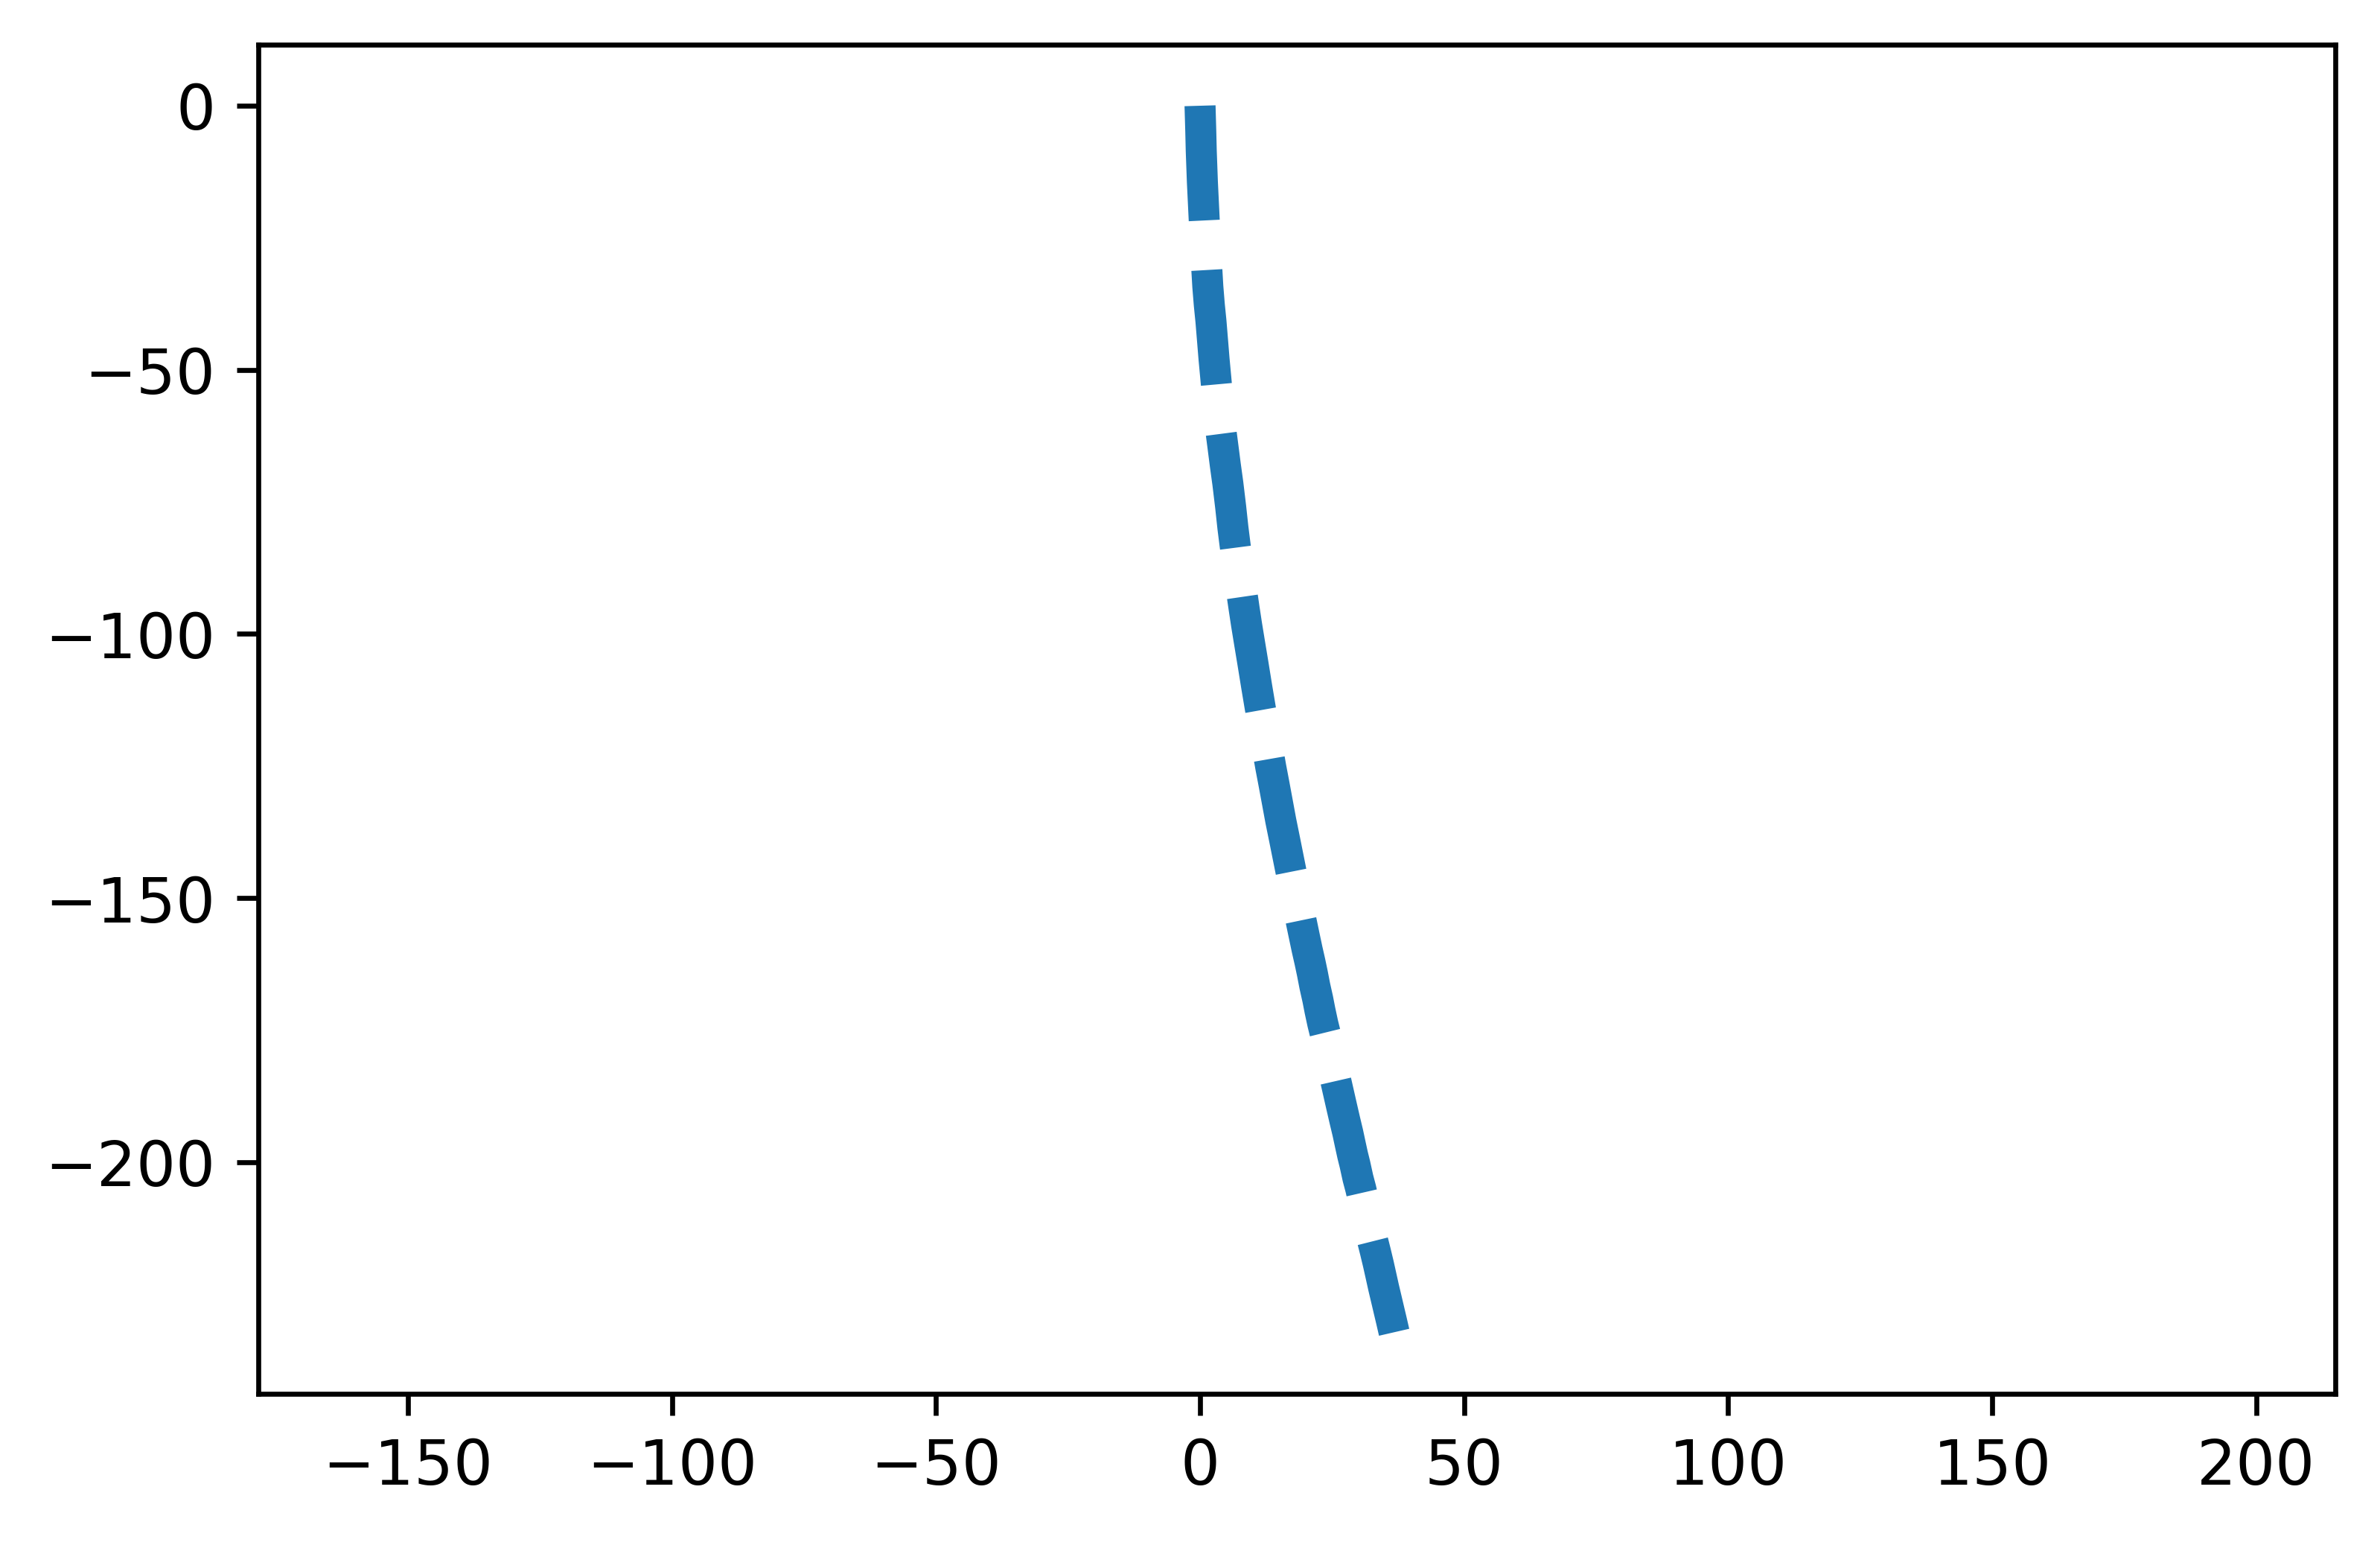

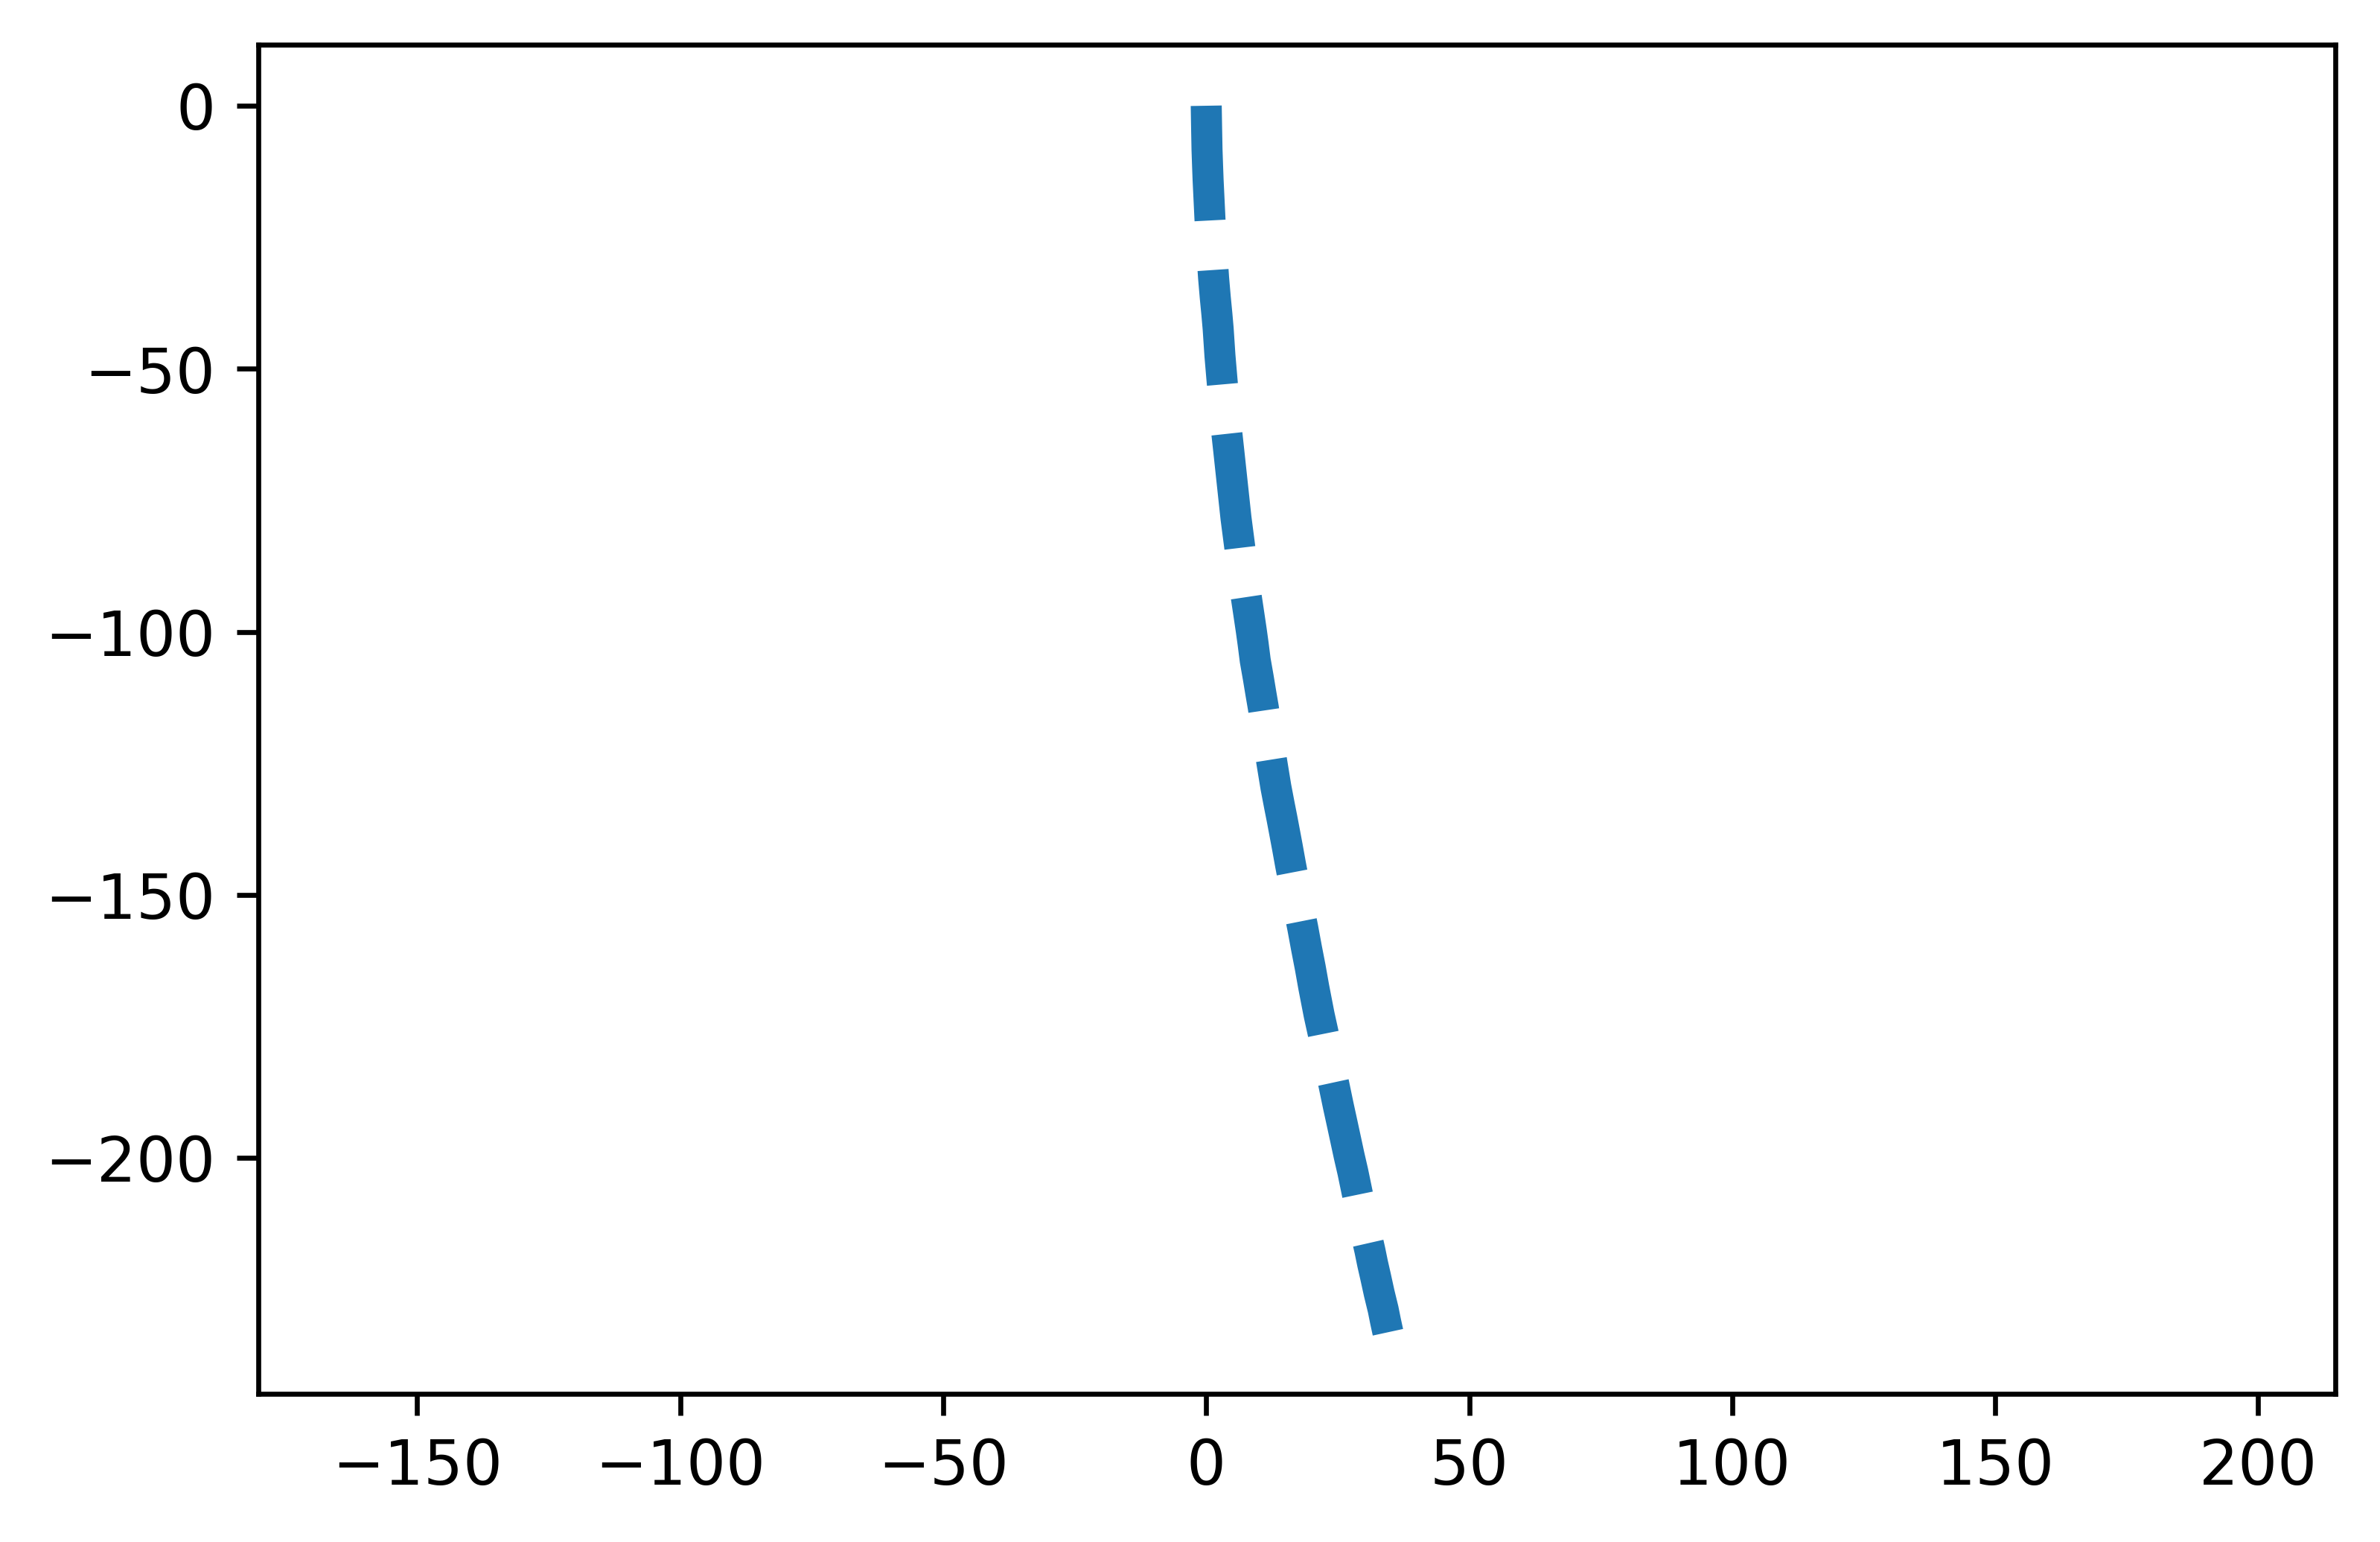

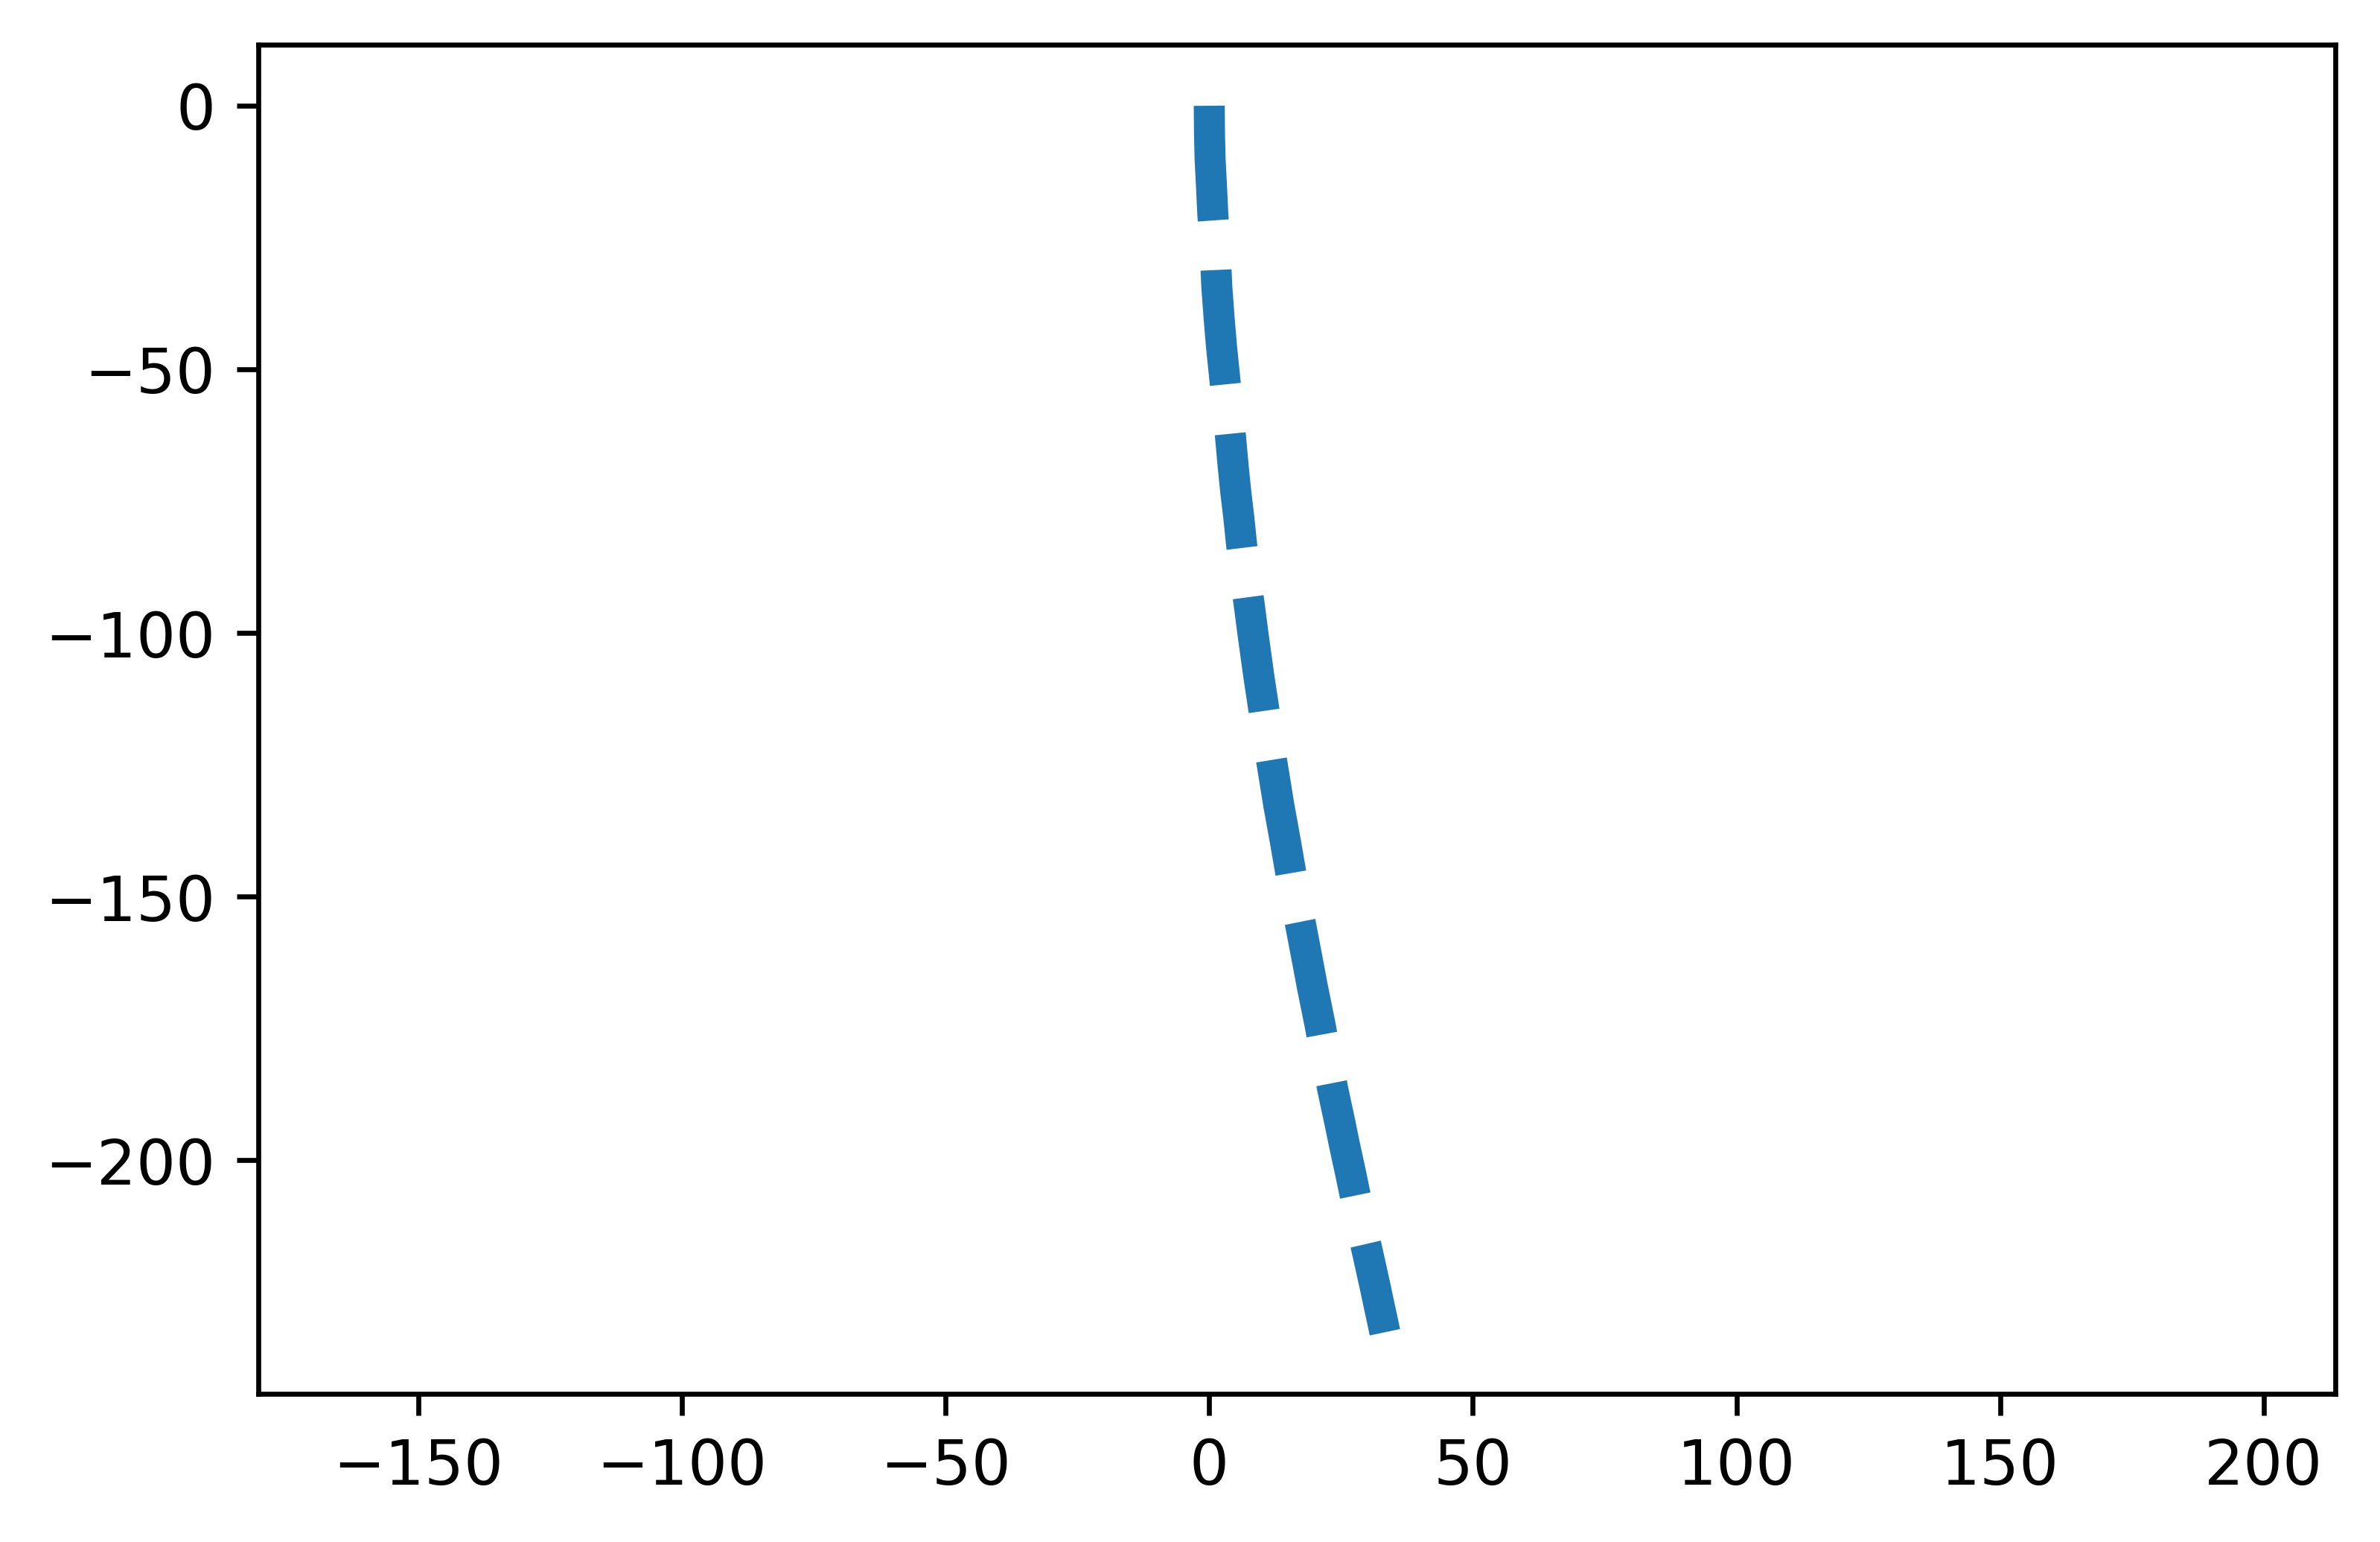

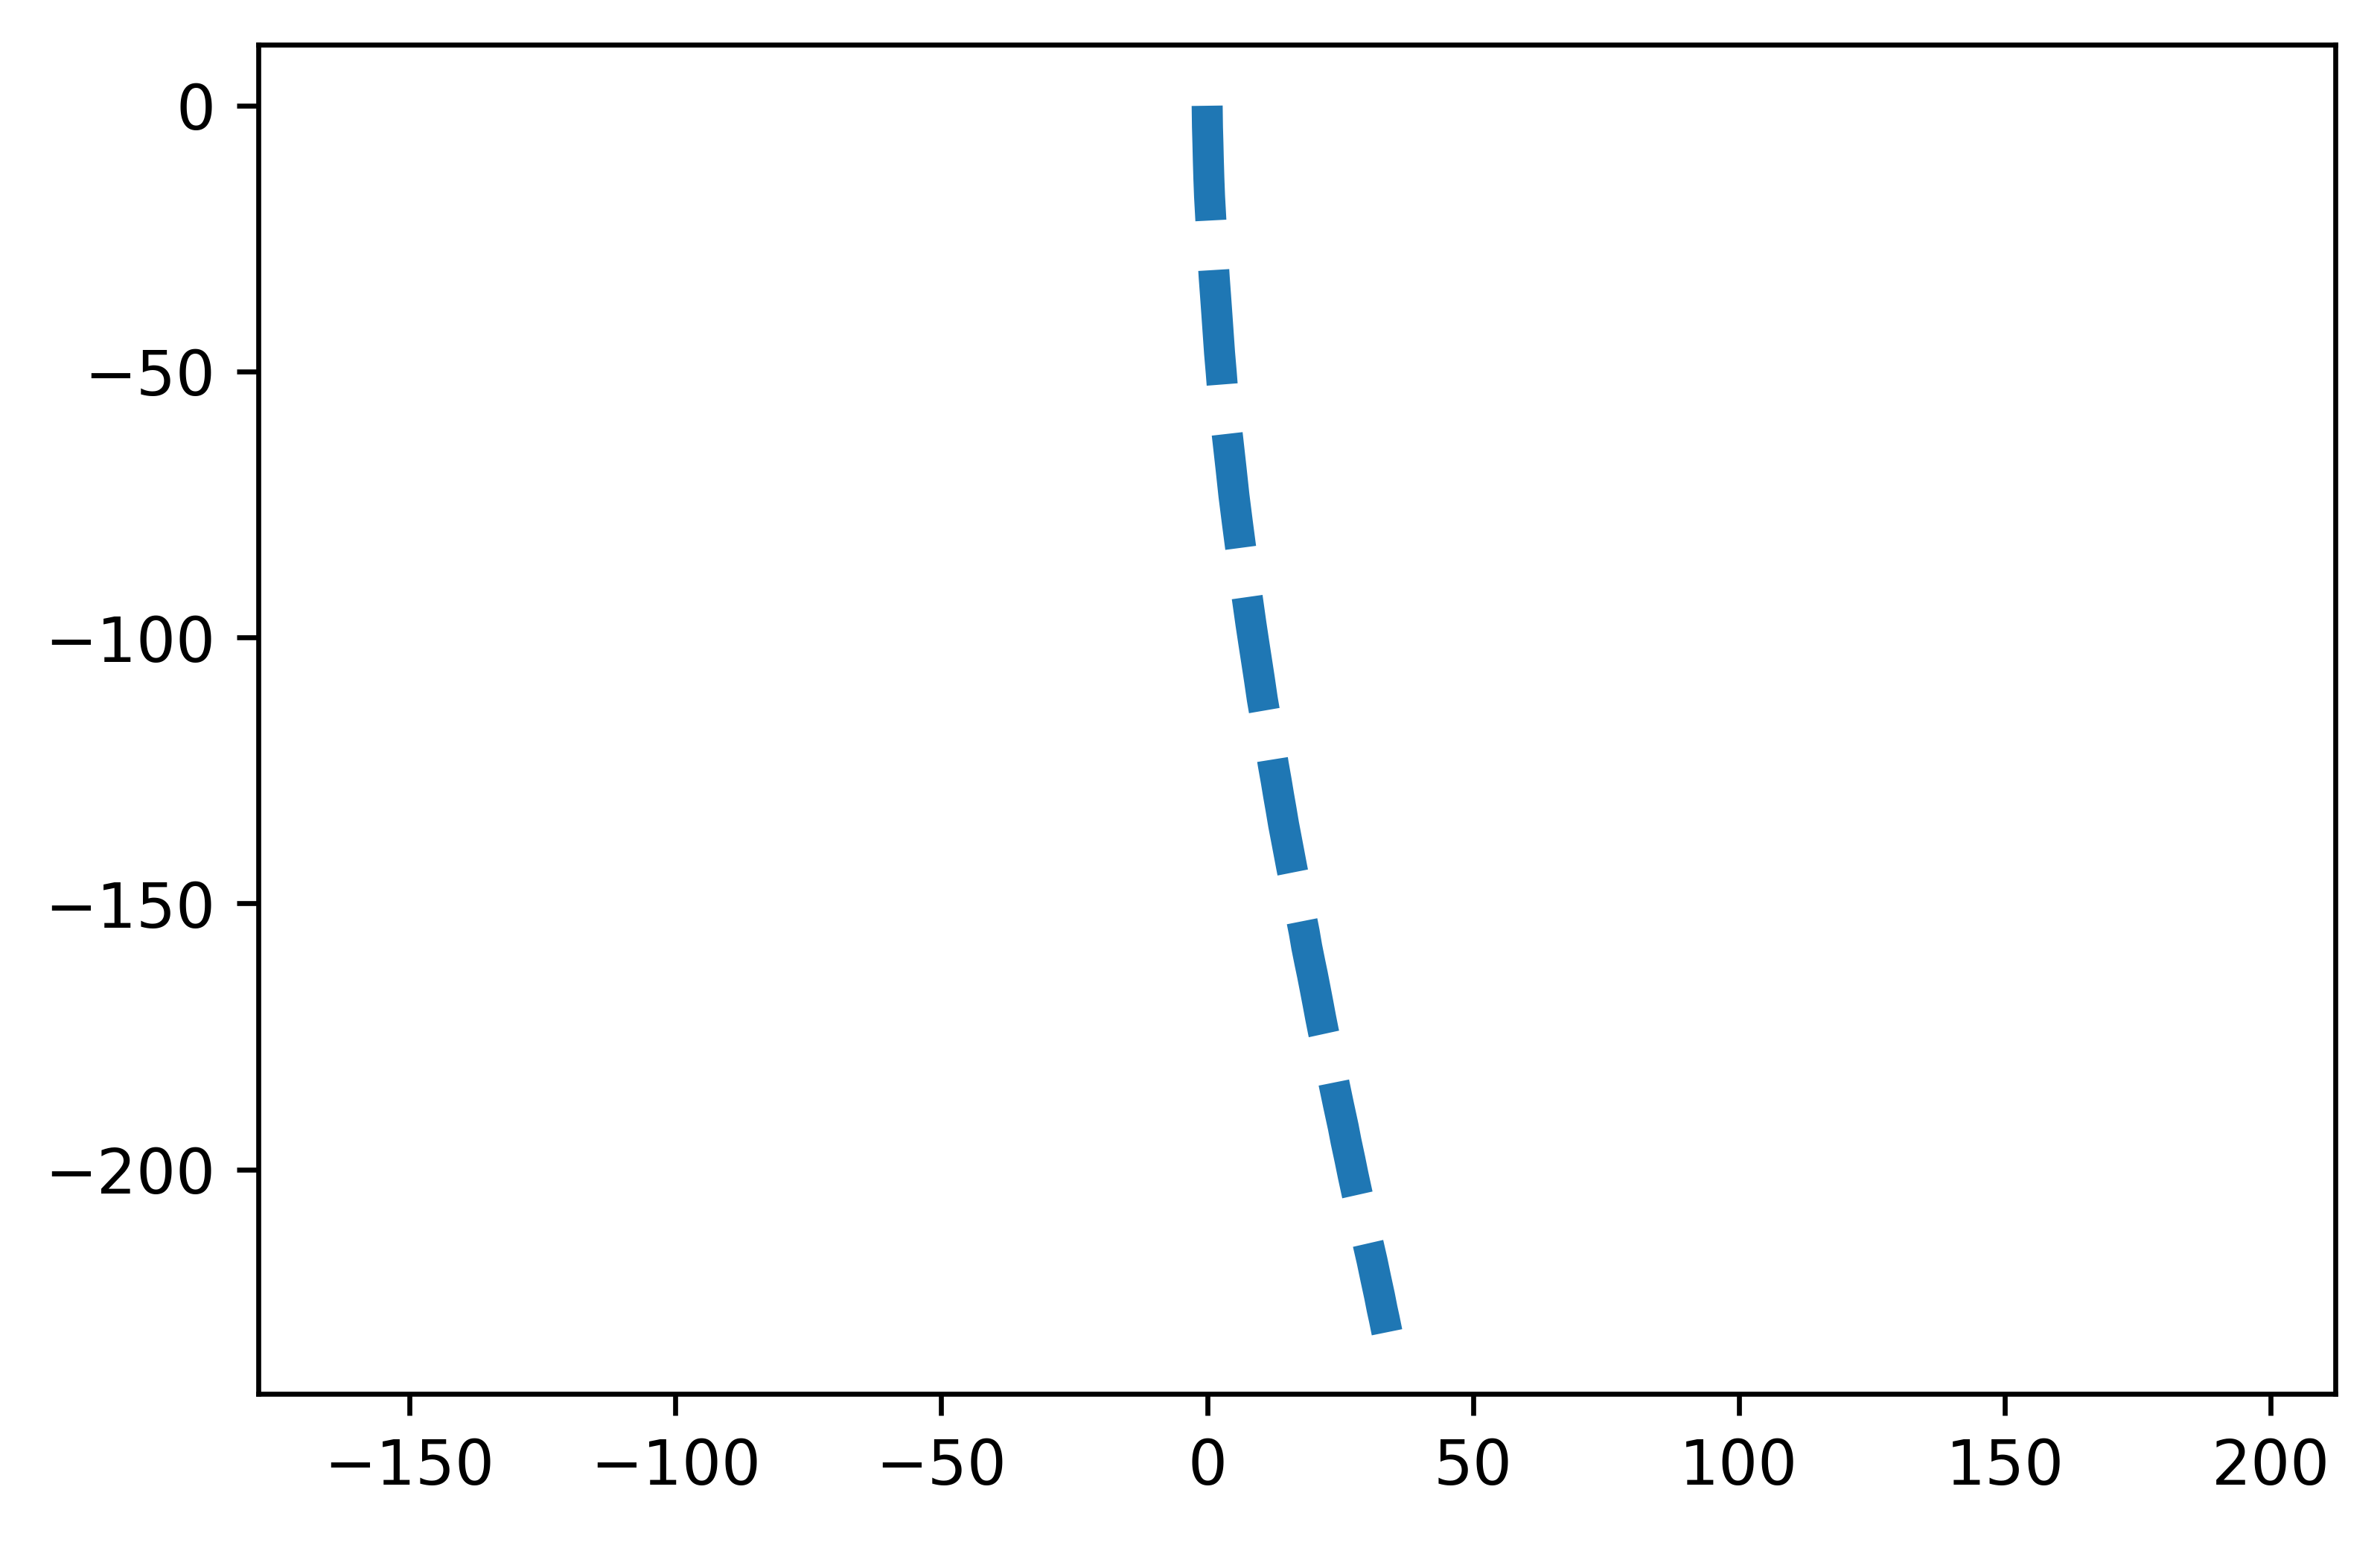

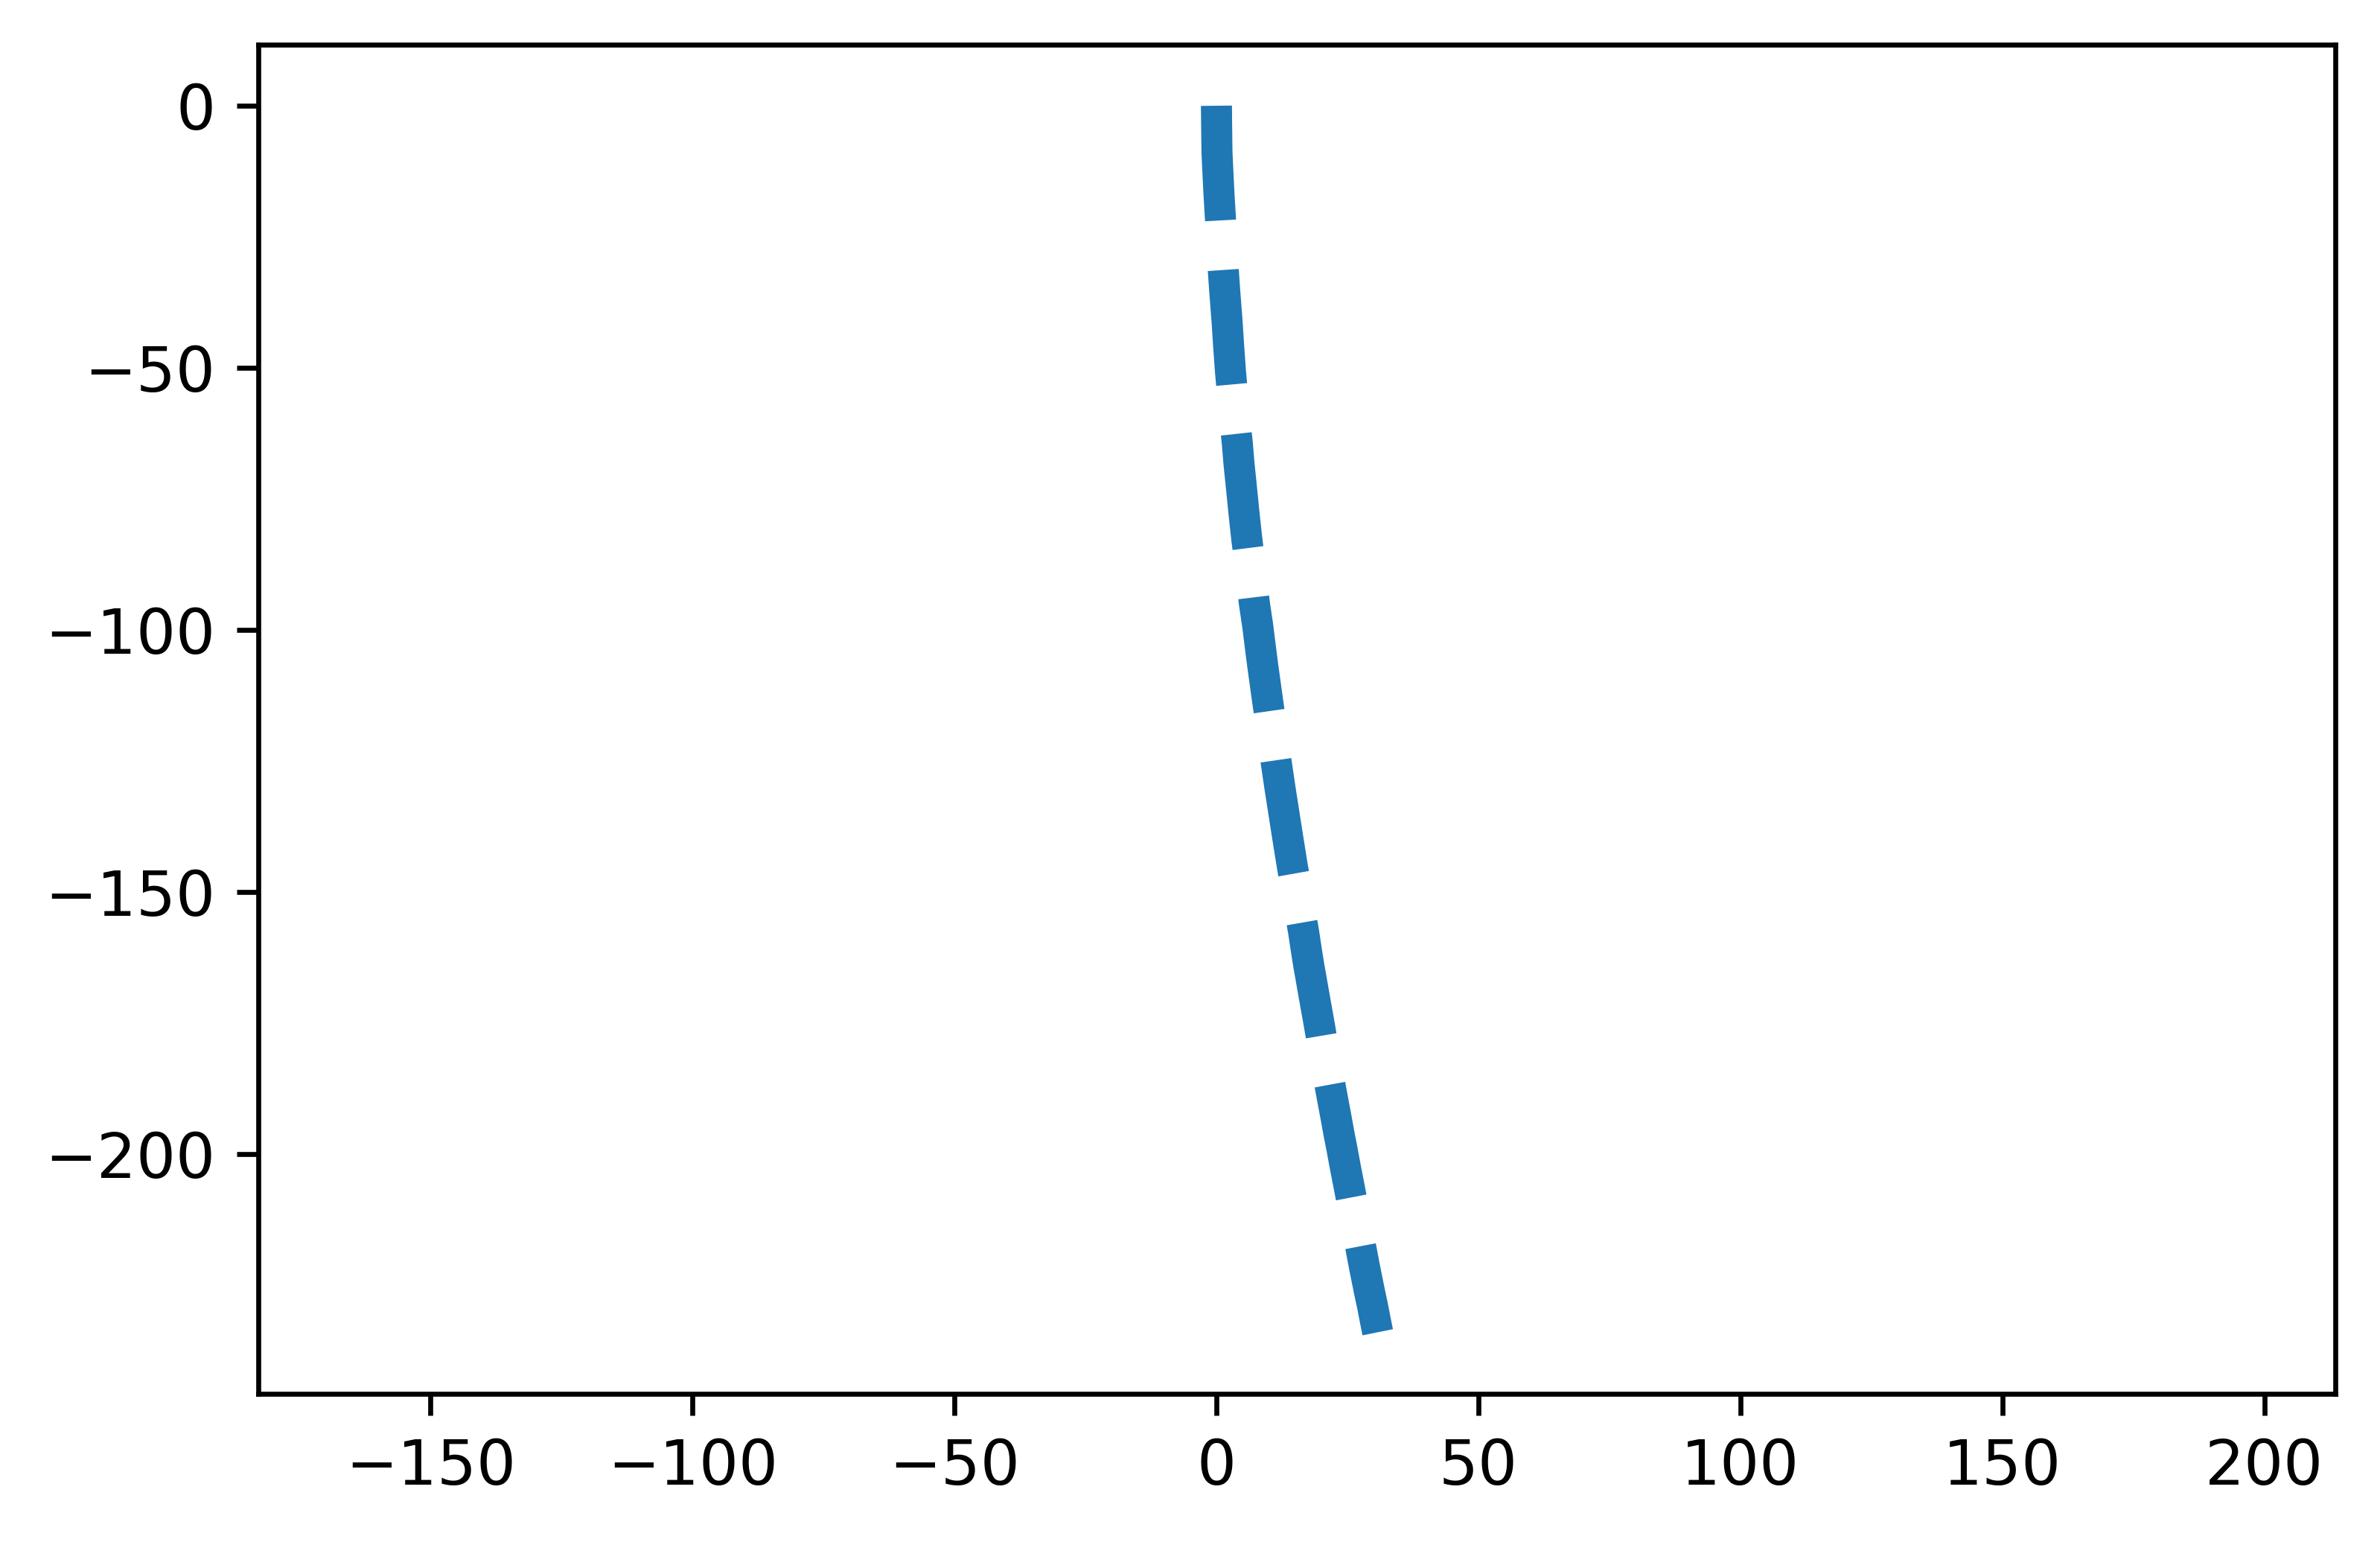

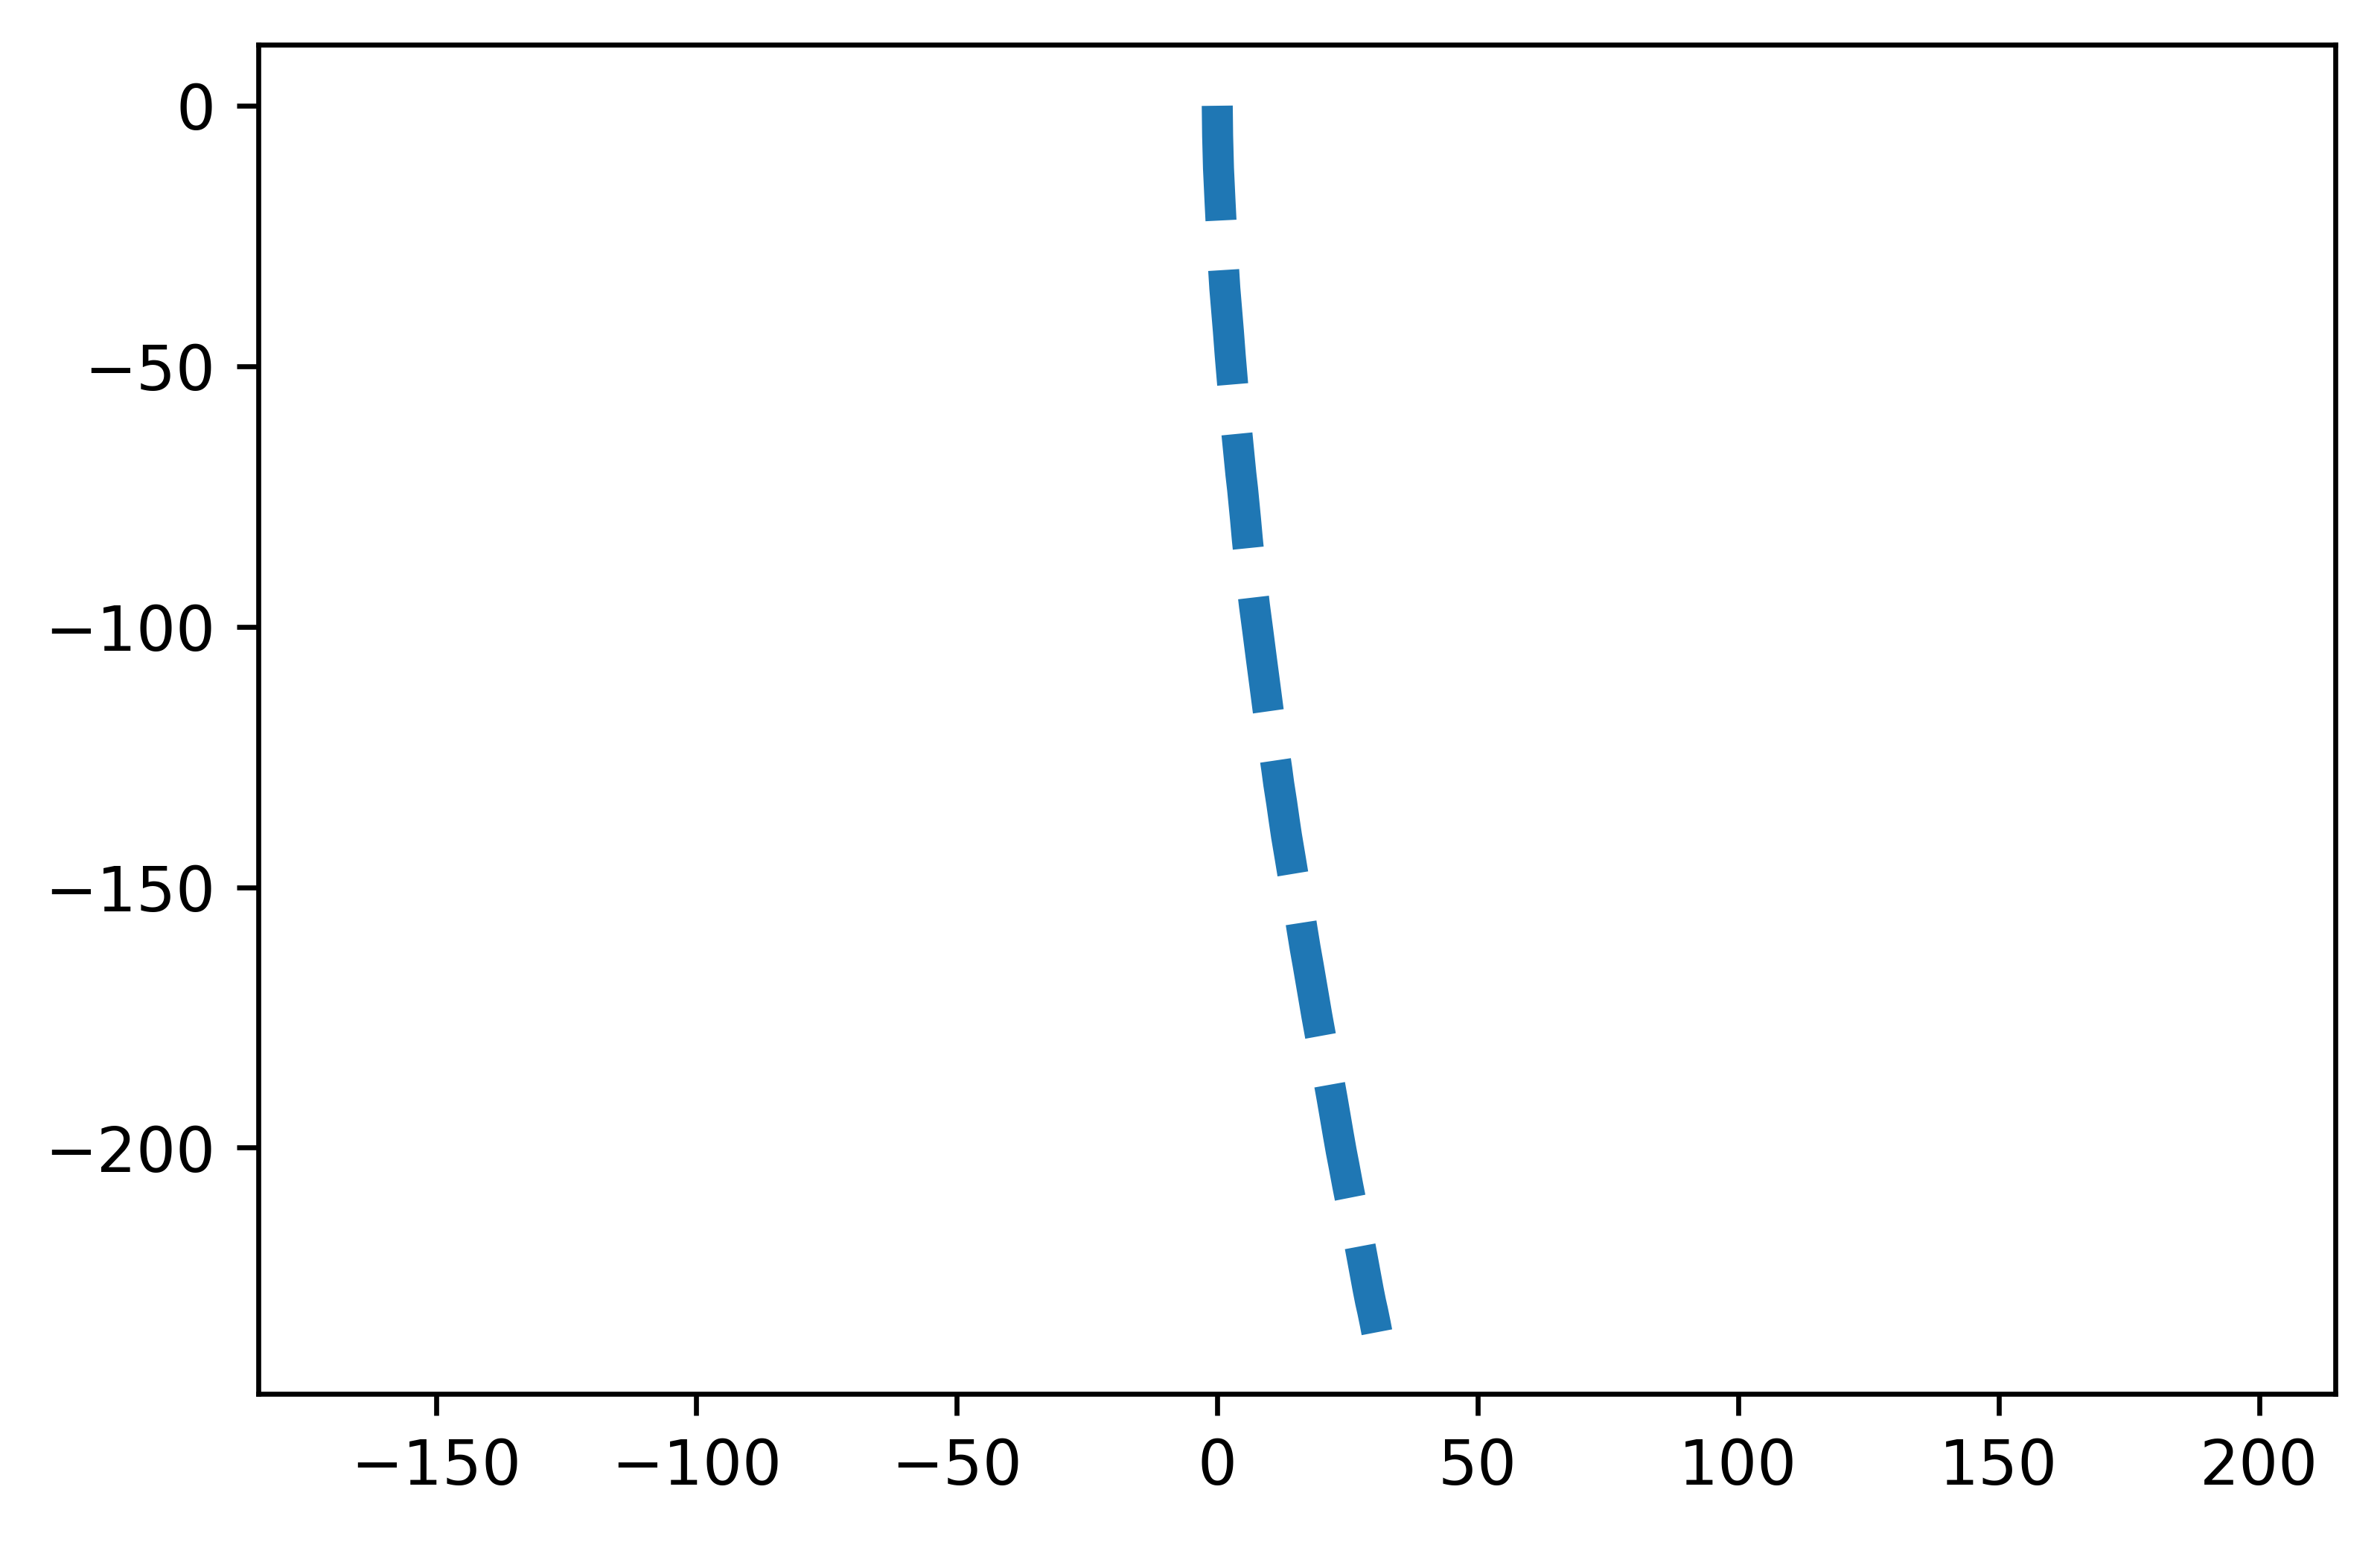

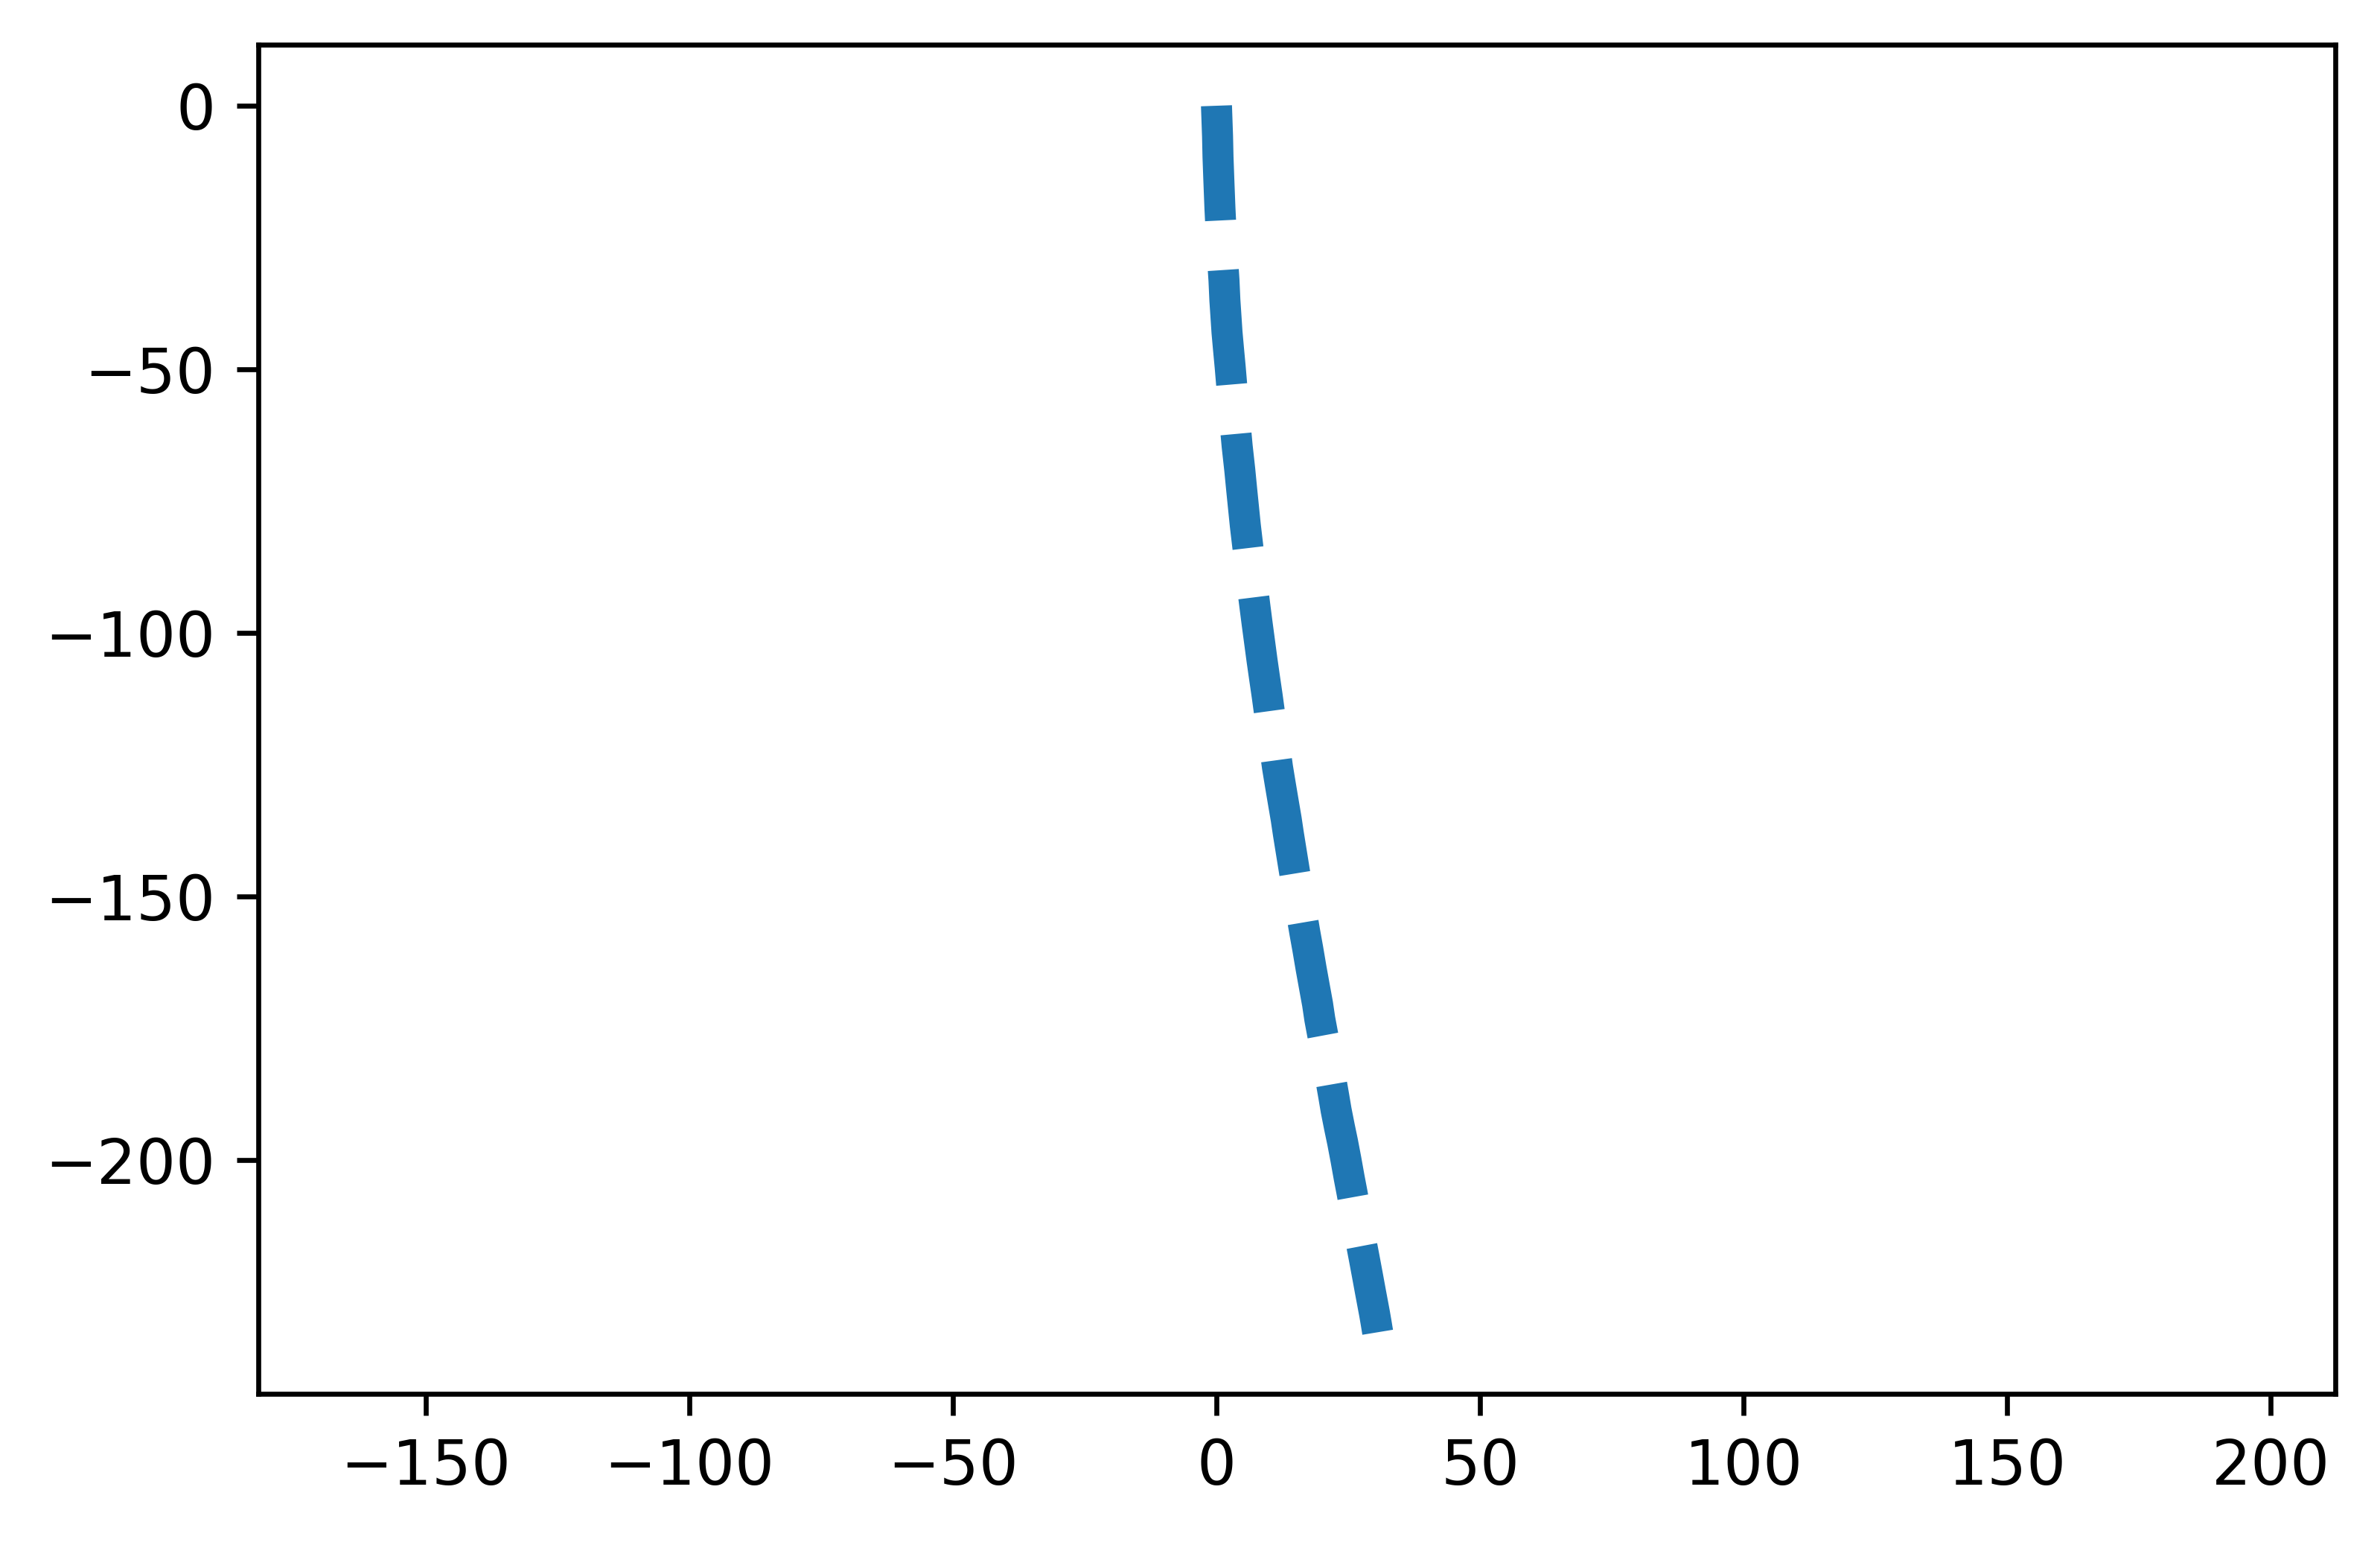

In [31]:
for i, forces in enumerate(["100", "200", "300"]):
  for j, EI in enumerate(["0.32", "0.35", "0.41"]):
    for k in range(3):

      plot_profile(f"profile_{EI}_{k}_{forces}g", real_data[j][k][i], save=True)
